In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time 
from datetime import datetime
import statsmodels.api as sm

import itertools

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import make_scorer, classification_report, accuracy_score, recall_score, f1_score, silhouette_score, calinski_harabasz_score

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression, ElasticNetCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from scipy.spatial.distance import cdist

import xgboost as xgb

sns.set_theme()

## Preprocessing

In [125]:
from google.colab import auth
auth.authenticate_user()

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from oauth2client.client import GoogleCredentials
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

category = drive.CreateFile({'id': '1CVePgIjgtOvf2P490JXu7-dOy0sXQ2OK'})
category.GetContentFile('category.csv')
category=pd.read_csv("category.csv")

events = drive.CreateFile({'id': '18QQkDNkU39raXjdtMgQ24GoJhk9KDEPG'})
events.GetContentFile('events.csv')
events=pd.read_csv("events.csv")

item_properties1 = drive.CreateFile({'id': '1En1O_QdnKUsV4GkE8TN2gE_6eFaAMss8'})
item_properties1.GetContentFile('item_properties1.csv')
item_properties1=pd.read_csv("item_properties1.csv")

item_properties2 = drive.CreateFile({'id': '1hH3cdOVJLV6zDvXQRooYm89OMveuVhIL'})
item_properties2.GetContentFile('item_properties2.csv')
item_properties2=pd.read_csv("item_properties2.csv", encoding='iso-8859-1')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Fichier category.csv

In [126]:
category.head()

categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0

Ce dataframe est l'implémentation d'une forêt d'arbres.

In [127]:
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [128]:
category.describe()

categoryid     parentid
count  1669.000000  1644.000000
mean    849.285201   847.571168
std     490.195116   505.058485
min       0.000000     8.000000
25%     427.000000   381.000000
50%     848.000000   866.000000
75%    1273.000000  1291.000000
max    1698.000000  1698.000000

In [129]:
category[np.isnan(category['parentid'])]

categoryid  parentid
5            231       NaN
589          791       NaN
861         1490       NaN
939          431       NaN
1111         755       NaN
1142         378       NaN
1208        1579       NaN
1211        1394       NaN
1322         659       NaN
1329        1057       NaN
1375         859       NaN
1392         803       NaN
1395         250       NaN
1476        1452       NaN
1484        1182       NaN
1490        1692       NaN
1614        1600       NaN
1616        1482       NaN
1622        1224       NaN
1623        1532       NaN
1624         395       NaN
1628         653       NaN
1629         140       NaN
1650        1698       NaN
1657         679       NaN

Les valeurs précédentes dans la colonne 'category' n'ont pas de catégories parentes.
Ce sont les racines des arbres.

In [130]:
category.duplicated().sum(axis=0)

0

Il n'y a pas de redondance.

In [131]:
category['parentid'].value_counts()

250.0     31
1009.0    22
362.0     22
351.0     19
1259.0    18
          ..
813.0      1
47.0       1
1198.0     1
19.0       1
673.0      1
Name: parentid, Length: 362, dtype: int64

### Fichier events.csv

In [132]:
events.head()

timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN

In [133]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


La colonne 'timestamp' correspond à l'horodatage de l'évènement.

La colonne 'visitorid' donne l'identifiant de l'utilisateur concerné par l'évènement.

La colonne 'event' indique le type d'évènement: 'view', 'addtocart' ou 'transaction'.

La colonne 'itemid' donne l'identifiant de l'item concerné par l'évènement.

La colonne 'transactionid' donne l'identifiant de la transaction.

In [134]:
print("Il y a %a visiteurs uniques." % events['visitorid'].unique().shape[0])
print("Il y a %a items uniques." % events['itemid'].unique().shape[0])

Il y a 1407580 visiteurs uniques.
Il y a 235061 items uniques.


In [135]:
print(events.duplicated().sum())

events=events.drop_duplicates(keep="first") #On élimine les 460 redondances.

460


In [136]:
events.isna().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733184
dtype: int64

In [137]:
events[- np.isnan(events['transactionid'])]['event'].value_counts()

transaction    22457
Name: event, dtype: int64

Les valeurs manquantes ne se trouvent que dans la colonne 'transactionid'.
Cette colonne ne possède une valeur que lorsqu'il y a une transaction.

Les valeurs de la colonne 'timestamp' ne sont pas ordonnées. On souhaiterait pouvoir considérer les évènements dans l'ordre chronologique.

In [138]:
events=events.sort_values(by='timestamp', ascending=True)

**Question 1: Comment se distribue les évènements suivant leur type ?**

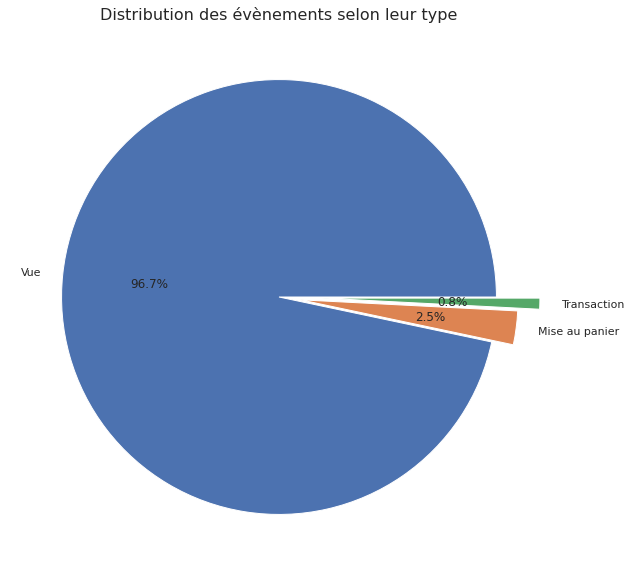

<Figure size 432x288 with 0 Axes>

In [139]:
event_counts = events['event'].value_counts()
sizes = event_counts.values
explode = (0, 0.1, 0.2)

plt.figure(figsize=(14,10))

plt.pie(x=sizes, labels=["Vue", "Mise au panier", "Transaction"], explode=explode, autopct='%1.1f%%', startangle=0) 

plt.title("Distribution des évènements selon leur type", fontsize=16)
plt.show()

#Récupération et sauvegarde de la figure
fig = plt.gcf()
fig.savefig("type_event.png", dpi = 300);


La grande partie des événements sont donc des "view".

**Question 2: Comment se distribue les évènements dans le temps ?**

In [140]:
events['date']=pd.to_datetime(arg=events['timestamp'], unit='ms')

events['month']=events['date'].dt.month
events['weekday']=events['date'].dt.weekday
events['hour']=events['date'].dt.hour
events['day_of_year']=events['date'].dt.date
events['day']=events['date'].dt.day
events['weekday_name']= pd.to_datetime(events.timestamp,unit = 'ms').dt.day_name()

events.head()

timestamp  visitorid      event  ...  day_of_year  day weekday_name
1462974  1430622004384     693516  addtocart  ...   2015-05-03    3       Sunday
1464806  1430622011289     829044       view  ...   2015-05-03    3       Sunday
1463000  1430622013048     652699       view  ...   2015-05-03    3       Sunday
1465287  1430622024154    1125936       view  ...   2015-05-03    3       Sunday
1462955  1430622026228     693516       view  ...   2015-05-03    3       Sunday

[5 rows x 12 columns]

In [141]:
print("Début de la récolte des données:", events['day_of_year'].min())
print("Fin de la récolte des données:", events['day_of_year'].max())

Début de la récolte des données: 2015-05-03
Fin de la récolte des données: 2015-09-18


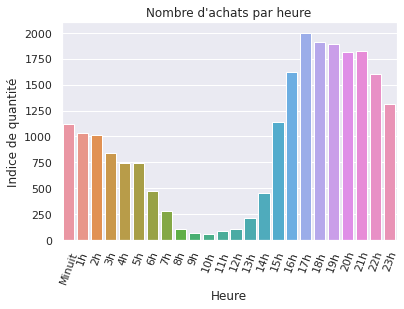

In [142]:
#Répartition des achats sur une journée

trans_df = events[events.event == 'transaction']
sns.countplot(x= trans_df.hour)

plt.xticks([0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13, 14 , 15, 16, 17, 18, 19, 20, 21, 22, 23],
           ['Minuit','1h','2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h', '19h', '20h', '21h', '22h', '23h'],
           rotation=70)
plt.xlabel("Heure")
plt.ylabel("Indice de quantité")
plt.title("Nombre d'achats par heure")

fig = plt.gcf()
fig.savefig("transaction_hour.png", dpi = 300);

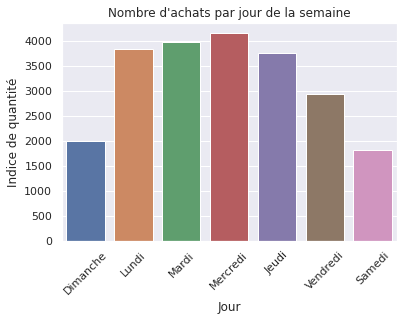

In [143]:
#Répartition des achats sur une semaine

sns.countplot(x= trans_df.weekday_name)

plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Dimanche', 'Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi'], rotation = 45);
plt.xlabel("Jour")
plt.ylabel("Indice de quantité")
plt.title("Nombre d'achats par jour de la semaine")

fig = plt.gcf()
fig.savefig("transaction_weekday.png", dpi = 300);

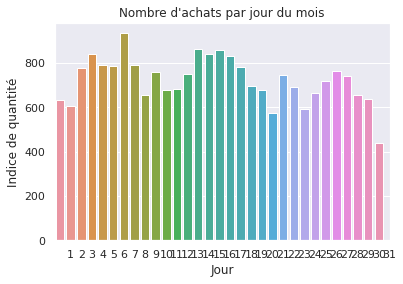

In [149]:
#Répartition des achats sur un mois

sns.countplot(x= trans_df.day)

plt.xticks(range(1,32))
plt.xlabel("Jour")
plt.ylabel("Indice de quantité")
plt.title("Nombre d'achats par jour du mois")

fig = plt.gcf()
fig.savefig("transaction_day.png", dpi = 300);

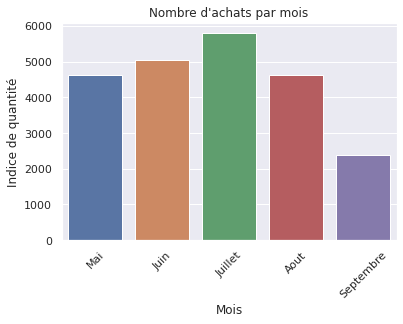

In [150]:
#Répartition des achats par mois

sns.countplot(x= trans_df.month)

plt.xticks(ticks=[0,1,2,3, 4], labels=['Mai', 'Juin', 'Juillet', 'Aout', 'Septembre'], rotation=45);
plt.xlabel("Mois")
plt.ylabel("Indice de quantité")
plt.title("Nombre d'achats par mois")

fig = plt.gcf()
fig.savefig("transaction_month.png", dpi = 300);

**Questions 3: En combien de temps un acheteur se décide-t-il ?**

Pour analyser l'enchaînement des évènements menant à un achat, on sépare les évènements selon leur type et on les regroupe en un même dataframe.

In [151]:
views =events[['visitorid', 'itemid', 'date']][events['event']=='view']
addtc =events[['visitorid', 'itemid', 'date']][events['event']=='addtocart']
trans=events[['visitorid', 'itemid', 'date']][events['event']=='transaction']

merge_temp=views.merge(addtc, on = ['visitorid', 'itemid'], suffixes=[' (view)', ' (add to cart)'])
merge=merge_temp.merge(trans, on = ['visitorid', 'itemid'])
combin=merge.rename(columns={'date': 'date (transaction)'})

combin.head()

visitorid  itemid  ...      date (add to cart)      date (transaction)
0      41386  340921  ... 2015-05-05 04:38:56.764 2015-05-05 04:54:20.405
1      41386  340921  ... 2015-05-05 04:38:56.764 2015-05-05 04:54:20.405
2     345781  438400  ... 2015-05-03 03:11:33.415 2015-05-03 03:35:01.772
3     345781  438400  ... 2015-05-03 03:11:33.415 2015-05-03 03:35:01.772
4     345781  438400  ... 2015-05-03 03:11:33.415 2015-05-03 03:35:01.772

[5 rows x 5 columns]

Il est nécessaire que 'date (transaction)' soit supérieur à 'date (add to cart)'.

Il est nécessaire que 'date (add to cart)' soit supérieur à 'date (view)'. 

In [152]:
combin = combin[ combin['date (add to cart)'] > combin['date (view)']]
combin = combin[ combin['date (transaction)'] > combin['date (add to cart)']]

On sélectionne le 1er évènement "view", puis le 1er évènement "addtocart".

In [153]:
df=combin.groupby(['visitorid', 'itemid', 'date (add to cart)', 'date (transaction)']).agg('min').reset_index()
combin_first=df.groupby(['visitorid', 'itemid', 'date (transaction)', 'date (view)']).agg('min').reset_index()

combin_first.head()

visitorid  itemid  ...             date (view)      date (add to cart)
0        172   10034  ... 2015-07-14 04:43:09.537 2015-08-15 00:50:16.912
1        172  465522  ... 2015-08-15 01:06:38.438 2015-08-15 01:13:39.691
2        264  161949  ... 2015-09-07 17:09:12.830 2015-09-07 17:31:06.184
3        264  459835  ... 2015-09-07 17:31:02.509 2015-09-07 17:31:04.088
4        419   19278  ... 2015-07-29 02:57:46.756 2015-07-29 03:47:53.631

[5 rows x 5 columns]

On calcule les différences entre les dates des évènements.

In [154]:
combin_first['view_to_addtocart']=combin_first['date (add to cart)']-combin_first['date (view)']
combin_first['addtocart_to_transaction']=combin_first['date (transaction)']-combin_first['date (add to cart)']

combin_first['view_to_addtocart']=combin_first['view_to_addtocart'].apply(lambda x: x.total_seconds())
combin_first['addtocart_to_transaction']=combin_first['addtocart_to_transaction'].apply(lambda x: x.total_seconds())

combin_first

combin_first.head()

visitorid  itemid  ... view_to_addtocart addtocart_to_transaction
0        172   10034  ...       2750827.375                 2324.774
1        172  465522  ...           421.253                  921.539
2        264  161949  ...          1313.354                  219.524
3        264  459835  ...             1.579                  221.526
4        419   19278  ...          3006.875                 4519.064

[5 rows x 7 columns]

On peut donc afficher la distribution du temps entre deux évènements. Pour plus de lisibilité, on représente la distribution par la courbe par centile.

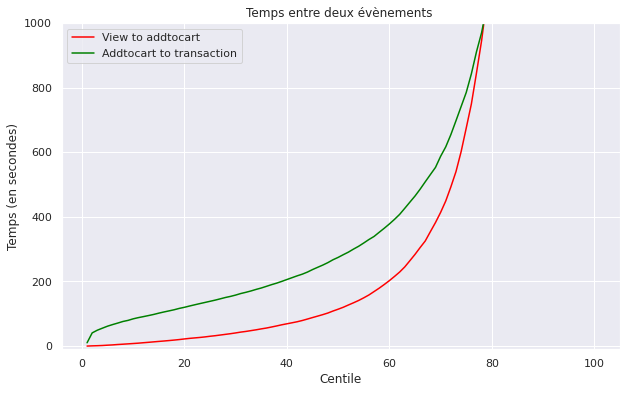

<Figure size 432x288 with 0 Axes>

In [155]:
fig=plt.figure(figsize=(10,6))

y1=combin_first['view_to_addtocart'].quantile(np.linspace(0,1,100))
sns.lineplot(x=range(1,101), y=y1.values, color='red', label="View to addtocart")

y2=combin_first['addtocart_to_transaction'].quantile(np.linspace(0,1,100))
sns.lineplot(x=range(1,101), y=y2.values, color='green', label="Addtocart to transaction")

plt.ylim([-10,1000])

plt.title("Temps entre deux évènements ")
plt.xlabel("Centile")
plt.ylabel("Temps (en secondes)")

plt.legend()
plt.show()

fig = plt.gcf()
fig.savefig("time_between_event.png", dpi = 300);

**Question 4: Combien de fois un item est-il vu avant d'être acheté?**

On calcule le nombre d'évènements "view" par item et visiteur.

In [156]:
view_counts=combin.groupby(['visitorid', 'itemid', 'date (add to cart)', 'date (transaction)']).size().reset_index()

combin["view_counts"]=view_counts.iloc[:,-1]

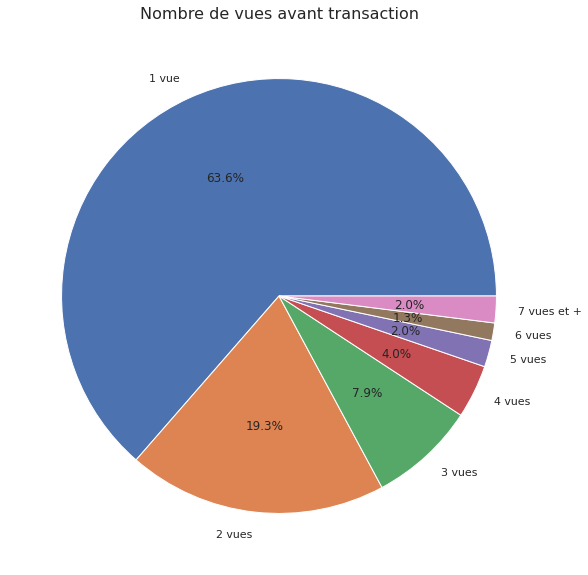

<Figure size 432x288 with 0 Axes>

In [157]:
view_counts = combin['view_counts'].value_counts()

sizes=list(view_counts.iloc[:6].values)
sizes.append(view_counts.iloc[7:].sum())

labels = ['1 vue', '2 vues','3 vues','4 vues','5 vues','6 vues', '7 vues et +']


plt.figure(figsize=(14,10))

plt.pie(x=sizes, labels=labels, autopct='%1.1f%%', startangle=0) 

plt.title("Nombre de vues avant transaction", fontsize=16)
plt.show()

fig=plt.gcf()
fig.savefig("nb_view_before_purchase.png", dpi = 300);

**Question 5: Y a-t-il des relations entre les évènements en les regroupant par journée ?**

In [158]:
events_day=events[['day_of_year', 'event', 'visitorid']]

events_day=events_day.groupby(['day_of_year','event']).size().reset_index()

events_day=events_day.rename(columns={0: 'visitors_count'})

events_day=events_day.pivot(index='day_of_year', columns='event', values='visitors_count').reset_index()

events_day.head()

event day_of_year  addtocart  transaction   view
0      2015-05-03        296           83  13303
1      2015-05-04        578          154  18681
2      2015-05-05        561          225  22225
3      2015-05-06        647          258  23015
4      2015-05-07        572          217  22368

In [159]:
events_day['view_per_addtocart']=events_day.view / events_day.addtocart
events_day['view_per_transaction']=events_day.view / events_day.transaction
events_day['addtocart_per_transaction']=events_day.addtocart / events_day.transaction


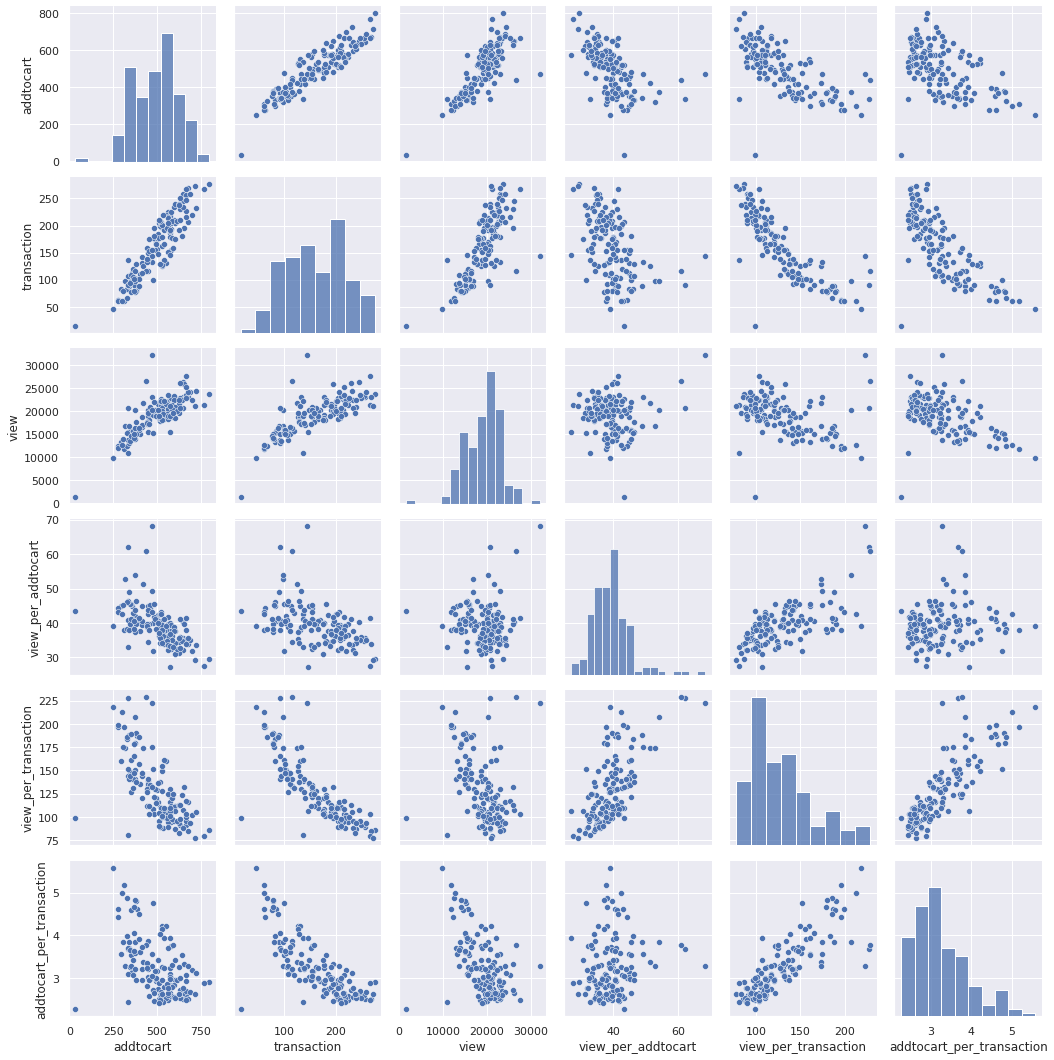

In [160]:
sns.pairplot(events_day)

fig=plt.gcf()
fig.savefig("event_day_pairplot.png", dpi = 300);

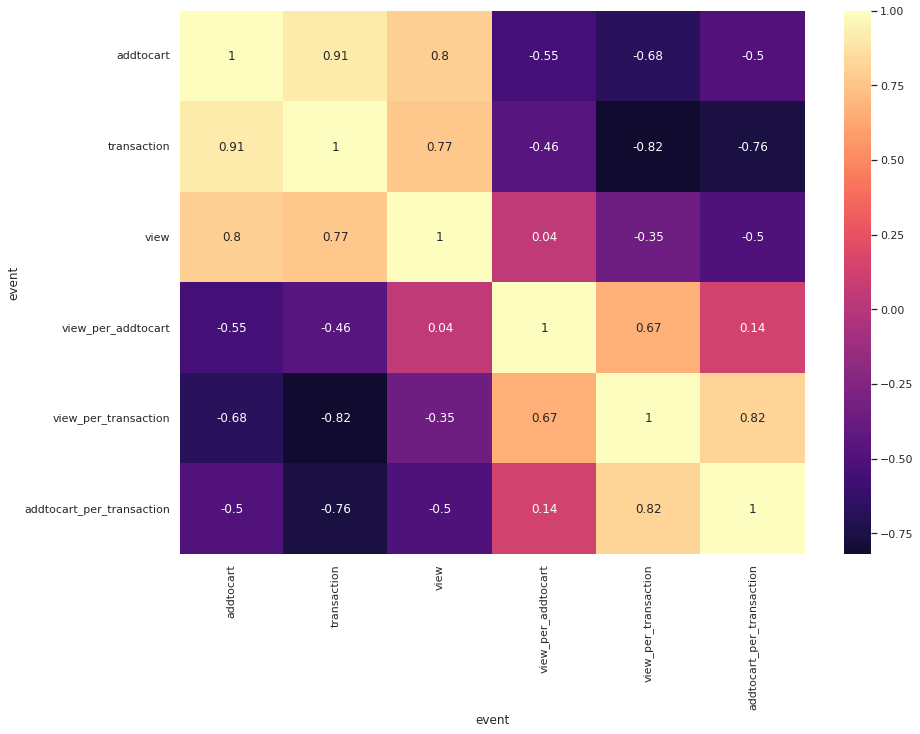

In [161]:
plt.figure(figsize=(14,10))

sns.heatmap(events_day.corr(), annot= True, center=0, cmap="magma")

fig=plt.gcf()
fig.savefig("event_day_heatmap.png", dpi = 300);

**Question 6: Y a-t-il des relations entre les évènements en les regroupant par item ?**

In [162]:
events_item=events[['itemid', 'event', 'visitorid']]

events_item1= events_item.groupby(['itemid','event']).agg({"visitorid": "nunique"}).reset_index()
events_item1=events_item1.rename(columns={'visitorid': 'visitors_unique'})

events_item2=events_item.groupby(['itemid','event']).size().reset_index().rename(columns={0: 'visitors_count'})

events_item=events_item1.merge(events_item2, on=['event', 'itemid'])

events_item=events_item.pivot(index='itemid', columns='event', values=['visitors_count', 'visitors_unique']).reset_index()

events_item=events_item.dropna()

events_item= events_item.set_index('itemid')

events_item.columns=['_'.join(col) for col in events_item.columns.values]

events_item = events_item.drop(['visitors_unique_addtocart','visitors_unique_transaction'], axis=1)

events_item=events_item.rename(columns={'visitors_count_addtocart': 'addtocart',
                            'visitors_count_transaction': 'transaction',
                            'visitors_count_view': 'view',
                            'visitors_unique_view': 'unique_view'})
events_item.head()

addtocart  transaction  view  unique_view
itemid                                           
15            3.0          1.0  18.0         13.0
19            1.0          1.0  16.0         14.0
25            4.0          2.0  58.0         48.0
42            2.0          1.0  36.0         30.0
147           5.0          4.0  89.0         68.0

In [163]:
events_item['ratio_unique_view']=events_item.unique_view / events_item['view']

events_item['view_per_addtocart']=events_item.view / events_item.addtocart
events_item['view_per_transaction']=events_item.view / events_item.transaction
events_item['addtocart_per_transaction']=events_item.addtocart / events_item.transaction

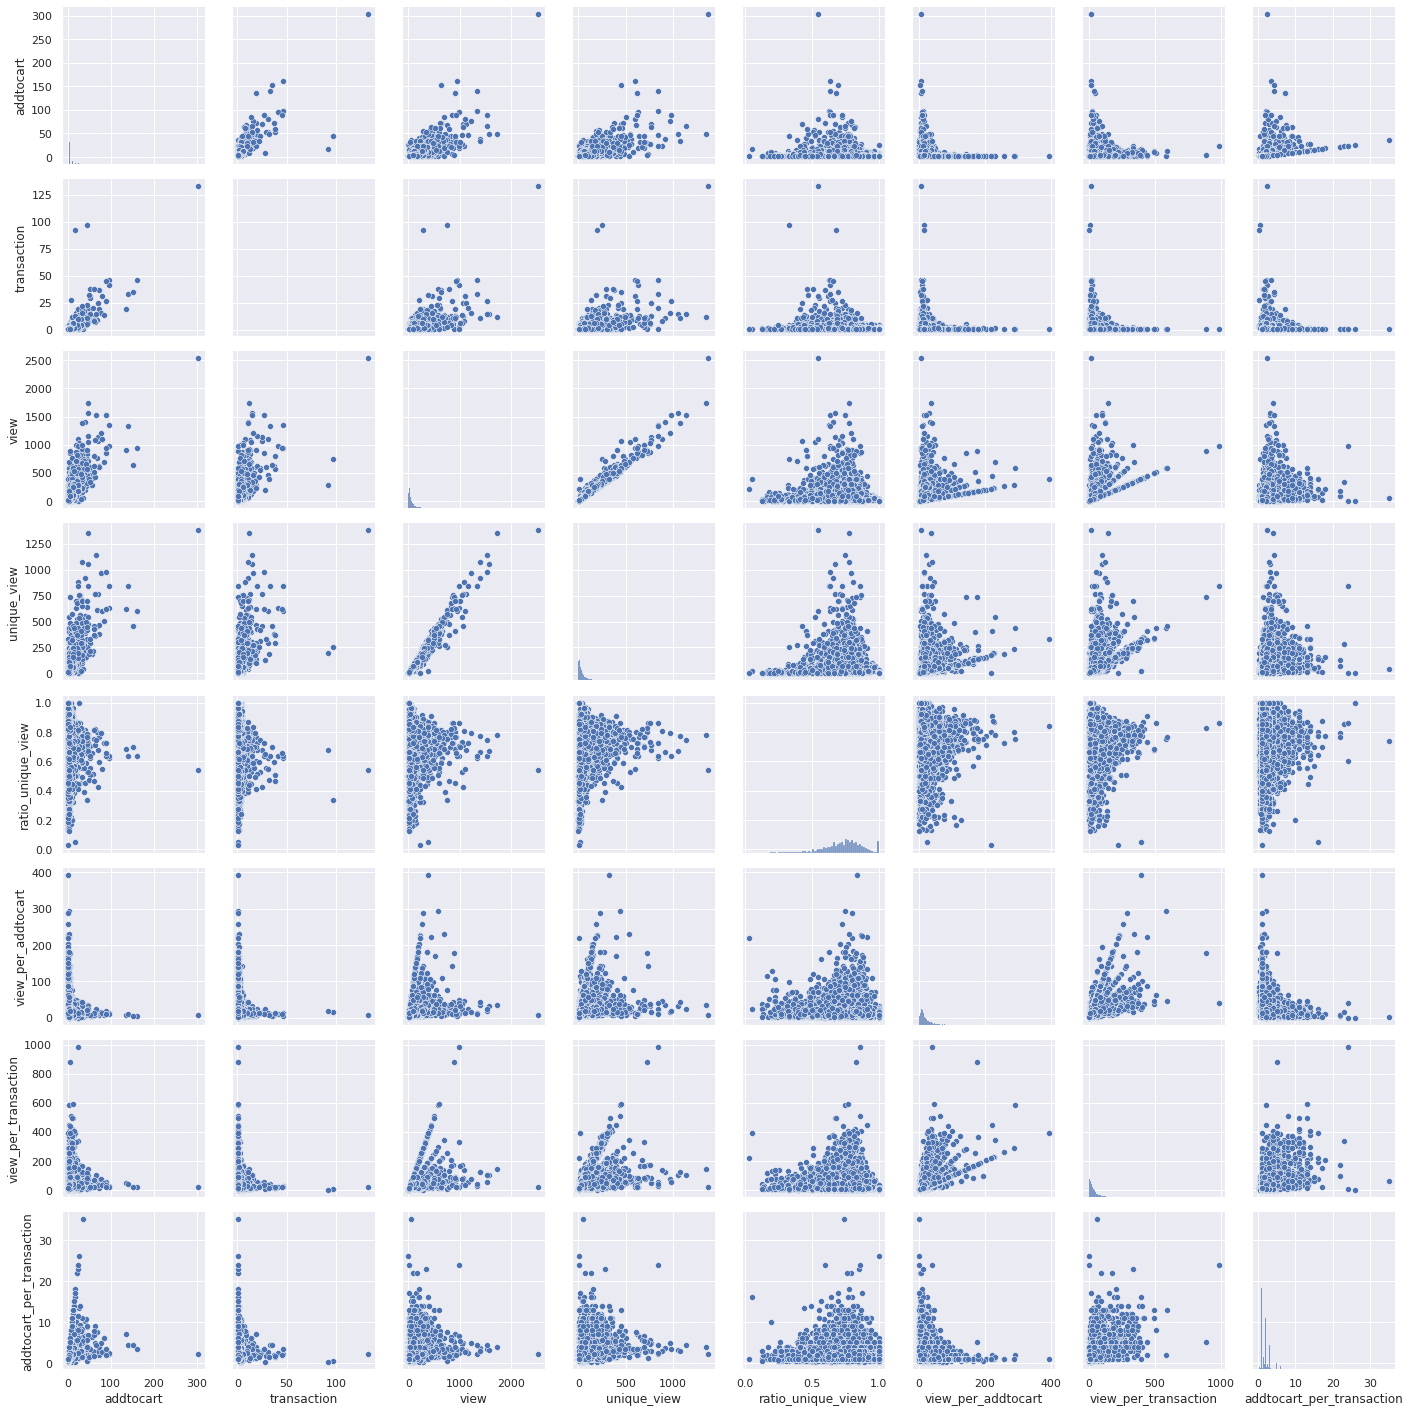

In [164]:
sns.pairplot(events_item)

fig=plt.gcf()
fig.savefig("event_item_pairplot.png", dpi = 300);

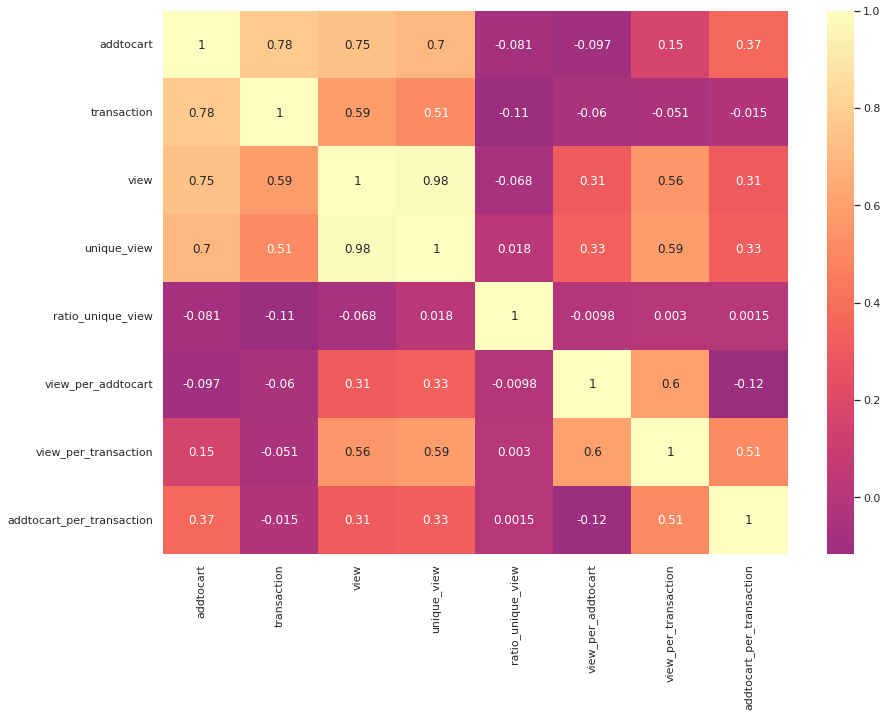

In [165]:
plt.figure(figsize=(14,10))

sns.heatmap(events_item.corr(), center=0, annot=True, cmap='magma')

fig=plt.gcf()
fig.savefig("event_item_heatmap.png", dpi = 300);

**Question 7: Y a-t-il des relations entre les évènements en les regroupant par visiteur ?**

In [166]:
events_visitor=events[['itemid', 'event', 'visitorid']]

events_visitor1= events_visitor.groupby(['visitorid','event']).agg({"itemid": "nunique"}).reset_index()
events_visitor1= events_visitor1.rename(columns={'itemid': 'items_unique'})

events_visitor2=events_visitor.groupby(['visitorid','event']).size().reset_index().rename(columns={0: 'items_count'})

events_visitor=events_visitor1.merge(events_visitor2, on=['event', 'visitorid'])

events_visitor=events_visitor.pivot(index='visitorid', columns='event', values=['items_count', 'items_unique'])

events_visitor=events_visitor.dropna()

events_visitor.columns=['_'.join(col) for col in events_visitor.columns.values]

events_visitor = events_visitor.drop(['items_unique_addtocart','items_unique_transaction'], axis=1)

events_visitor=events_visitor.rename(columns={'items_count_addtocart': 'addtocart',
                            'items_count_transaction': 'transaction',
                            'items_count_view': 'view',
                            'items_unique_view': 'item_count'})

events_visitor.head()

addtocart  transaction  view  item_count
visitorid                                          
172              3.0          2.0  33.0        22.0
186              1.0          1.0   2.0         1.0
264              2.0          2.0   3.0         2.0
419              1.0          1.0   4.0         3.0
539              2.0          1.0   4.0         1.0

In [167]:
events_visitor['concentration_view']=events_visitor.item_count / events_visitor.view

events_visitor['view_per_addtocart']=events_visitor.view / events_visitor.addtocart
events_visitor['view_per_transaction']=events_visitor.view / events_visitor.transaction
events_visitor['addtocart_per_transaction']=events_visitor.addtocart / events_visitor.transaction

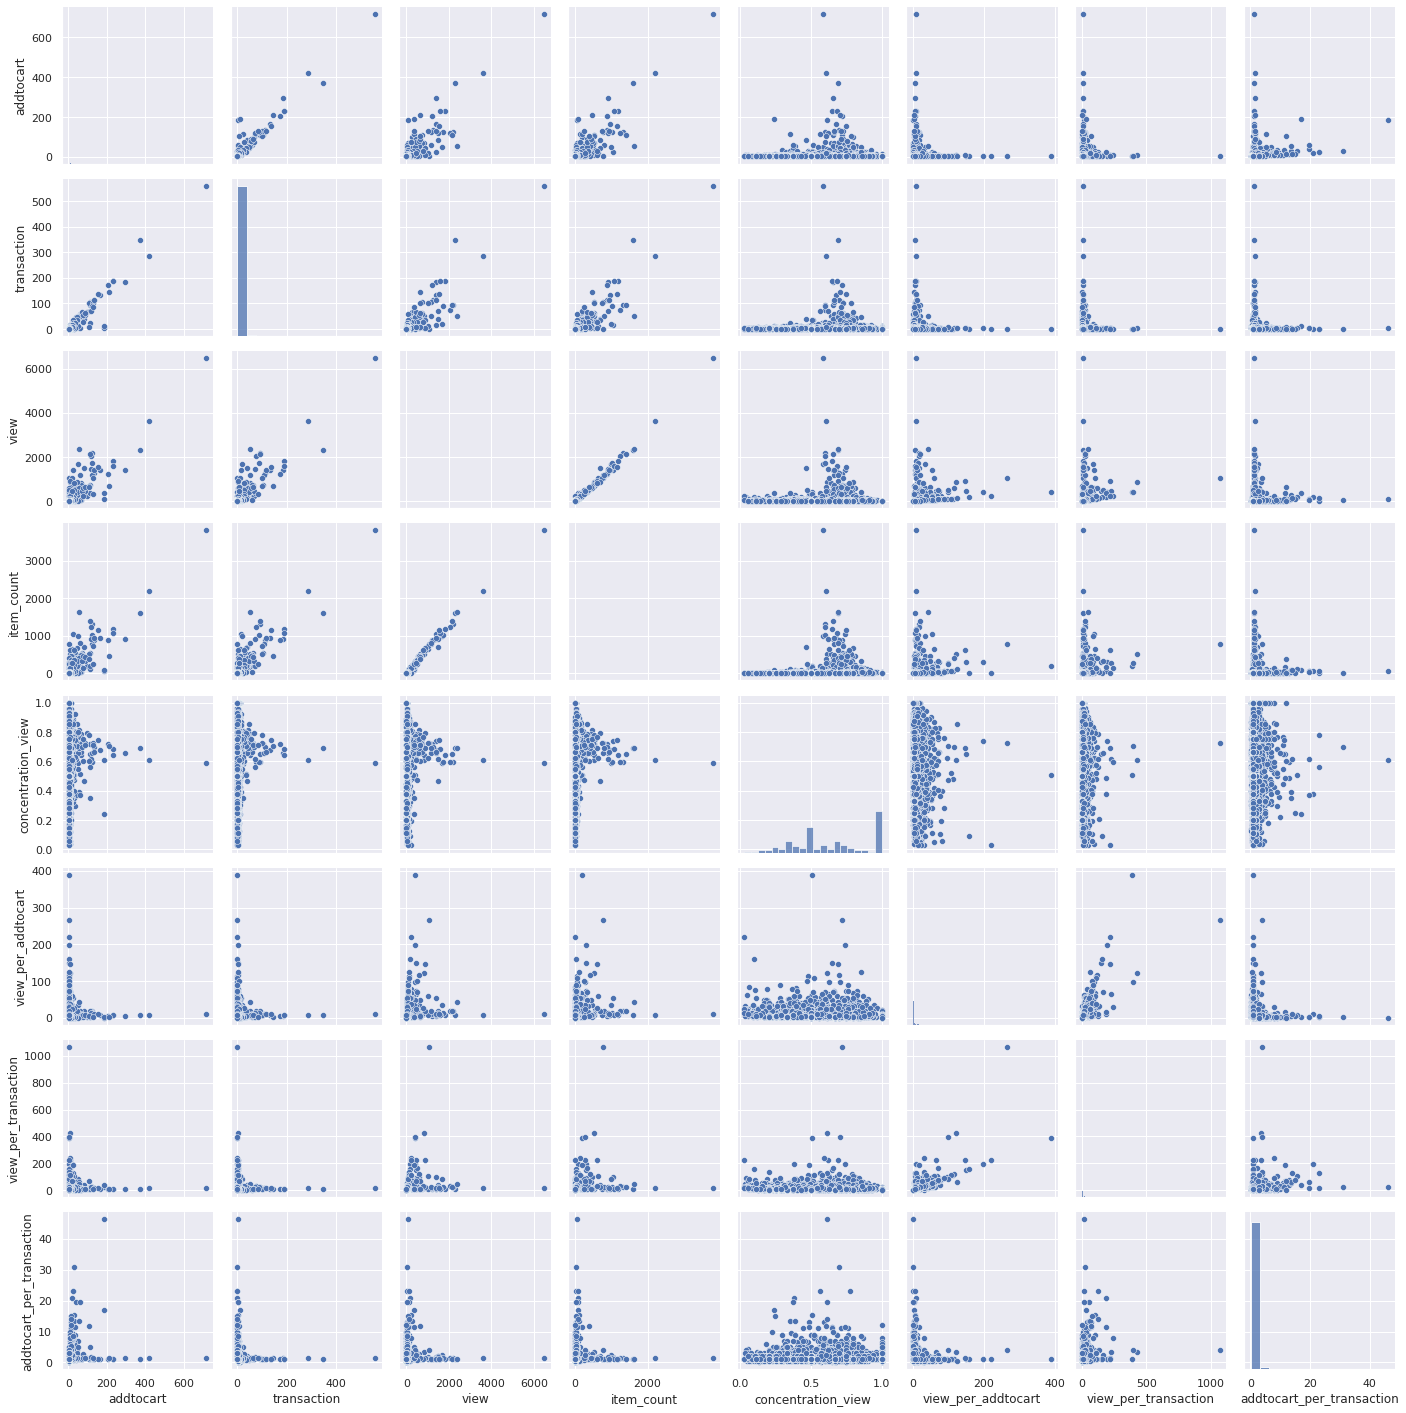

In [168]:
sns.pairplot(events_visitor)

fig=plt.gcf()
fig.savefig("event_visitor_pairplot.png", dpi = 300);

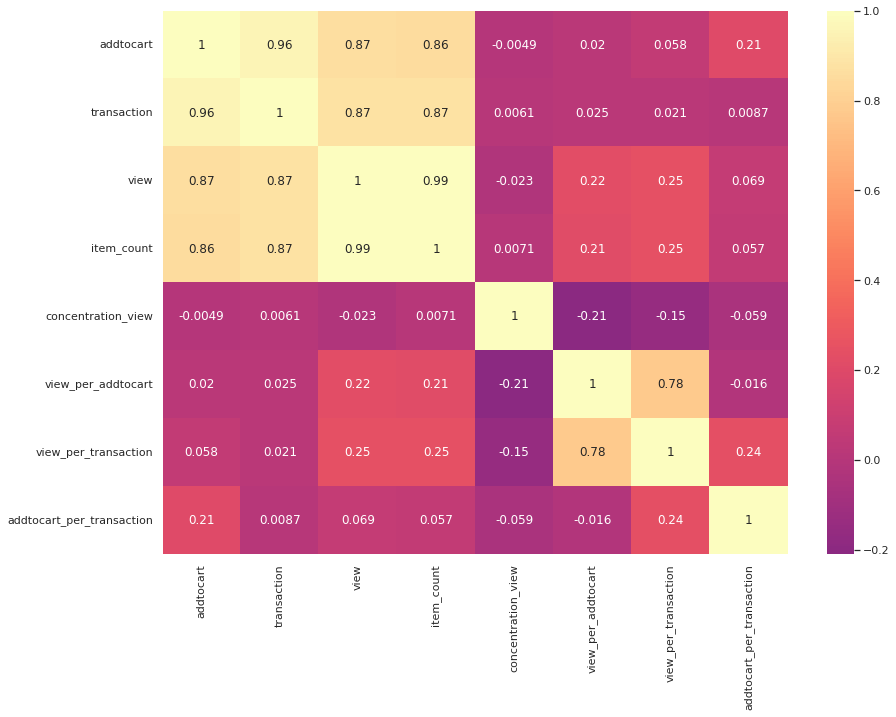

In [169]:
plt.figure(figsize=(14,10))

sns.heatmap(events_visitor.corr(), center=0, annot=True, cmap='magma')

fig=plt.gcf()
fig.savefig("event_visitor_heatmap.png", dpi = 300);

**Question 8: Combien y a-t-il d'objets achetés ensemble ?**

4


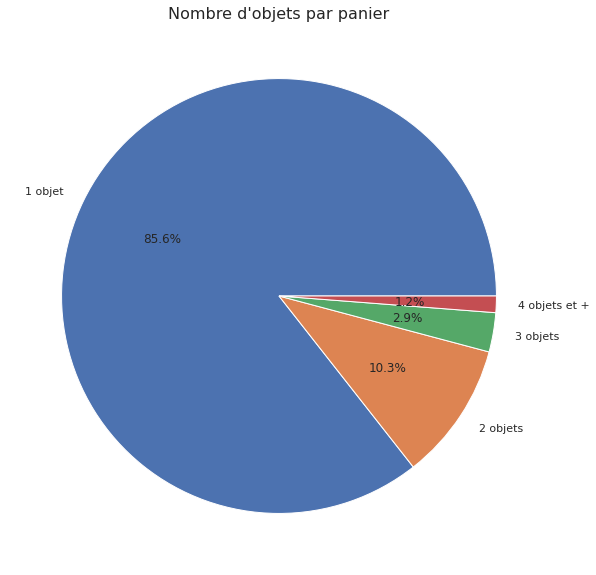

<Figure size 432x288 with 0 Axes>

In [170]:
transact_counts=events[events['event']=='transaction']['transactionid'].value_counts().value_counts()

sizes=list(transact_counts.iloc[:3].values)
sizes.append(transact_counts.iloc[4:].sum())

print(len(sizes))
labels = ['1 objet', '2 objets','3 objets','4 objets et +']


plt.figure(figsize=(14,10))

plt.pie(x=sizes, labels=labels, autopct='%1.1f%%', startangle=0) 

plt.title("Nombre d'objets par panier", fontsize=16)
plt.show()

fig=plt.gcf()
fig.savefig("nb_item_basket.png", dpi = 300);

La grande majorité des paniers ne sont constitués que d'un produit.

Pour les autres paniers, on peut chercher quels sont les produits les plus souvent achetés ensemble.

**Question 9: Quelles sont les paires d'objets achetés ensemble ?**

In [171]:
transactions=events[events['event']=='transaction']

transactions=transactions.drop_duplicates(subset=['visitorid', 'itemid'])
paniers = transactions.groupby(['visitorid', 'transactionid']).agg({'itemid': lambda x: sorted(x.tolist())}).reset_index()

paniers.head()

visitorid  transactionid            itemid
0        172         9725.0   [10034, 465522]
1        186         8726.0           [49029]
2        264         8445.0  [161949, 459835]
3        419        16455.0           [19278]
4        539        14778.0           [94371]

A partir de ces paniers représentés sous forme de liste, on extrait tous les couples possibles à l'aide de **itertools.combinations()**.

In [172]:
combinations_list = []
for value in paniers['itemid']:
    combinations = list(itertools.combinations(value, 2))
    combinations_list.append(combinations)
    
combination_counts = pd.Series(combinations_list).explode().reset_index(drop=True)

combination_counts=combination_counts.dropna()

In [173]:
combination_counts.value_counts().head(20)

(213834, 445351)    35
(171878, 461686)     9
(10572, 461686)      8
(218794, 461686)     7
(32581, 461686)      7
(301721, 369158)     6
(78268, 449391)      6
(46130, 213834)      4
(124081, 461686)     4
(28789, 132633)      4
(54698, 449391)      4
(274435, 369447)     3
(119736, 186702)     3
(167827, 387504)     3
(387504, 390167)     3
(132633, 284414)     3
(75392, 461686)      3
(178358, 236158)     3
(216266, 301721)     3
(167827, 390167)     3
dtype: int64

### Fichiers item

In [174]:
print("La taille de item_properties1 est:", item_properties1.shape)
item_properties1.head()

La taille de item_properties1 est: (10999999, 4)


timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513

In [175]:
item_properties1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB


In [176]:
print("La taille de item_properties2 est:", item_properties2.shape)
item_properties2.head()

La taille de item_properties2 est: (9254926, 4)


timestamp  itemid property            value
0  1433041200000  183478      561           769062
1  1439694000000  132256      976  n26.400 1135780
2  1435460400000  420307      921  1149317 1257525
3  1431831600000  403324      917          1204143
4  1435460400000  230701      521           769062

In [177]:
item_properties2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9254926 entries, 0 to 9254925
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  object
 1   itemid     object
 2   property   object
 3   value      object
dtypes: object(4)
memory usage: 282.4+ MB


La taille des deux fichiers est importante. Les valeurs de la colonne "property" ont été hashées, hormis 'categoryid' et 'available'. On peut commencer par élaguer le dataset en ne gardant que les lignes contenant ces deux valeurs.

In [178]:
item_properties1=item_properties1[(item_properties1['property']=="categoryid")|(item_properties1['property']=="available")]
item_properties2=item_properties2[(item_properties2['property']=="categoryid")|(item_properties2['property']=="available")]

print("La taille de item_properties1 est désormais:", item_properties1.shape)
print("La taille de item_properties2 est désormais:", item_properties2.shape)


La taille de item_properties1 est désormais: (1243692, 4)
La taille de item_properties2 est désormais: (1045253, 4)


On peut désormais regrouper les deux fichiers.

In [179]:
item_properties=pd.concat([item_properties1, item_properties2], axis=0)

print("La taille de item_properties est:", item_properties.shape)

La taille de item_properties est: (2288945, 4)


In [180]:
item_properties['property'].value_counts()

available     1501748
categoryid     787197
Name: property, dtype: int64

In [181]:
item_properties[item_properties.property=='available']['value'].value_counts()

0    862042
1    639706
Name: value, dtype: int64

La catégorie 'available' ne renseigne que sur la disponibilité du produit (1 pour disponible, 0 pour indisponible).

Dans la perspective d'une étude du comportement des usagers du site, cette catégorie n'est pas utile.

In [182]:
item_properties=item_properties[(item_properties['property']=="categoryid")]

item_properties=item_properties.drop('property', axis=1)

item_properties=item_properties.rename(columns={'value' : 'categoryid'})

In [183]:
item_properties=item_properties.astype('int64') #On convertit le type 'object' en 'int'

Comme avec le DataFrame 'events', on trie les lignes suivant la colonne 'timestamp'.

In [184]:
item_properties=item_properties.sort_values(by='timestamp')

On peut supprimer les doublons.

In [185]:
item_properties=item_properties.drop_duplicates(subset=['itemid', 'categoryid'])

Pour la suite, on utilisera ce dataframe. Pour ne pas avoir à tout recalculer, on le sauvegarde dans un fichier csv.

In [186]:
item_properties.to_csv("item_properties.csv")

On peut regrouper les dataframes 'events' et 'item_properties'. S'il est possible de faire une réunion exacte sur la colonne 'itemid', on souhaite aussi que les valeurs de la colonne 'timestamp' soient les plus proches possibles.

In [187]:
item_properties=pd.read_csv("item_properties.csv", index_col=0)

In [188]:
item_properties.head()

timestamp  itemid  categoryid
10162751  1431226800000  421199        1051
6175844   1431226800000   43127        1355
10137170  1431226800000   71311         518
3081354   1431226800000  360278         374
3081414   1431226800000  350035        1070

In [189]:
events=pd.merge_asof(events, item_properties, on='timestamp', by='itemid', direction='nearest')

In [190]:
events.head()

timestamp  visitorid      event  ...  day  weekday_name categoryid
0  1430622004384     693516  addtocart  ...    3        Sunday     1130.0
1  1430622011289     829044       view  ...    3        Sunday      463.0
2  1430622013048     652699       view  ...    3        Sunday        NaN
3  1430622024154    1125936       view  ...    3        Sunday     1628.0
4  1430622026228     693516       view  ...    3        Sunday     1130.0

[5 rows x 13 columns]

On peut aussi regrouper 'category' et le nouveau dataframe en s'appuyant sur la colonne 'categoryid'.

In [191]:
events=events.merge(category, on = 'categoryid')

events.head()

timestamp  visitorid      event  ...  weekday_name  categoryid parentid
0  1430622004384     693516  addtocart  ...        Sunday      1130.0   1323.0
1  1430622026228     693516       view  ...        Sunday      1130.0   1323.0
2  1430622029427     693516  addtocart  ...        Sunday      1130.0   1323.0
3  1430629656175     640328       view  ...        Sunday      1130.0   1323.0
4  1430695702554    1265708       view  ...        Sunday      1130.0   1323.0

[5 rows x 14 columns]

Dernière étape du preprocessing, on peut enlever les colonnes 'date' et 'day'.

In [192]:
events=events.drop(['date', 'day', 'weekday_name'], axis=1)

On peut sauvegarder ce fichier pour ne pas avoir à le recalculer.

In [193]:
events.to_csv("new_events.csv")

In [194]:
events=pd.read_csv("new_events.csv", index_col=0)

events.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


timestamp  visitorid      event  ...  day_of_year  categoryid  parentid
0  1430622004384     693516  addtocart  ...   2015-05-03      1130.0    1323.0
1  1430622026228     693516       view  ...   2015-05-03      1130.0    1323.0
2  1430622029427     693516  addtocart  ...   2015-05-03      1130.0    1323.0
3  1430629656175     640328       view  ...   2015-05-03      1130.0    1323.0
4  1430695702554    1265708       view  ...   2015-05-03      1130.0    1323.0

[5 rows x 11 columns]

## **Modélisation**

### **Q1: Peut-on prédire le nombre d'évènements suivant une analyse temporelle ?**

On souhaite étudier les séries temporelles donnant le nombre de vues, mises au panier et transactions par journée.

In [195]:
events_day=events[['day_of_year', 'event', 'visitorid']]

events_day=events_day.groupby(['day_of_year','event']).size().reset_index()

events_day=events_day.rename(columns={0: 'visitors_count'})

events_day=events_day.pivot(index='day_of_year', columns='event', values='visitors_count').reset_index()

events_day['day_of_year']=pd.to_datetime(events_day['day_of_year'])

events_day=events_day.set_index('day_of_year')

events_day.head()

event        addtocart  transaction   view
day_of_year                               
2015-05-03         287           80  12058
2015-05-04         569          148  16919
2015-05-05         537          221  20167
2015-05-06         633          256  20908
2015-05-07         555          207  20206

#### Analyse temporelle du nombre de vues

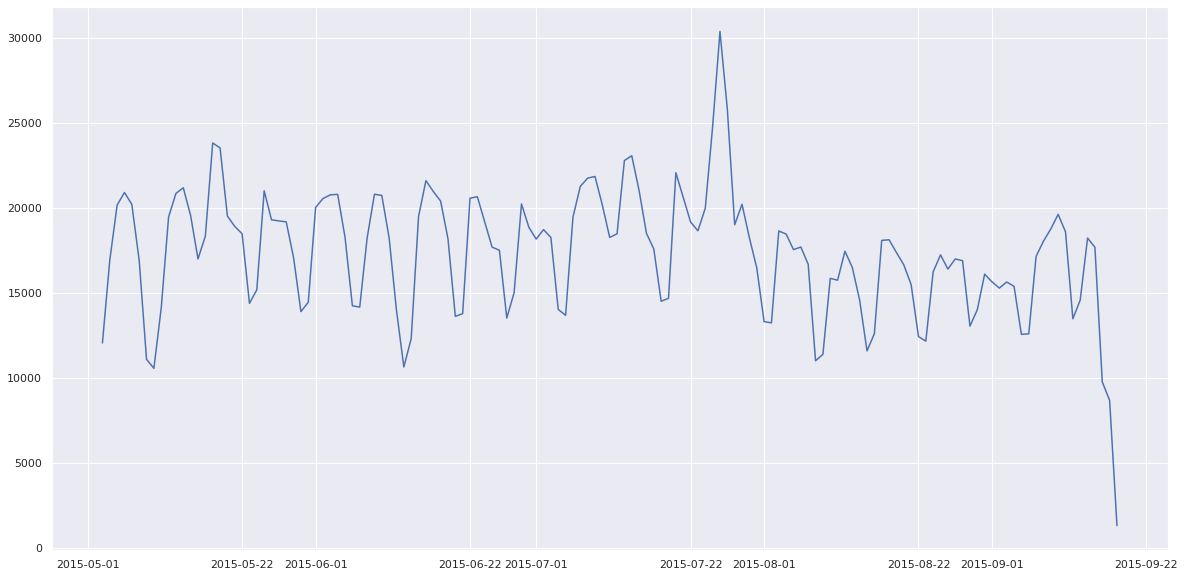

In [196]:
view_day=events_day['view']

plt.figure(figsize=(20,10))
plt.plot(view_day)
plt.show();

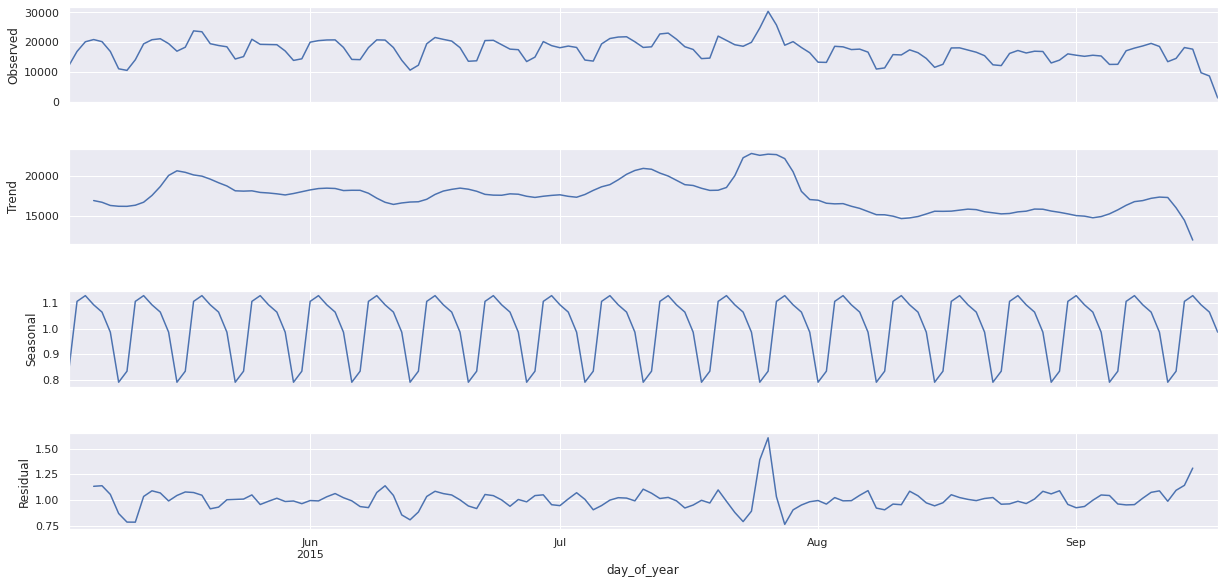

In [197]:
res= seasonal_decompose(view_day, model='multiplicative')

fig=res.plot()
fig.set_size_inches(20, 10)
plt.show();

A vue d'oeil, le résidu est un bruit blanc. Le modèle multiplicatif semble adapté. 

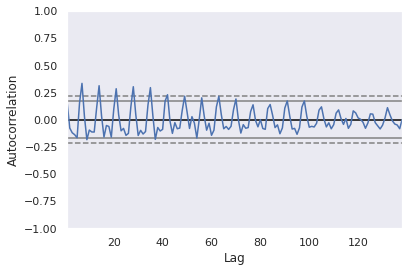

In [198]:
view_daylog=np.log(view_day)

view_daylog1=view_daylog.diff().dropna()

pd.plotting.autocorrelation_plot(view_daylog1);

On remarque une décroissance vers 0 de l'ACF. Il semble y avoir une période 7.

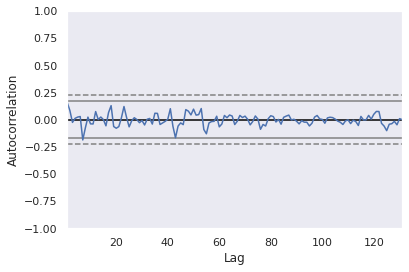

In [199]:
view_daylog2=view_daylog1.diff(periods=7).dropna()

pd.plotting.autocorrelation_plot(view_daylog2);

On cherche le modèle SARIMA le plus adapté en utilisant les graphiques ACF et PACF.

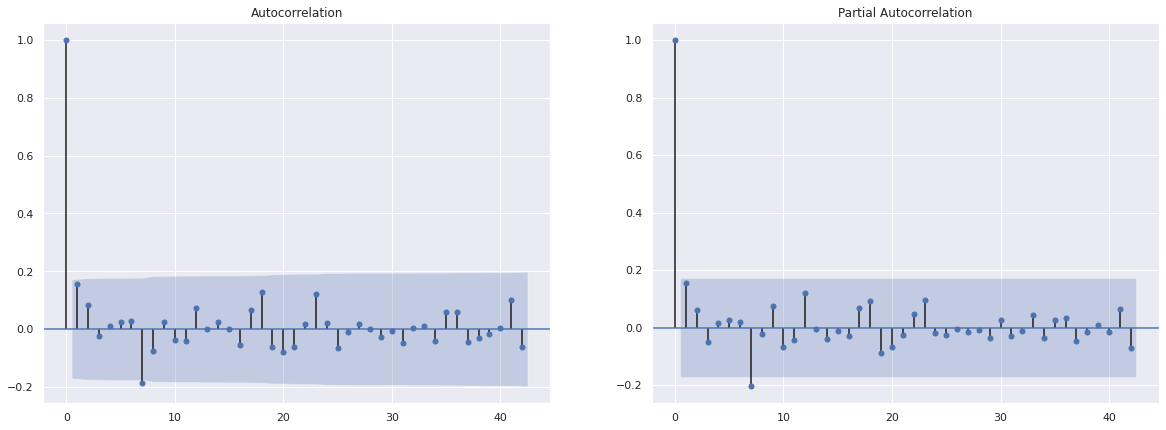

In [200]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(20,7))

plot_acf(view_daylog2, lags=42, ax=ax1) 

plot_pacf(view_daylog2, lags=42, ax=ax2, method="ywm")

plt.show()

Il y a décroissance globale de l'ACF et du PACF, avec une coupure des pics saisonniers après une période de 7 jours.

On teste un modèle SARIMA(1,1,1)(1,1,1)7.

In [201]:
model=sm.tsa.SARIMAX(view_daylog, order=(1,1,1), seasonal_order=(1,1,1,7))

sarima_view= model.fit()

print(sarima_view.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                              view   No. Observations:                  139
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                  28.043
Date:                           Thu, 02 Dec 2021   AIC                            -46.086
Time:                                   07:18:40   BIC                            -31.710
Sample:                               05-03-2015   HQIC                           -40.244
                                    - 09-18-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9638      0.182      5.295      0.000       0.607       1.321
ma.L1         -0.5915      0.246     -2.403

Le coefficient ar.S.L7 est non significatif. On l'enlève.

In [202]:
model=sm.tsa.SARIMAX(view_daylog, order=(1,1,1), seasonal_order=(0,1,1,7))

sarima_view= model.fit()

print(sarima_view.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                              view   No. Observations:                  139
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                  27.943
Date:                           Thu, 02 Dec 2021   AIC                            -47.887
Time:                                   07:18:41   BIC                            -36.386
Sample:                               05-03-2015   HQIC                           -43.214
                                    - 09-18-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9395      0.172      5.458      0.000       0.602       1.277
ma.L1         -0.5661      0.253     -2.242

Le modèle semble significatif, à l'exception du test de Jarque-Bera. Les résidus ne suivent pas une loi normale.

In [203]:
pred_view=np.exp(sarima_view.predict(1,139))

pred_view=pred_view.reset_index().set_index(view_day.index)[0]

pred_view.head(10)

day_of_year
2015-05-03    1.205800e+04
2015-05-04    1.691900e+04
2015-05-05    2.016700e+04
2015-05-06    2.090800e+04
2015-05-07    2.020600e+04
2015-05-08    1.691400e+04
2015-05-09    1.218220e+06
2015-05-10    1.482271e+04
2015-05-11    1.649971e+04
2015-05-12    2.097898e+04
Name: 0, dtype: float64

In [204]:
view_day.head(10)

day_of_year
2015-05-03    12058
2015-05-04    16919
2015-05-05    20167
2015-05-06    20908
2015-05-07    20206
2015-05-08    16914
2015-05-09    11094
2015-05-10    10564
2015-05-11    14122
2015-05-12    19465
Name: view, dtype: int64

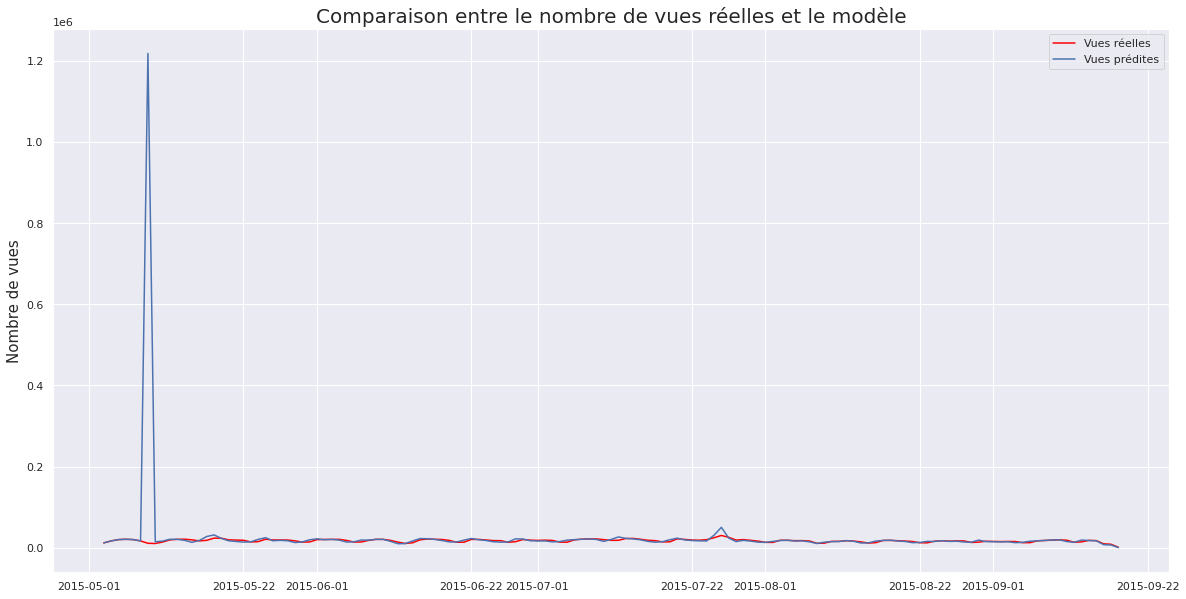

In [205]:
plt.figure(figsize=(20,10))
plt.plot(view_day, color='red', label='Vues réelles')
plt.plot(pred_view, label='Vues prédites')
plt.title("Comparaison entre le nombre de vues réelles et le modèle", fontsize=20)
plt.ylabel("Nombre de vues", fontsize=15)
plt.legend()
plt.show();

Le modèle semble fonctionner engénéral mais produit une valeur incohérente pour la date '2015-05-09'. On peut la modifier.

In [206]:
pred_view['2015-05-09']=view_day['2015-05-09']

pred_view.head(10)

day_of_year
2015-05-03    12058.001642
2015-05-04    16919.002021
2015-05-05    20167.001948
2015-05-06    20908.001443
2015-05-07    20206.000797
2015-05-08    16914.000103
2015-05-09    11094.000000
2015-05-10    14822.712163
2015-05-11    16499.709321
2015-05-12    20978.981150
Name: 0, dtype: float64

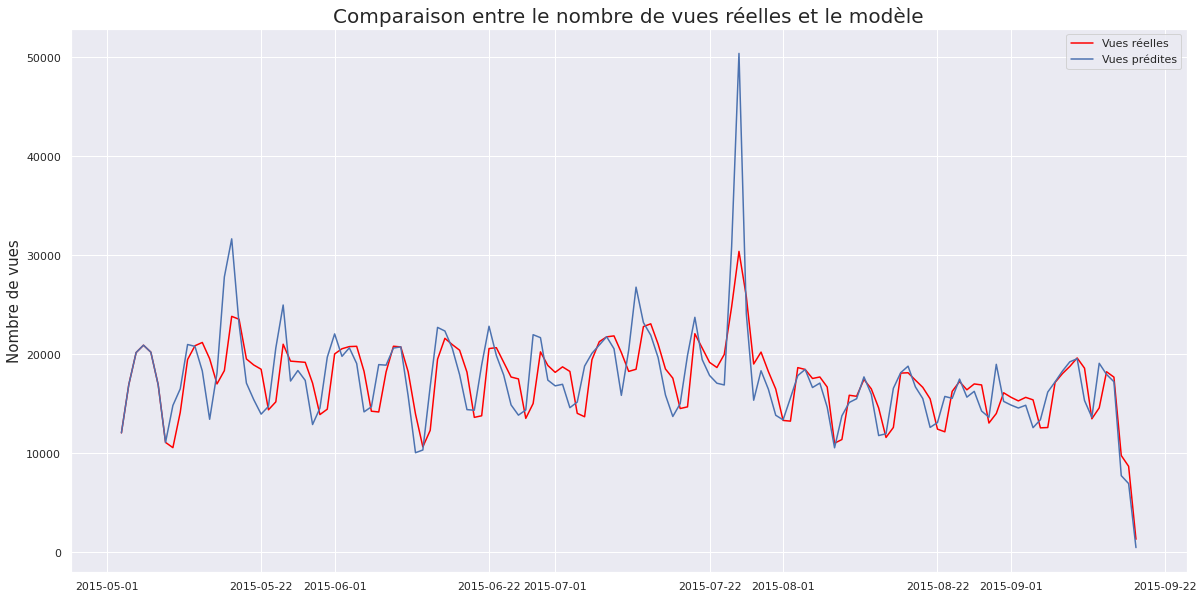

<Figure size 432x288 with 0 Axes>

In [207]:
plt.figure(figsize=(20,10))
plt.plot(view_day, color='red', label='Vues réelles')
plt.plot(pred_view, label='Vues prédites')
plt.title("Comparaison entre le nombre de vues réelles et le modèle", fontsize=20)
plt.ylabel("Nombre de vues", fontsize=15)
plt.legend()
plt.show()

fig=plt.gcf()
fig.savefig("time_series_view.png");

On remarque un phénomène particulier le 25 juillet. Le pic de vue est exacerbé par le modèle.

In [208]:
diff= pred_view- view_day

print("Erreur relative:", diff.mean()/view_day.mean())
print("Ecart absolu moyen:", abs(diff).mean())
print("Ecart quadratique moyen:", (diff**2).mean()**0.5)

Erreur relative: 0.009900254537817867
Ecart absolu moyen: 2086.6143088335525
Ecart quadratique moyen: 3207.9641589392536


Le nombre de vue dépassant les 10000 par jour, l'écart absolu moyen est correct. La présence d'outlier augmente l'écart quadratique moyen.

Le modèle sur-évalue très légèrement les valeurs exactes.

#### Analyse temporelle du nombre de mise au panier

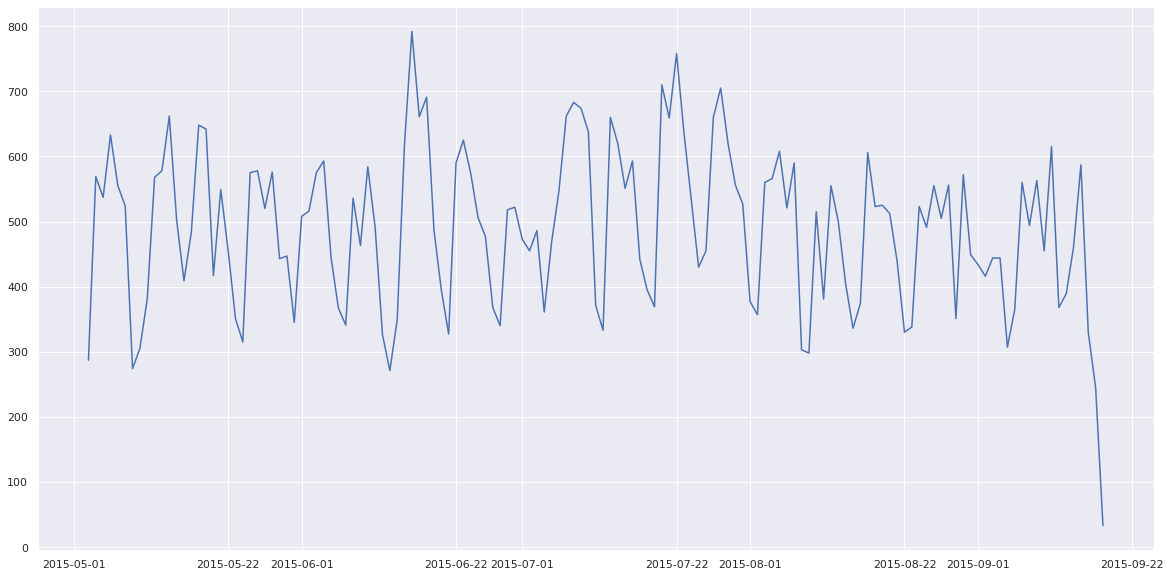

In [209]:
addtocart_day=events_day['addtocart']

plt.figure(figsize=(20,10))
plt.plot(addtocart_day)
plt.show();

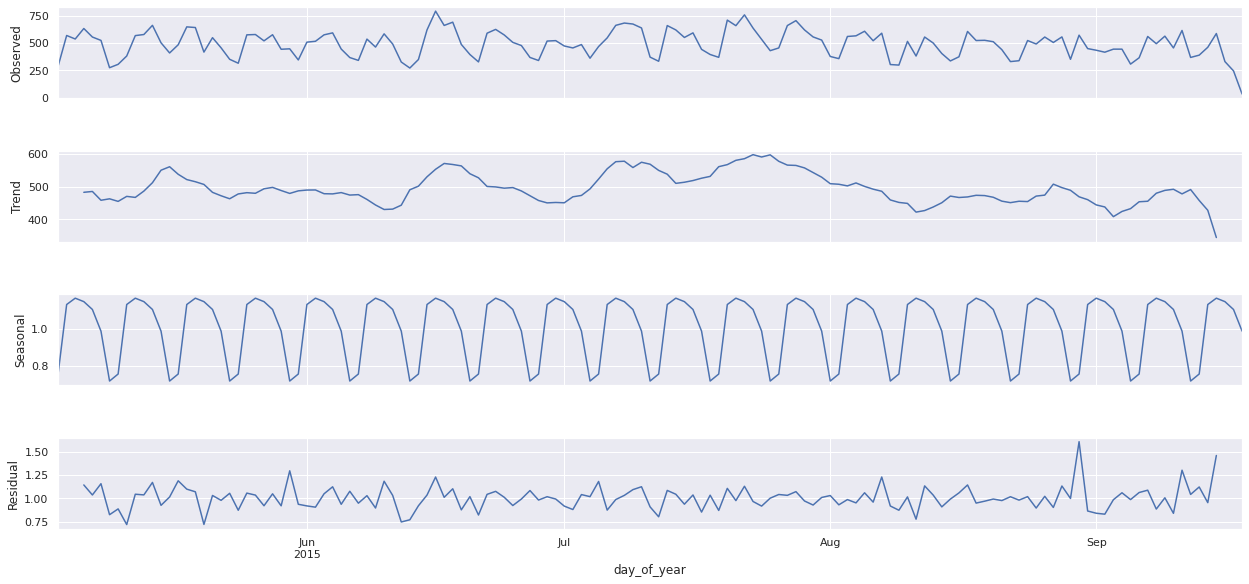

In [210]:
res= seasonal_decompose(addtocart_day, model='multiplicative')

fig=res.plot()
fig.set_size_inches(20, 10)
plt.show();

A vue d'oeil, le résidu est un bruit blanc. Le modèle multiplicatif semble adapté. 

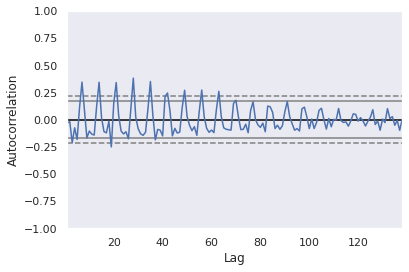

In [211]:
addtocart_daylog=np.log(addtocart_day)

addtocart_daylog1=addtocart_daylog.diff().dropna()

pd.plotting.autocorrelation_plot(addtocart_daylog1);

On remarque une décroissance vers 0 de l'ACF. Il semble y avoir une période 7.

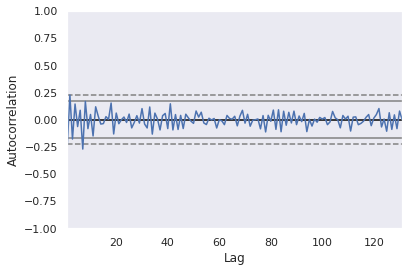

In [212]:
addtocart_daylog2=addtocart_daylog1.diff(periods=7).dropna()

pd.plotting.autocorrelation_plot(addtocart_daylog2);

On cherche le modèle SARIMA le plus adapté en utilisant les graphiques ACF et PACF.

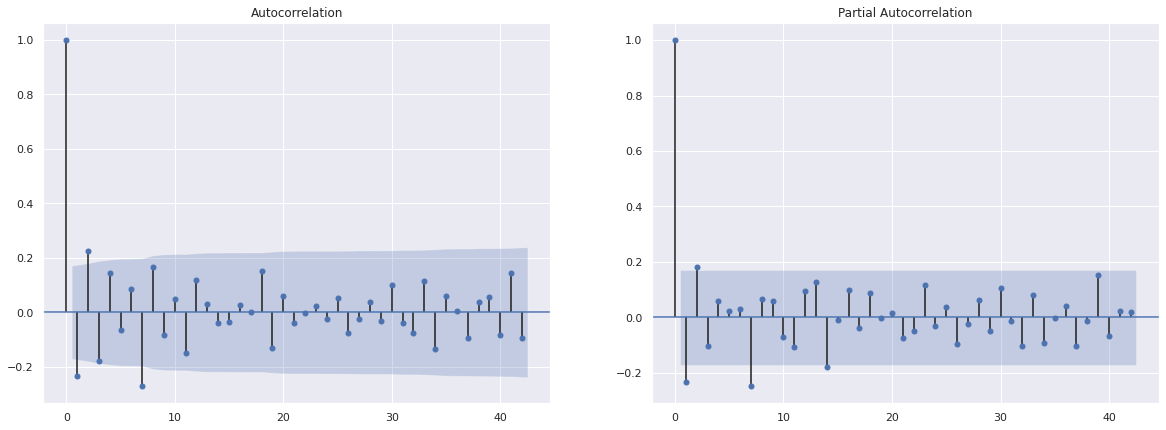

In [213]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(20,7))

plot_acf(addtocart_daylog2, lags=42, ax=ax1) 

plot_pacf(addtocart_daylog2, lags=42, ax=ax2, method="ywm")

plt.show()

Il y a décroissance globale de l'ACF et du PACF, avec une coupure des pics saisonniers après une période de 7 jours.

On teste un modèle SARIMA(1,1,1)(1,1,1)7.

In [214]:
model=sm.tsa.SARIMAX(addtocart_daylog, order=(1,1,1), seasonal_order=(1,1,1,7))

sarima_addtocart= model.fit()

print(sarima_addtocart.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                         addtocart   No. Observations:                  139
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                  -2.960
Date:                           Thu, 02 Dec 2021   AIC                             15.919
Time:                                   07:18:47   BIC                             30.295
Sample:                               05-03-2015   HQIC                            21.761
                                    - 09-18-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8611      0.190     -4.524      0.000      -1.234      -0.488
ma.L1          0.5859      0.255      2.294

Les coefficients ar.S.L7 et ma.S.L7 sont non significatifs. On les enlève.

In [215]:
model=sm.tsa.SARIMAX(addtocart_daylog, order=(1,1,1), seasonal_order=(0,1,0,7))

sarima_addtocart= model.fit()

print(sarima_addtocart.summary())

                                 Statespace Model Results                                
Dep. Variable:                         addtocart   No. Observations:                  139
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 7)   Log Likelihood                 -22.114
Date:                           Thu, 02 Dec 2021   AIC                             50.228
Time:                                   07:18:47   BIC                             58.854
Sample:                               05-03-2015   HQIC                            53.733
                                    - 09-18-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9700      0.056    -17.418      0.000      -1.079      -0.861
ma.L1          0.7557      0.130      5.817

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Le modèle semble significatif, à l'exception du test de Jarque-Bera. Les résidus ne suivent pas une loi normale.

In [216]:
pred_addtocart=np.exp(sarima_addtocart.predict(1,139))

pred_addtocart=pred_addtocart.reset_index().set_index(addtocart_day.index)[0]

pred_addtocart.head(10)

day_of_year
2015-05-03     286.999936
2015-05-04     569.000092
2015-05-05     536.999918
2015-05-06     633.000086
2015-05-07     554.999933
2015-05-08     524.000064
2015-05-09    4641.854731
2015-05-10     604.686605
2015-05-11     462.439814
2015-05-12     486.598185
Name: 0, dtype: float64

In [217]:
addtocart_day.head(10)

day_of_year
2015-05-03    287
2015-05-04    569
2015-05-05    537
2015-05-06    633
2015-05-07    555
2015-05-08    524
2015-05-09    274
2015-05-10    305
2015-05-11    381
2015-05-12    568
Name: addtocart, dtype: int64

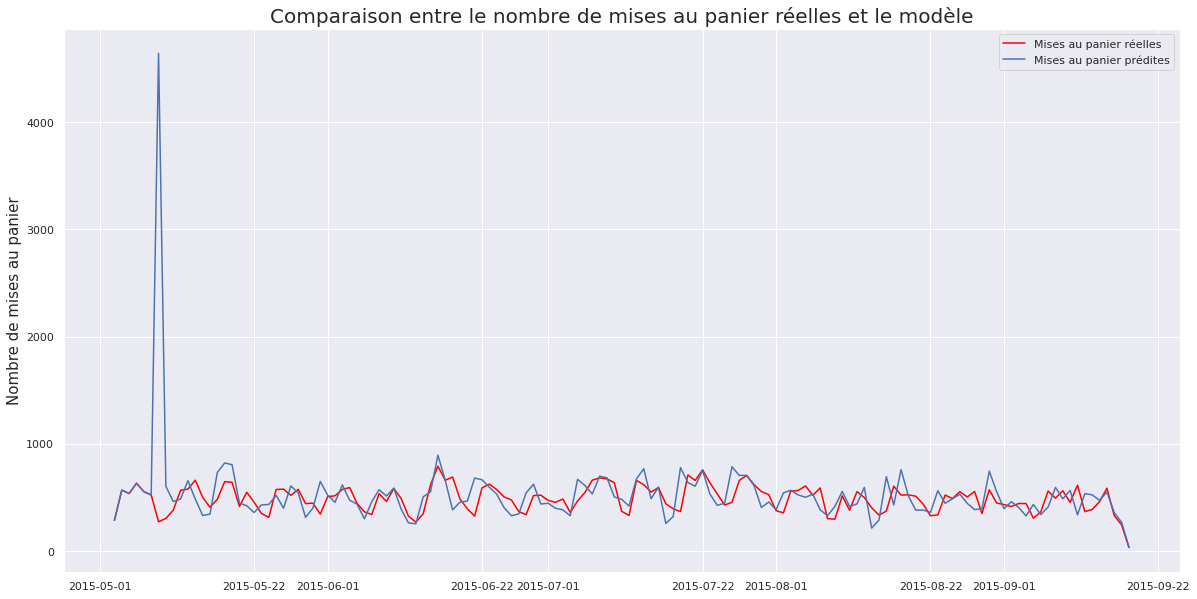

In [218]:
plt.figure(figsize=(20,10))
plt.plot(addtocart_day, color='red', label='Mises au panier réelles')
plt.plot(pred_addtocart, label='Mises au panier prédites')
plt.title("Comparaison entre le nombre de mises au panier réelles et le modèle", fontsize=20)
plt.ylabel("Nombre de mises au panier", fontsize=15)
plt.legend()
plt.show();

Le modèle produit une valeur incohérente pour la date '2015-05-09'. On peut la modifier.

In [219]:
pred_addtocart['2015-05-09']=addtocart_day['2015-05-09']

pred_addtocart.head(10)

day_of_year
2015-05-03    286.999936
2015-05-04    569.000092
2015-05-05    536.999918
2015-05-06    633.000086
2015-05-07    554.999933
2015-05-08    524.000064
2015-05-09    274.000000
2015-05-10    604.686605
2015-05-11    462.439814
2015-05-12    486.598185
Name: 0, dtype: float64

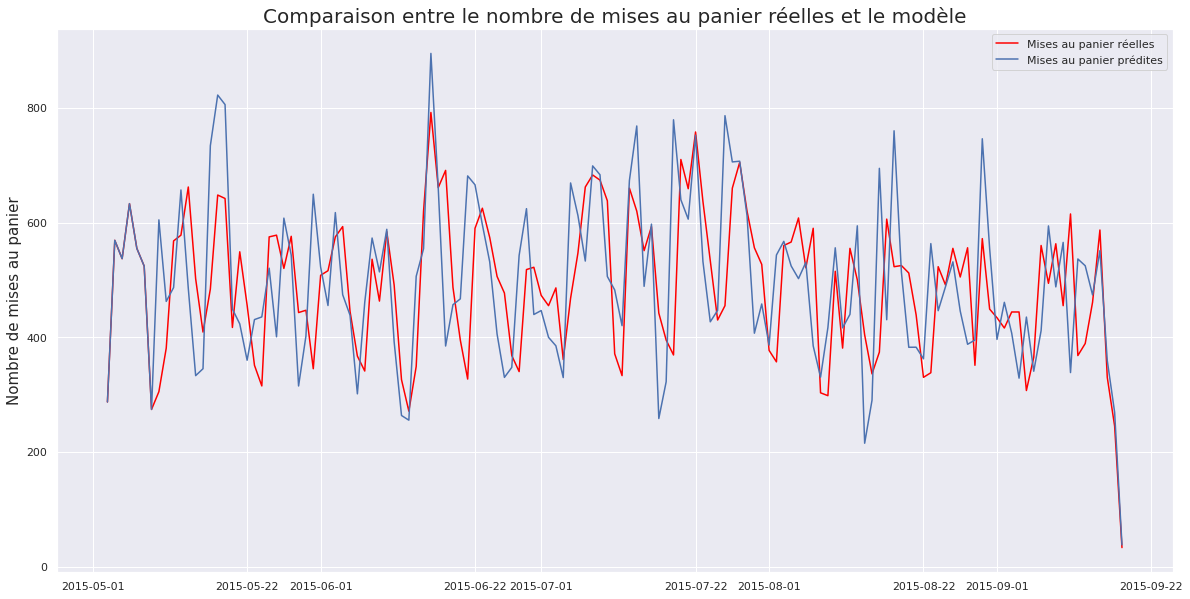

In [220]:
plt.figure(figsize=(20,10))
plt.plot(addtocart_day, color='red', label='Mises au panier réelles')
plt.plot(pred_addtocart, label='Mises au panier prédites')
plt.title("Comparaison entre le nombre de mises au panier réelles et le modèle", fontsize=20)
plt.ylabel("Nombre de mises au panier", fontsize=15)
plt.legend()
plt.show();

In [221]:
diff= pred_addtocart- addtocart_day

print("Erreur relative:", diff.mean()/addtocart_day.mean())
print("Ecart absolu moyen:", abs(diff).mean())
print("Ecart quadratique moyen:", (diff**2).mean()**0.5)

Erreur relative: 0.014353981102642488
Ecart absolu moyen: 92.2837407168067
Ecart quadratique moyen: 124.52554580332325


Le nombre de mise au panier avoisinant les 500 par jour, l'écart absolu moyen est correct.

Le modèle sur-évalue très légèrement les valeurs exactes.

#### Analyse temporelle du nombre de transactions

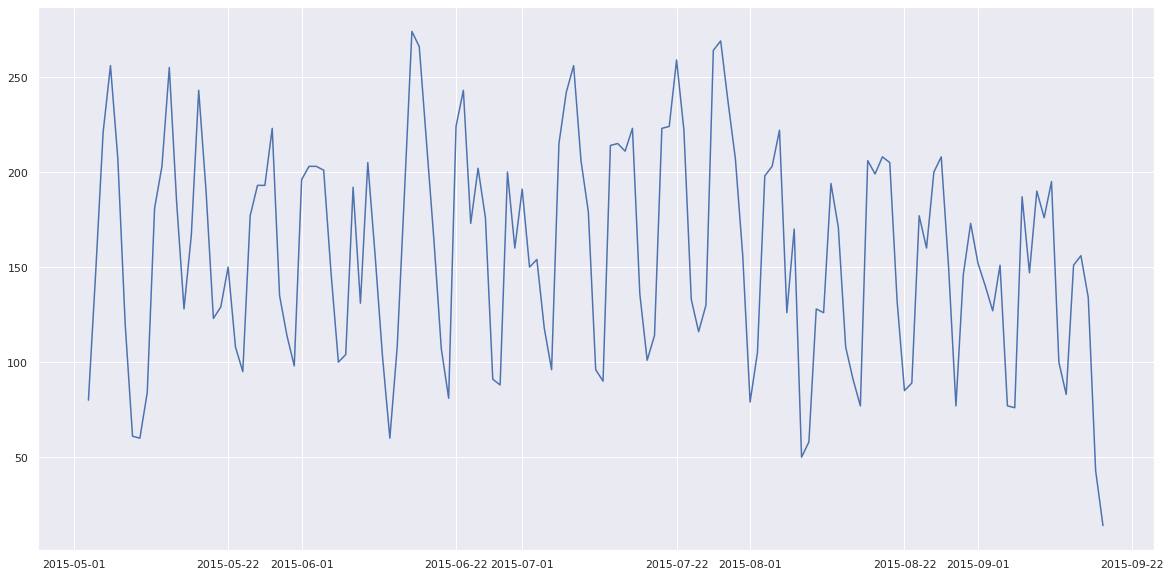

In [222]:
trans_day=events_day['transaction']

plt.figure(figsize=(20,10))
plt.plot(trans_day)
plt.show();

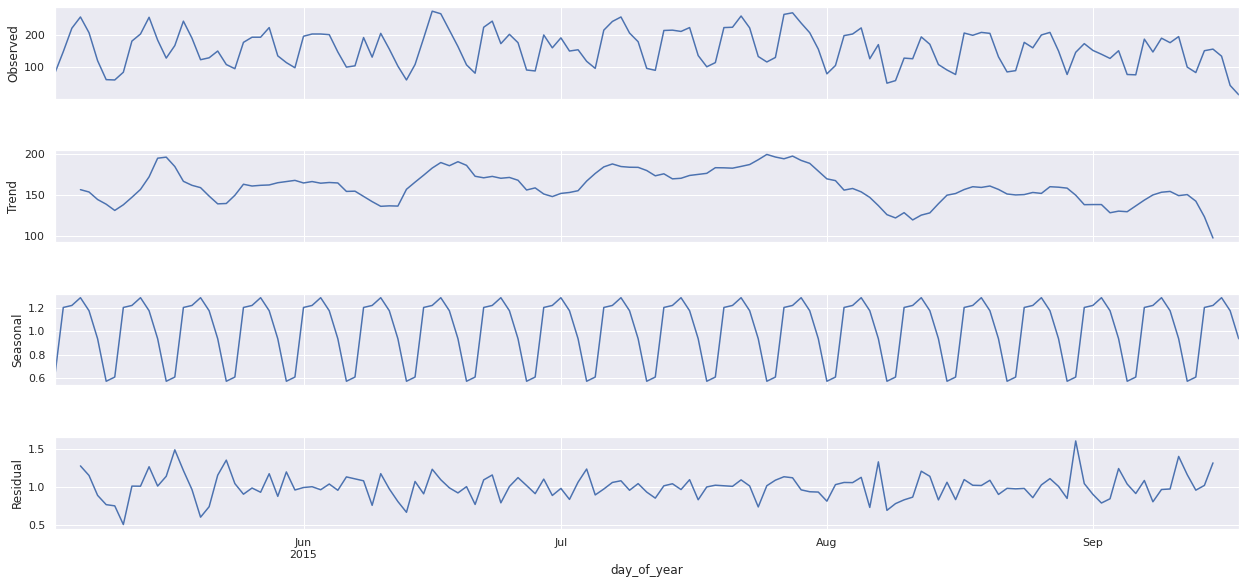

In [223]:
res= seasonal_decompose(trans_day, model='multiplicative')

fig=res.plot()
fig.set_size_inches(20, 10)
plt.show();

A vue d'oeil, le résidu est un bruit blanc. Le modèle multiplicatif semble adapté. 

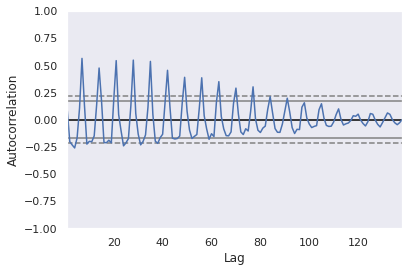

In [224]:
trans_daylog=np.log(trans_day)

trans_daylog1=trans_daylog.diff().dropna()

pd.plotting.autocorrelation_plot(trans_daylog1);

On remarque une décroissance vers 0 de l'ACF. Il semble y avoir une période 7.

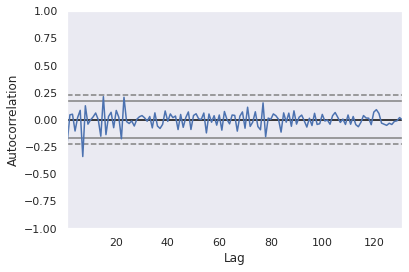

In [225]:
trans_daylog2=trans_daylog1.diff(periods=7).dropna()

pd.plotting.autocorrelation_plot(trans_daylog2);

On cherche le modèle SARIMA le plus adapté en utilisant les graphiques ACF et PACF.

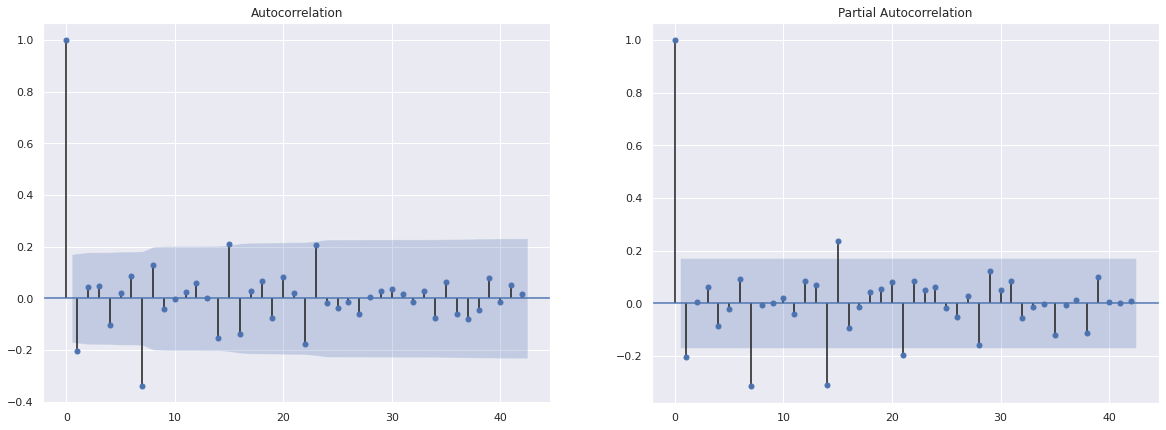

In [226]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(20,7))

plot_acf(trans_daylog2, lags=42, ax=ax1) 

plot_pacf(trans_daylog2, lags=42, ax=ax2, method="ywm")

plt.show()

Il y a décroissance globale de l'ACF et du PACF, avec une coupure des pics saisonniers sur l'ACF après une période de 7 jours.

On teste un modèle SARIMA(1,1,1)(1,1,0)7.

In [227]:
model=sm.tsa.SARIMAX(trans_daylog, order=(1,1,1), seasonal_order=(1,1,0,7))

sarima_trans= model.fit()

print(sarima_trans.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                       transaction   No. Observations:                  139
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 7)   Log Likelihood                 -37.251
Date:                           Thu, 02 Dec 2021   AIC                             82.502
Time:                                   07:18:53   BIC                             94.002
Sample:                               05-03-2015   HQIC                            87.175
                                    - 09-18-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6552      0.120      5.463      0.000       0.420       0.890
ma.L1         -0.9692      0.096    -10.146

Le modèle semble significatif, à l'exception du test de Jarque-Bera. Les résidus ne suivent pas une loi normale.

In [228]:
pred_trans=np.exp(sarima_trans.predict(1,139))

pred_trans=pred_trans.reset_index().set_index(trans_day.index)[0]

pred_trans.head(10)

day_of_year
2015-05-03     79.999996
2015-05-04    147.999993
2015-05-05    220.999992
2015-05-06    255.999995
2015-05-07    207.000001
2015-05-08    120.000004
2015-05-09    545.600607
2015-05-10    111.000009
2015-05-11    131.051195
2015-05-12    203.390862
Name: 0, dtype: float64

In [229]:
trans_day.head(10)

day_of_year
2015-05-03     80
2015-05-04    148
2015-05-05    221
2015-05-06    256
2015-05-07    207
2015-05-08    120
2015-05-09     61
2015-05-10     60
2015-05-11     84
2015-05-12    181
Name: transaction, dtype: int64

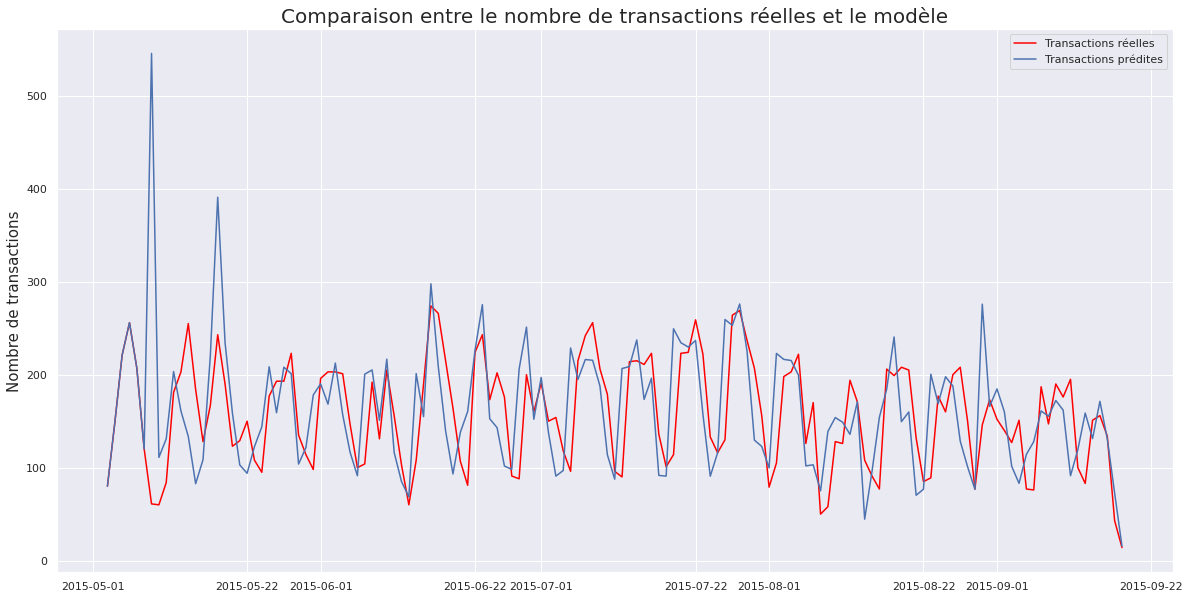

In [230]:
plt.figure(figsize=(20,10))
plt.plot(trans_day, color='red', label='Transactions réelles')
plt.plot(pred_trans, label='Transactions prédites')
plt.title("Comparaison entre le nombre de transactions réelles et le modèle", fontsize=20)
plt.ylabel("Nombre de transactions", fontsize=15)
plt.legend()
plt.show();

Le modèle produit une valeur incohérente pour la date '2015-05-09'. On peut la modifier.

In [231]:
pred_trans['2015-05-09']=trans_day['2015-05-09']

pred_trans.head(20)

day_of_year
2015-05-03     79.999996
2015-05-04    147.999993
2015-05-05    220.999992
2015-05-06    255.999995
2015-05-07    207.000001
2015-05-08    120.000004
2015-05-09     61.000000
2015-05-10    111.000009
2015-05-11    131.051195
2015-05-12    203.390862
2015-05-13    160.949959
2015-05-14    133.504521
2015-05-15     82.762813
2015-05-16    108.518384
2015-05-17    220.716429
2015-05-18    390.885081
2015-05-19    234.550978
2015-05-20    158.761552
2015-05-21    102.912489
2015-05-22     93.934842
Name: 0, dtype: float64

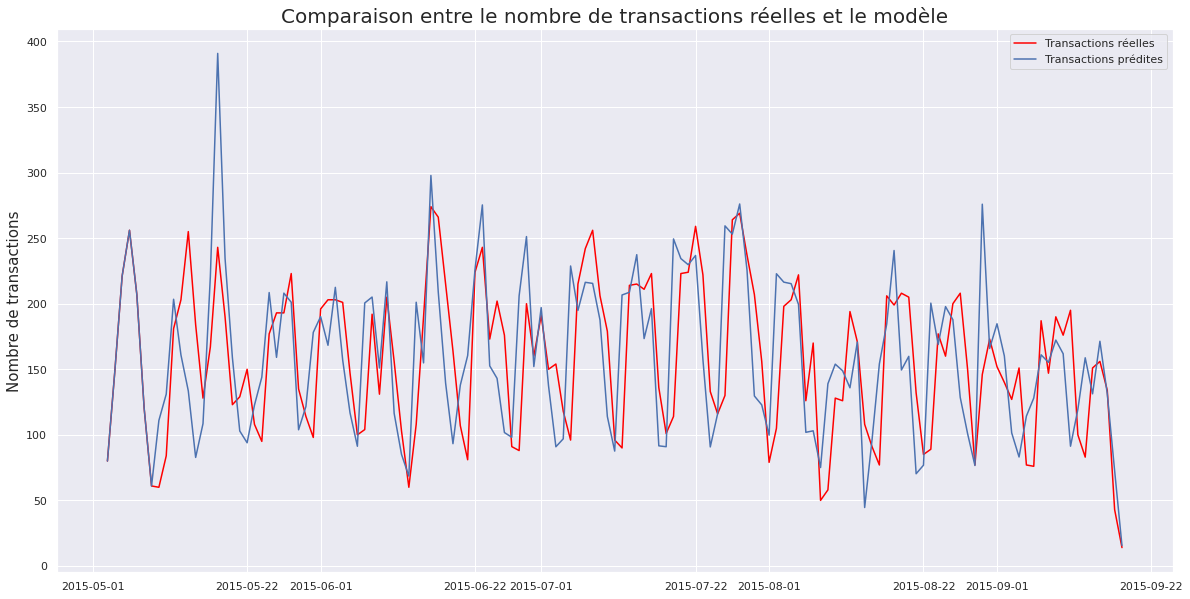

<Figure size 432x288 with 0 Axes>

In [232]:
plt.figure(figsize=(20,10))
plt.plot(trans_day, color='red', label='Transactions réelles')
plt.plot(pred_trans, label='Transactions prédites')
plt.title("Comparaison entre le nombre de transactions réelles et le modèle", fontsize=20)
plt.ylabel("Nombre de transactions", fontsize=15)
plt.legend()
plt.show()

fig=plt.gcf()
fig.savefig("time_series_transaction.png", dpi=300);

Il reste quelques pics prédits exacerbés, notamment le 18 mai.

In [233]:
diff= pred_trans- trans_day

print("Erreur relative:", diff.mean()/trans_day.mean())
print("Ecart absolu moyen:", abs(diff).mean())
print("Ecart quadratique moyen:", (diff**2).mean()**0.5)

Erreur relative: 0.010192047954345503
Ecart absolu moyen: 38.44196262404545
Ecart quadratique moyen: 51.811326582418296


Le nombre de transactions avoisinant les 150 par jour, l'écart absolu moyen est correct. La présence de pics indésirables augmente l'écart quadratique moyen.

Le modèle sur-évalue très légèrement les valeurs exactes.

### **Q2: Peut-on prédire le taux de conversion d'achat pour un utilisateur?**

Etudions le comportement du visiteur le plus actif.

In [234]:
events['visitorid'].value_counts()

1150086    6642
530559     3417
152963     2910
895999     2454
163561     2379
           ... 
525787        1
527834        1
529881        1
531928        1
400188        1
Name: visitorid, Length: 1234540, dtype: int64

L'utilisateur le plus actif a pour identifiant '1150086'.

In [235]:
events_visitor=events[events.visitorid == 1150086]

events_visitor.head(10)

timestamp  visitorid        event  ...  day_of_year  categoryid  parentid
2212   1434747623173    1150086         view  ...   2015-06-19       463.0     250.0
10565  1436803291104    1150086         view  ...   2015-07-13       858.0    1426.0
11959  1437514360633    1150086         view  ...   2015-07-21       858.0    1426.0
12567  1437855049563    1150086         view  ...   2015-07-25       858.0    1426.0
12568  1437855082768    1150086         view  ...   2015-07-25       858.0    1426.0
12657  1437927579715    1150086         view  ...   2015-07-26       858.0    1426.0
13192  1438268590578    1150086         view  ...   2015-07-30       858.0    1426.0
13193  1438268638498    1150086    addtocart  ...   2015-07-30       858.0    1426.0
13194  1438268747755    1150086  transaction  ...   2015-07-30       858.0    1426.0
13367  1438372608201    1150086         view  ...   2015-07-31       858.0    1426.0

[10 rows x 11 columns]

Nous n'avons plus besoin de la colonne 'visitorid'. Nous pouvons l'enlever.

In [236]:
events_visitor=events_visitor.drop(['visitorid','transactionid'], axis=1)

Avant de lancer un modèle, il faut créer des features pertinents.

In [237]:
events_visitor=events_visitor.join(pd.get_dummies(events_visitor['event']))

On regroupe des évènements par une fenêtre mobile. Cela permet de suivre localement dans le temps les actions de l'utilisateur.

On calcule des ratios pour mieux prendre en compte l'attraction, l'engagement et la conversion de l'utilisateur.

In [238]:
events_visitor['nbr_view_rolling_week']=events_visitor['view'].rolling(7).sum()
events_visitor['nbr_addtocart_rolling_week']=events_visitor['addtocart'].rolling(7).sum()
events_visitor['nbr_transaction_rolling_week']=events_visitor['transaction'].rolling(7).sum()

events_visitor['attraction_rate']=(events_visitor['nbr_addtocart_rolling_week'])/(events_visitor['nbr_view_rolling_week']+1)
events_visitor['engagement_rate']=(events_visitor['nbr_transaction_rolling_week'])/(events_visitor['nbr_addtocart_rolling_week']+1)
events_visitor['conversion_rate']=(events_visitor['nbr_transaction_rolling_week'])/(events_visitor['nbr_view_rolling_week']+1)

In [239]:
events_visitor=events_visitor.dropna()

On rajoute des features. Pour chaque objet, on compte le nombre total de vues, de mises au panier et de transactions.

In [240]:
combin=events_visitor[['itemid', 'view', 'addtocart','transaction']].groupby(by='itemid').sum().reset_index()

combin=combin.rename(columns={'view':'total_view','addtocart':'total_addtocart','transaction':'total_transaction'})

events_visitor=events_visitor.merge(combin, on='itemid')

events_visitor.head()

timestamp        event  ...  total_addtocart  total_transaction
0  1438268590578         view  ...                1                  1
1  1438268638498    addtocart  ...                1                  1
2  1438268747755  transaction  ...                1                  1
3  1438372608201         view  ...                1                  1
4  1438372862409         view  ...                1                  1

[5 rows x 21 columns]

On sélectionne les features pertinents. La variable cible sera le taux de conversion.

In [241]:
features=events_visitor[['weekday','hour',
                         'nbr_view_rolling_week','nbr_addtocart_rolling_week','nbr_transaction_rolling_week',
                         'total_view', 'total_addtocart','total_transaction',
                        'attraction_rate', 'engagement_rate']]
target=events_visitor.conversion_rate

In [242]:
std= StandardScaler()
features_scaled=std.fit_transform(features)


In [243]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

On teste un modèle de régression simple: la régression linéaire.

In [244]:
lr= LinearRegression()

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9021117029935792

Le score semble bon.

In [245]:
y_pred=lr.predict(X_test)

def rmse (pred, target):
    return np.sqrt(((pred-target)**2).mean())

def amse (pred, target):
    return ((np.abs(pred-target)).mean())

print("RMSE:",rmse(y_test,y_pred))
print("AMSE:",amse(y_test,y_pred))

RMSE: 0.04654321640513249
AMSE: 0.024263263156933425


Là-encore, les erreurs du modèle ne dépassent pas 0.1 en moyenne, ce qui est satisfaisant ici.

In [246]:
coeffs = list(lr.coef_)
coeffs.insert(0, lr.intercept_)

feats = list(features.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'valeur estimée': coeffs}, index=feats)

valeur estimée
intercept                       1.121971e-01
weekday                         1.090498e-03
hour                            1.243482e-03
nbr_view_rolling_week           1.226331e+12
nbr_addtocart_rolling_week      7.614651e+11
nbr_transaction_rolling_week    6.321312e+11
total_view                     -3.797389e-04
total_addtocart                -1.553443e-02
total_transaction               1.343212e-02
attraction_rate                 5.511792e-02
engagement_rate                -9.179310e-02

La plupart des features ne sont pas pertinents. La variable cible est dépendante des features conceptuellement les plus proches ('engagement rate', 'nbr_transaction_rolling_week').

On entraîne ensuite un modèle Lasso pour comparaison.

In [247]:
lasso=LassoCV(alphas=(0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))

lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.9174856844316878

Le score du modèle est correct.

Le paramètre alpha choisi vaut: 0.001


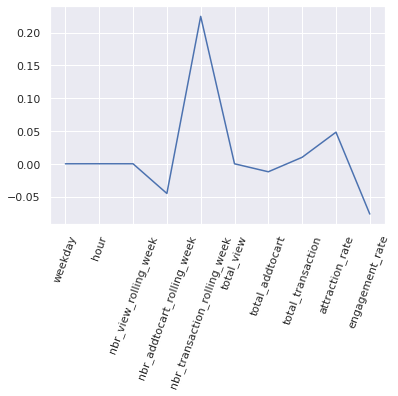

In [248]:
print("Le paramètre alpha choisi vaut:", lasso.alpha_)
    
lasso_coef = lasso.coef_

plt.plot(range(len(features.columns)), lasso_coef)
plt.xticks(range(len(features.columns)), features.columns.values, rotation=70);

On obtient le même constat qu'avec le modèle linéaire.

In [249]:
y_pred=lasso.predict(X_test)

def rmse (pred, target):
    return np.sqrt(((pred-target)**2).mean())

def amse (pred, target):
    return ((np.abs(pred-target)).mean())

print("RMSE:",rmse(y_test,y_pred))
print("AMSE:",amse(y_test,y_pred))

RMSE: 0.042732239772683464
AMSE: 0.022316188388394262


Les erreurs sont encore satisfaisantes.

A côté du modèle Lasso, on teste un modèle Ridge.

In [250]:
ridge=RidgeCV(alphas=(0.001, 0.01, 0.1, 0.5, 1, 5, 7.5, 10, 20, 50, 100))

ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.902805278083557

Le score du modèle est correct.

Le paramètre alpha choisi vaut: 1.0


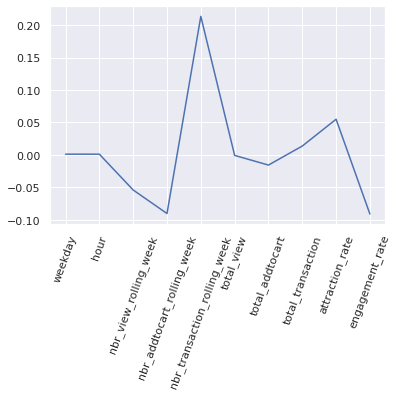

In [251]:
print("Le paramètre alpha choisi vaut:", ridge.alpha_)
ridge_coef = ridge.coef_

plt.plot(range(len(features.columns)), ridge_coef)
plt.xticks(range(len(features.columns)), features.columns.values, rotation=70);

On obtient le même constat qu'avec le modèle linéaire.

In [252]:
y_pred=ridge.predict(X_test)

def rmse (pred, target):
    return np.sqrt(((pred-target)**2).mean())

def amse (pred, target):
    return ((np.abs(pred-target)).mean())

print("RMSE:",rmse(y_test,y_pred))
print("AMSE:",amse(y_test,y_pred))

RMSE: 0.0463780352696754
AMSE: 0.024064890081847985


Les erreurs sont encore satisfaisantes.

On teste enfin un modèle ElasticNet

In [253]:
l1_ratio=(0.01,0.1, 0.2, 0.3, 0.5, 0.75, 0.8, 0.9, 0.99)
alphas=(0.001, 0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0, 5.0)

model_en= ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, cv=8)
model_en.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01837161173083146, tolerance: 0.015879880320912507
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016961405385043093, tolerance: 0.015959056171144473
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021514713633695948, tolerance: 0.015620659534915456
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check th

ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0, 5.0),
             cv=8, l1_ratio=(0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.8, 0.9, 0.99))

In [254]:
values=list(model_en.coef_)
values.insert(0,model_en.intercept_)

col=list(features.columns)
col.insert(0,'intercept')

pd.DataFrame({'Valeurs estimées': values }, index=col)

Valeurs estimées
intercept                             0.111770
weekday                               0.001168
hour                                  0.001129
nbr_view_rolling_week                -0.052609
nbr_addtocart_rolling_week           -0.088241
nbr_transaction_rolling_week          0.211803
total_view                           -0.000664
total_addtocart                      -0.015727
total_transaction                     0.013729
attraction_rate                       0.054672
engagement_rate                      -0.089089

''

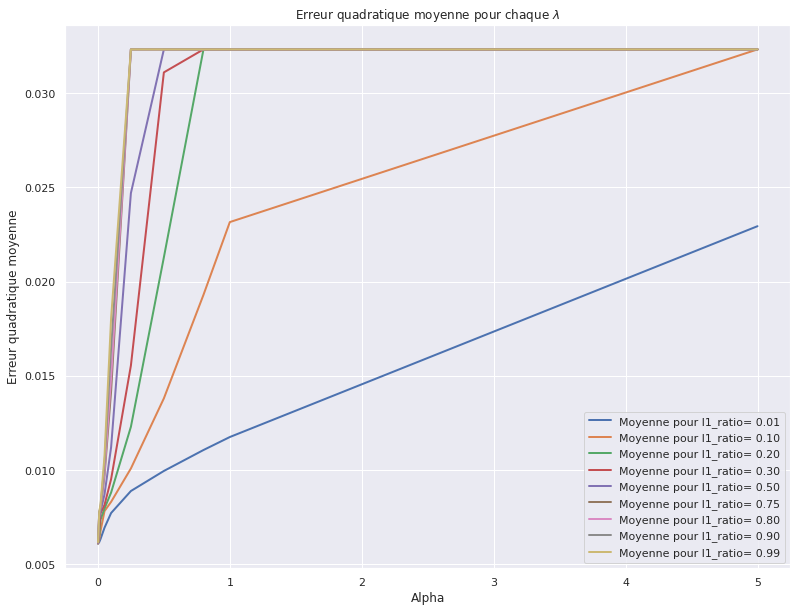

In [255]:
alphas= model_en.alphas_

plt.figure(figsize=(13,10))

for i in range(len(l1_ratio)):
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1), label='Moyenne pour l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)
    
plt.xlabel('Alpha')
plt.ylabel('Erreur quadratique moyenne')
plt.title('Erreur quadratique moyenne pour chaque $\lambda$')
plt.legend()

;

Ce modèle suggère que le modèle Ridge est le plus adapté pour minimiser la RMSE.

### **Q3: Peut-on prédire le taux de conversion d'achat pour un objet ?**

Etudions l'objet le plus vendu.

In [256]:
events[events['event']=='transaction']['itemid'].value_counts()

461686    133
119736     97
213834     92
7943       46
312728     46
         ... 
424806      1
363368      1
238445      1
354288      1
329729      1
Name: itemid, Length: 11628, dtype: int64

L'objet le plus vendu a pour identifiant '461686'.

In [257]:
events_item=events[events.itemid == 461686]

events_item.head(10)

timestamp  visitorid  ... categoryid  parentid
2269628  1430672278598    1187700  ...     1037.0     402.0
2269629  1430678952339     318322  ...     1037.0     402.0
2269631  1430702901373    1169396  ...     1037.0     402.0
2269632  1430714073335     557232  ...     1037.0     402.0
2269639  1430768995809     350405  ...     1037.0     402.0
2269643  1430773265634     741178  ...     1037.0     402.0
2269644  1430773400263     741178  ...     1037.0     402.0
2269645  1430773625527     868541  ...     1037.0     402.0
2269646  1430778727991     499380  ...     1037.0     402.0
2269650  1430799384768    1175928  ...     1037.0     402.0

[10 rows x 11 columns]

In [258]:
events_item['event'].value_counts()

view           2538
addtocart       304
transaction     133
Name: event, dtype: int64

La colonne 'itemid' n'est plus nécessaire.

In [259]:
events_item=events_item.drop(['itemid','transactionid'], axis=1)

On fait du feature engineering, en reprenant les mêmes idées que l'analyse par utilisateur.

In [260]:
events_item=events_item.join(pd.get_dummies(events_item['event']))

events_item['nbr_view_rolling_week']=events_item['view'].rolling(7).sum()
events_item['nbr_addtocart_rolling_week']=events_item['addtocart'].rolling(7).sum()
events_item['nbr_transaction_rolling_week']=events_item['transaction'].rolling(7).sum()

events_item['attraction_rate']=(events_item['nbr_addtocart_rolling_week'])/(events_item['nbr_view_rolling_week']+1)
events_item['engagement_rate']=(events_item['nbr_transaction_rolling_week'])/(events_item['nbr_addtocart_rolling_week']+1)
events_item['conversion_rate']=(events_item['nbr_transaction_rolling_week'])/(events_item['nbr_view_rolling_week']+1)

In [261]:
events_item=events_item.dropna()

In [262]:
combin=events_item[['visitorid', 'view', 'addtocart','transaction']].groupby(by='visitorid').sum().reset_index()

combin=combin.rename(columns={'view':'total_view','addtocart':'total_addtocart','transaction':'total_transaction'})

events_item=events_item.merge(combin, on='visitorid')

events_item.head()

timestamp  visitorid  ... total_addtocart  total_transaction
0  1430773400263     741178  ...               0                  1
1  1430773625527     868541  ...               0                  0
2  1430778727991     499380  ...               0                  0
3  1430799384768    1175928  ...               0                  0
4  1430799424367    1175928  ...               0                  0

[5 rows x 21 columns]

In [264]:
features=events_item[['weekday','hour',
                         'nbr_view_rolling_week','nbr_addtocart_rolling_week','nbr_transaction_rolling_week',
                         'total_view', 'total_addtocart','total_transaction',
                        'attraction_rate', 'engagement_rate']]

target=events_item.conversion_rate

In [265]:
std= StandardScaler()
features_scaled=std.fit_transform(features)

In [266]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

On entraîne un modèle de régression linéaire.

In [267]:
lr= LinearRegression()

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9913729399759235

Le score est excellent.

In [268]:
y_pred=lr.predict(X_test)

def rmse (pred, target):
    return np.sqrt(((pred-target)**2).mean())

def amse (pred, target):
    return ((np.abs(pred-target)).mean())

print("RMSE:",rmse(y_test,y_pred))
print("AMSE:",amse(y_test,y_pred))

RMSE: 0.0077205055014891895
AMSE: 0.004422325851159281


Les erreurs sont très faibles.

In [269]:
coeffs = list(lr.coef_)
coeffs.insert(0, lr.intercept_)

feats = list(features.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'valeur estimée': coeffs}, index=feats)

valeur estimée
intercept                       5.366231e-02
weekday                         2.339221e-04
hour                           -9.465607e-05
nbr_view_rolling_week          -7.909213e+10
nbr_addtocart_rolling_week     -5.985928e+10
nbr_transaction_rolling_week   -4.045848e+10
total_view                     -2.814830e-05
total_addtocart                -1.401848e-03
total_transaction               8.458857e-04
attraction_rate                 1.630019e-02
engagement_rate                -2.619215e-02

Seules certaines features sont pertinentes, le constat de la section précédente est de nouveau valide.

On entraîne ensuite un modèle Lasso pour comparaison.

In [270]:
lasso=LassoCV(alphas=(0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))

lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.9881410117260002

Le score du modèle est bon.

Le paramètre alpha choisi vaut: 0.001


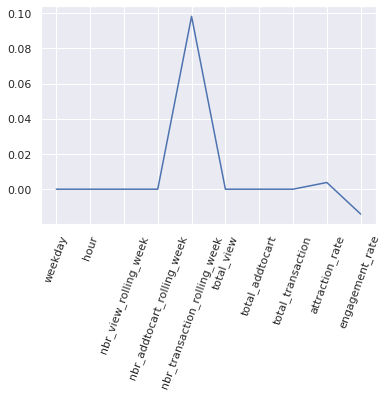

In [271]:
print("Le paramètre alpha choisi vaut:", lasso.alpha_)
    
lasso_coef = lasso.coef_

plt.plot(range(len(features.columns)), lasso_coef)
plt.xticks(range(len(features.columns)), features.columns.values, rotation=70);

On obtient le même constat qu'avec le modèle linéaire.

In [272]:
y_pred=lasso.predict(X_test)

def rmse (pred, target):
    return np.sqrt(((pred-target)**2).mean())

def amse (pred, target):
    return ((np.abs(pred-target)).mean())

print("RMSE:",rmse(y_test,y_pred))
print("AMSE:",amse(y_test,y_pred))

RMSE: 0.009051866636081473
AMSE: 0.005013370046924255


Les erreurs sont encore satisfaisantes.

A côté du modèle Lasso, on teste un modèle Ridge.

In [273]:
ridge=RidgeCV(alphas=(0.001, 0.01, 0.1, 0.5, 1, 5, 7.5, 10, 20, 50, 100))

ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.9914158577852177

Le score du modèle est excellent.

Le paramètre alpha choisi vaut: 1.0


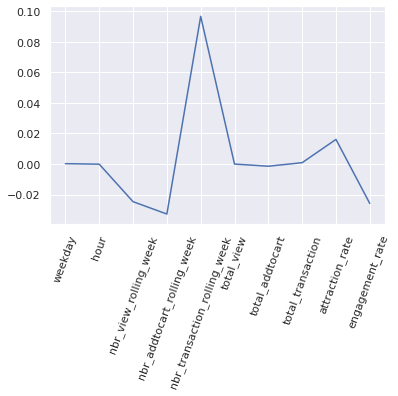

In [274]:
print("Le paramètre alpha choisi vaut:", ridge.alpha_)
ridge_coef = ridge.coef_

plt.plot(range(len(features.columns)), ridge_coef)
plt.xticks(range(len(features.columns)), features.columns.values, rotation=70);

On obtient le même constat qu'avec le modèle linéaire.

In [275]:
y_pred=ridge.predict(X_test)

def rmse (pred, target):
    return np.sqrt(((pred-target)**2).mean())

def amse (pred, target):
    return ((np.abs(pred-target)).mean())

print("RMSE:",rmse(y_test,y_pred))
print("AMSE:",amse(y_test,y_pred))

RMSE: 0.007701277612398229
AMSE: 0.004339706349088163


Les erreurs sont encore satisfaisantes.

On teste enfin un modèle ElasticNet

In [276]:
l1_ratio=(0.01,0.1, 0.2, 0.3, 0.5, 0.75, 0.8, 0.9, 0.99)
alphas=(0.001, 0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0, 5.0)

model_en= ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, cv=8)
model_en.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-03, tolerance: 1.913e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0, 5.0),
             cv=8, l1_ratio=(0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.8, 0.9, 0.99))

In [277]:
values=list(model_en.coef_)
values.insert(0,model_en.intercept_)

col=list(features.columns)
col.insert(0,'intercept')

pd.DataFrame({'Valeurs estimées': values }, index=col)

Valeurs estimées
intercept                             0.053726
weekday                               0.000218
hour                                 -0.000095
nbr_view_rolling_week                -0.022114
nbr_addtocart_rolling_week           -0.030252
nbr_transaction_rolling_week          0.097457
total_view                           -0.000021
total_addtocart                      -0.001445
total_transaction                     0.000872
attraction_rate                       0.015673
engagement_rate                      -0.025258

''

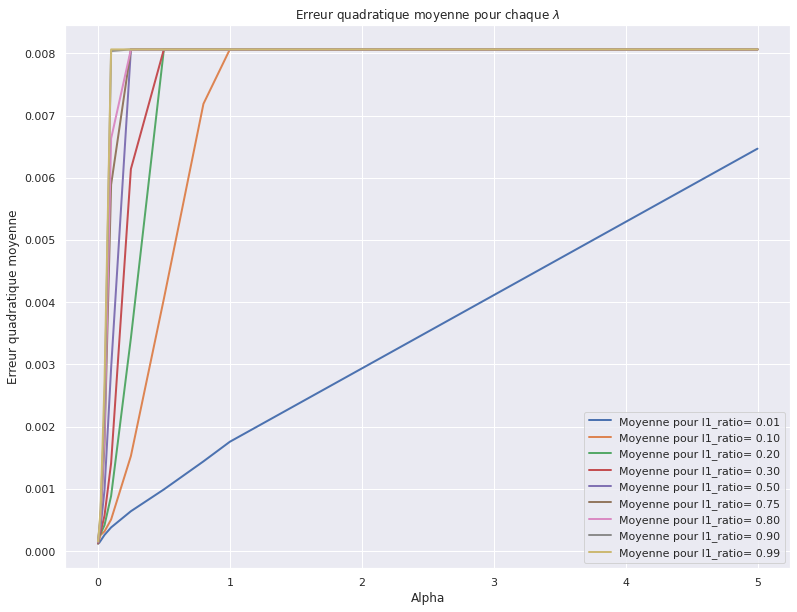

In [278]:
alphas= model_en.alphas_

plt.figure(figsize=(13,10))

for i in range(len(l1_ratio)):
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1), label='Moyenne pour l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)
    
plt.xlabel('Alpha')
plt.ylabel('Erreur quadratique moyenne')
plt.title('Erreur quadratique moyenne pour chaque $\lambda$')
plt.legend()

;

Là-encore, on constate que le modèle le plus adapté tends vers un modèle Ridge.

### **Q4: peut-on prédire si un utilisateur va acheter un produit ?**

On crée notre variable cible.

In [279]:
events_visitor['transaction_finale']=events_visitor['total_transaction'].apply(lambda x: min(x,1))

Un feature qui semple pertinent est la mesure "peak to peak" du timestamp. Cela traduit le temps passé à consulter un objet donné. 

In [280]:
time_onitem=events_visitor.groupby(by='itemid')['timestamp'].agg(np.ptp).reset_index().rename(columns={'timestamp':'peaktopeak'})

time_onitem.head()

itemid  peaktopeak
0      25       60321
1      42           0
2     388           0
3     546  2490811079
4     550           0

In [281]:
events_visitor2=events_visitor.merge(time_onitem, on='itemid')

events_visitor2.head()

timestamp        event  ...  transaction_finale  peaktopeak
0  1438268590578         view  ...                   1      157177
1  1438268638498    addtocart  ...                   1      157177
2  1438268747755  transaction  ...                   1      157177
3  1438372608201         view  ...                   1   591129620
4  1438372862409         view  ...                   1   591129620

[5 rows x 23 columns]

In [282]:
events_visitor2=events_visitor2.groupby(by='itemid').mean()

#### Preprocessing des données d'entraînement et de test

In [283]:
features=events_visitor2[['hour','weekday','peaktopeak','nbr_view_rolling_week','total_view']]
target=events_visitor2.transaction_finale

In [284]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state= 42 )

In [285]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [286]:
print('Classes échantillon:', dict(pd.Series(y_train).value_counts()))

ros = RandomOverSampler()
X_ro, y_ro =ros.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

#SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

rus = RandomUnderSampler()
X_ru, y_ru =rus.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

#SMOTE
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)
print('Classes échantillon ClusterCentroids :', dict(pd.Series(y_cc).value_counts()))

Classes échantillon: {0.0: 2214, 1.0: 411}
Classes échantillon oversampled : {1.0: 2214, 0.0: 2214}
Classes échantillon SMOTE : {1.0: 2214, 0.0: 2214}
Classes échantillon undersampled : {1.0: 411, 0.0: 411}
Classes échantillon ClusterCentroids : {1.0: 411, 0.0: 411}


On constate un déséquilibre dans le jeu de données. On teste un modèle de Régression Logistique pour visualiser l'importance de l'oversampling/undersampling.

In [287]:
clf_lr=LogisticRegression(max_iter=1000)

params_lr ={'solver': ['liblinear', 'lbfgs'], 'C': [10**(i) for i in range(-4, 3)]}

gridcv=GridSearchCV(clf_lr, param_grid= params_lr,  scoring='accuracy', cv=3)

In [288]:
gridcv.fit(X_train, y_train)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

params  mean_test_score  std_test_score
0   {'C': 0.0001, 'solver': 'liblinear'}         0.843429        0.000000
1       {'C': 0.0001, 'solver': 'lbfgs'}         0.843429        0.000000
2    {'C': 0.001, 'solver': 'liblinear'}         0.843429        0.000000
3        {'C': 0.001, 'solver': 'lbfgs'}         0.843429        0.000000
4     {'C': 0.01, 'solver': 'liblinear'}         0.843429        0.000000
5         {'C': 0.01, 'solver': 'lbfgs'}         0.843429        0.000000
6      {'C': 0.1, 'solver': 'liblinear'}         0.843048        0.000539
7          {'C': 0.1, 'solver': 'lbfgs'}         0.843048        0.000539
8        {'C': 1, 'solver': 'liblinear'}         0.844190        0.002851
9            {'C': 1, 'solver': 'lbfgs'}         0.846095        0.003771
10      {'C': 10, 'solver': 'liblinear'}         0.847238        0.004208
11          {'C': 10, 'solver': 'lbfgs'}         0.847238        0.004208
12     {'C': 100, 'solver': 'liblinear'}         0.846857        0.002799
13         {'C': 100, 'solver': 'lbfgs'}         0.846857        0.002799

Le meilleur paramètrage est obtenu pour C=10 et solver='liblinear'.

In [289]:
clf_lr=LogisticRegression(max_iter=1000, C=10, solver='liblinear')

clf_lr.fit(X_train, y_train)
y_pred=clf_lr.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

print(classification_report_imbalanced(y_test, y_pred))

Classes prédites  0.0  1.0
Classes réelles           
0.0               536   16
1.0                89   16
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.86      0.97      0.15      0.91      0.38      0.16       552
        1.0       0.50      0.15      0.97      0.23      0.38      0.14       105

avg / total       0.80      0.84      0.28      0.80      0.38      0.16       657



Le f1 score global est bon, au détriment de la classe minoritaire (score f1 faible pour la classe 1).

In [290]:
gridcv.fit(X_ro, y_ro)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

params  mean_test_score  std_test_score
0   {'C': 0.0001, 'solver': 'liblinear'}         0.499548        0.000639
1       {'C': 0.0001, 'solver': 'lbfgs'}         0.650858        0.004225
2    {'C': 0.001, 'solver': 'liblinear'}         0.547200        0.006364
3        {'C': 0.001, 'solver': 'lbfgs'}         0.650632        0.005228
4     {'C': 0.01, 'solver': 'liblinear'}         0.637308        0.006692
5         {'C': 0.01, 'solver': 'lbfgs'}         0.640470        0.003925
6      {'C': 0.1, 'solver': 'liblinear'}         0.643406        0.002729
7          {'C': 0.1, 'solver': 'lbfgs'}         0.633921        0.005811
8        {'C': 1, 'solver': 'liblinear'}         0.649051        0.009787
9            {'C': 1, 'solver': 'lbfgs'}         0.645664        0.008516
10      {'C': 10, 'solver': 'liblinear'}         0.668925        0.010039
11          {'C': 10, 'solver': 'lbfgs'}         0.668699        0.010155
12     {'C': 100, 'solver': 'liblinear'}         0.681346        0.012174
13         {'C': 100, 'solver': 'lbfgs'}         0.681572        0.011903

In [291]:
clf_lr=LogisticRegression(max_iter=1000, C=100, solver='liblinear')

clf_lr.fit(X_ro, y_ro)
y_pred=clf_lr.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

print(classification_report_imbalanced(y_test, y_pred))

Classes prédites  0.0  1.0
Classes réelles           
0.0               365  187
1.0                36   69
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.91      0.66      0.66      0.77      0.66      0.43       552
        1.0       0.27      0.66      0.66      0.38      0.66      0.43       105

avg / total       0.81      0.66      0.66      0.70      0.66      0.43       657



Le score f1 global a baissé, mais il s'est un peu rééquilibré entre les classes.

In [292]:
gridcv.fit(X_sm, y_sm)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

params  mean_test_score  std_test_score
0   {'C': 0.0001, 'solver': 'liblinear'}         0.499774        0.000319
1       {'C': 0.0001, 'solver': 'lbfgs'}         0.635050        0.006760
2    {'C': 0.001, 'solver': 'liblinear'}         0.519648        0.003989
3        {'C': 0.001, 'solver': 'lbfgs'}         0.633469        0.007442
4     {'C': 0.01, 'solver': 'liblinear'}         0.632565        0.005650
5         {'C': 0.01, 'solver': 'lbfgs'}         0.629404        0.007605
6      {'C': 0.1, 'solver': 'liblinear'}         0.634372        0.008377
7          {'C': 0.1, 'solver': 'lbfgs'}         0.631662        0.013095
8        {'C': 1, 'solver': 'liblinear'}         0.642954        0.013079
9            {'C': 1, 'solver': 'lbfgs'}         0.643180        0.013576
10      {'C': 10, 'solver': 'liblinear'}         0.664860        0.009666
11          {'C': 10, 'solver': 'lbfgs'}         0.664408        0.009539
12     {'C': 100, 'solver': 'liblinear'}         0.688799        0.016755
13         {'C': 100, 'solver': 'lbfgs'}         0.688799        0.016755

In [293]:
clf_lr=LogisticRegression(max_iter=1000, C=100, solver='liblinear')

clf_lr.fit(X_sm, y_sm)
y_pred=clf_lr.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

print(classification_report_imbalanced(y_test, y_pred))

Classes prédites  0.0  1.0
Classes réelles           
0.0               366  186
1.0                37   68
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.91      0.66      0.65      0.77      0.66      0.43       552
        1.0       0.27      0.65      0.66      0.38      0.66      0.43       105

avg / total       0.81      0.66      0.65      0.70      0.66      0.43       657



In [294]:
gridcv.fit(X_ru, y_ru)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

params  mean_test_score  std_test_score
0   {'C': 0.0001, 'solver': 'liblinear'}         0.500000        0.000000
1       {'C': 0.0001, 'solver': 'lbfgs'}         0.659367        0.025344
2    {'C': 0.001, 'solver': 'liblinear'}         0.503650        0.002980
3        {'C': 0.001, 'solver': 'lbfgs'}         0.652068        0.025692
4     {'C': 0.01, 'solver': 'liblinear'}         0.627737        0.005960
5         {'C': 0.01, 'solver': 'lbfgs'}         0.653285        0.027311
6      {'C': 0.1, 'solver': 'liblinear'}         0.663017        0.020284
7          {'C': 0.1, 'solver': 'lbfgs'}         0.652068        0.025344
8        {'C': 1, 'solver': 'liblinear'}         0.663017        0.029849
9            {'C': 1, 'solver': 'lbfgs'}         0.664234        0.028427
10      {'C': 10, 'solver': 'liblinear'}         0.675182        0.026819
11          {'C': 10, 'solver': 'lbfgs'}         0.672749        0.025344
12     {'C': 100, 'solver': 'liblinear'}         0.680049        0.023901
13         {'C': 100, 'solver': 'lbfgs'}         0.680049        0.023901

In [295]:
clf_lr=LogisticRegression(max_iter=1000, C=100, solver='liblinear')

clf_lr.fit(X_ru, y_ru)
y_pred=clf_lr.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

print(classification_report_imbalanced(y_test, y_pred))

Classes prédites  0.0  1.0
Classes réelles           
0.0               351  201
1.0                33   72
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.91      0.64      0.69      0.75      0.66      0.43       552
        1.0       0.26      0.69      0.64      0.38      0.66      0.44       105

avg / total       0.81      0.64      0.68      0.69      0.66      0.43       657



In [296]:
gridcv.fit(X_cc, y_cc)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

params  mean_test_score  std_test_score
0   {'C': 0.0001, 'solver': 'liblinear'}         0.504866        0.012406
1       {'C': 0.0001, 'solver': 'lbfgs'}         0.644769        0.006882
2    {'C': 0.001, 'solver': 'liblinear'}         0.509732        0.019158
3        {'C': 0.001, 'solver': 'lbfgs'}         0.639903        0.004552
4     {'C': 0.01, 'solver': 'liblinear'}         0.588808        0.010465
5         {'C': 0.01, 'solver': 'lbfgs'}         0.642336        0.008940
6      {'C': 0.1, 'solver': 'liblinear'}         0.630170        0.006203
7          {'C': 0.1, 'solver': 'lbfgs'}         0.638686        0.013656
8        {'C': 1, 'solver': 'liblinear'}         0.624088        0.007884
9            {'C': 1, 'solver': 'lbfgs'}         0.620438        0.015768
10      {'C': 10, 'solver': 'liblinear'}         0.626521        0.009579
11          {'C': 10, 'solver': 'lbfgs'}         0.625304        0.011282
12     {'C': 100, 'solver': 'liblinear'}         0.630170        0.007499
13         {'C': 100, 'solver': 'lbfgs'}         0.630170        0.007499

In [297]:
clf_lr=LogisticRegression(max_iter=1000, C=0.01, solver='lbfgs')

clf_lr.fit(X_cc, y_cc)
y_pred=clf_lr.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

print(classification_report_imbalanced(y_test, y_pred))

Classes prédites  0.0  1.0
Classes réelles           
0.0               348  204
1.0                34   71
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.91      0.63      0.68      0.75      0.65      0.42       552
        1.0       0.26      0.68      0.63      0.37      0.65      0.43       105

avg / total       0.81      0.64      0.67      0.69      0.65      0.42       657



Les diverses méthodes d'oversampling/undersampling donnent globalement des résultats équivalents et augmentent toutes le score f1 de la classe minoritaire pour la régression logistique.
Dans la suite, on sélectionnera des modèles en utilisant l'échantillon de base, puis l'échantillon rééchantillonné par RandomOverSampler.

#### Sélection de modèles

In [298]:
lr = LogisticRegression(random_state=22, max_iter=2000)
clf = RandomForestClassifier(random_state=22)
svm = SVC(random_state=22)

param_grid_lr = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)}

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                        'min_samples_leaf': [1, 3, 5],
                        'max_features': ['sqrt', 'log2']}]

param_grid_svc = [{'kernel': ['rbf'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
                       {'kernel': ['linear'], 'C': np.logspace(-4, 4, 9)}]

In [299]:
gridcvs ={}

for pgrid, clf, name in zip((param_grid_lr, param_grid_rf, param_grid_svc),
                            (lr, clf, svm),
                            ('LogisticRegression', 'RF', 'SVM')):
    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
    gridcvs[name] = gcv

In [300]:
outer_cv = StratifiedKFold(n_splits=3, shuffle= True)

outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_train, y_train, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

LogisticRegression: outer accuracy 84.69 +/- 0.41
RF: outer accuracy 93.30 +/- 0.75
SVM: outer accuracy 85.07 +/- 0.44


Le meilleur modèle est le Random Forest Classifier.

In [301]:
final_clf = gridcvs['RF']
final_clf.fit(X_train, y_train)

print(f'Meilleurs paramètres: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_clf.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Meilleurs paramètres: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 500}
Training Accuracy: 96.95
Test Accuracy: 94.06


L'accuracy est très bonne, mais la différence de deux points entre l'échantillon d'entraînement et de test indique de l'overfitting.

In [302]:
rf_visitor=RandomForestClassifier(max_features='sqrt', min_samples_leaf=5, n_estimators=500)

rf_visitor.fit(X_train, y_train)

y_pred = rf_visitor.predict(X_test)

pd.crosstab(y_test, y_pred, rownames =['Classe réelle'], colnames =['Classe prédite'])

Classe prédite  0.0  1.0
Classe réelle           
0.0             530   22
1.0              17   88

In [303]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.96      0.84      0.96      0.90      0.81       552
        1.0       0.80      0.84      0.96      0.82      0.90      0.79       105

avg / total       0.94      0.94      0.86      0.94      0.90      0.81       657



Le f1 score est bon, même pour la classe minoritaire.

In [304]:
feats = {}
for feature, importance in zip(features.columns, rf_visitor.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

Importance
peaktopeak               0.550914
nbr_view_rolling_week    0.265524
total_view               0.108244
hour                     0.043828
weekday                  0.031490

On réitère les mêmes étapes avec les échantillons rééchantillonnés.

In [305]:
outer_cv = StratifiedKFold(n_splits=3, shuffle= True)

outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_ro, y_ro, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

LogisticRegression: outer accuracy 68.38 +/- 0.48
RF: outer accuracy 96.34 +/- 0.24
SVM: outer accuracy 77.98 +/- 1.52


Le meilleur modèle est le Random Forest Classifier.

In [306]:
final_clf = gridcvs['RF']
final_clf.fit(X_ro, y_ro)

print(f'Meilleurs paramètres: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_ro, y_pred=final_clf.predict(X_ro))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Meilleurs paramètres: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 10}
Training Accuracy: 99.91
Test Accuracy: 94.06


L'overfitting est plus prononcé à présent.

In [307]:
rf_visitor=RandomForestClassifier(max_features='sqrt', min_samples_leaf=1, n_estimators=10)

rf_visitor.fit(X_ro, y_ro)

y_pred = rf_visitor.predict(X_test)

pd.crosstab(y_test, y_pred, rownames =['Classe réelle'], colnames =['Classe prédite'])

Classe prédite  0.0  1.0
Classe réelle           
0.0             530   22
1.0              18   87

In [308]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.96      0.83      0.96      0.89      0.81       552
        1.0       0.80      0.83      0.96      0.81      0.89      0.79       105

avg / total       0.94      0.94      0.85      0.94      0.89      0.80       657



En ayant réétabli l'équilibre entre les deux classes, le f1 score de la classe minoritaire diminue. Le modèle reste satisfaisant globalement, mais il est instable comme souvent avec les classifieurs Random Forest.

In [309]:
feats = {}
for feature, importance in zip(features.columns, rf_visitor.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

Importance
peaktopeak               0.589972
nbr_view_rolling_week    0.246406
total_view               0.074368
hour                     0.048301
weekday                  0.040951

Le feature peaktopeak explique très largement le résultat cible. Ce feature étant facile à mesurer en temps réel, il est pertinent à utiliser en pratique.

#### Méthode d'ensemble

Comme précédemment, nous allons utiliser à la fois l'échantillon de base puis l'échantillon rééchantillonné pour tester la robustesse des méthodes d'ensemble.

La première méthode testée sera AdaBoost.

In [310]:
dtc= DecisionTreeClassifier(max_depth=5)

ac= AdaBoostClassifier(base_estimator = dtc, n_estimators = 400)

ac.fit(X_train, y_train)

ac.score(X_test, y_test)

0.9315068493150684

In [311]:
y_pred = ac.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites  0.0  1.0
Classes Réelles           
0.0               531   21
1.0                24   81

In [312]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.96      0.77      0.96      0.86      0.76       552
        1.0       0.79      0.77      0.96      0.78      0.86      0.73       105

avg / total       0.93      0.93      0.80      0.93      0.86      0.75       657



Méthode avec l'échantillon rééchantillonné:

In [313]:
ac.fit(X_ro, y_ro)

ac.score(X_test, y_test)

0.939117199391172

In [314]:
y_pred = ac.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites  0.0  1.0
Classes Réelles           
0.0               535   17
1.0                23   82

In [315]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.97      0.78      0.96      0.87      0.77       552
        1.0       0.83      0.78      0.97      0.80      0.87      0.74       105

avg / total       0.94      0.94      0.81      0.94      0.87      0.77       657



AdaBoost donne des résultats légèrement supérieurs au Random Forest.

On teste un modèle de classification Bagging.

In [316]:
bc= BaggingClassifier(base_estimator = dtc, n_estimators=1000, oob_score= True)

bc.fit(X_train, y_train)

bc.oob_score_

0.9260952380952381

In [317]:
y_pred = bc.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites  0.0  1.0
Classes Réelles           
0.0               538   14
1.0                31   74

In [318]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.97      0.70      0.96      0.83      0.71       552
        1.0       0.84      0.70      0.97      0.77      0.83      0.67       105

avg / total       0.93      0.93      0.75      0.93      0.83      0.70       657



In [319]:
bc= BaggingClassifier(base_estimator = dtc, n_estimators=1000, oob_score= True)

bc.fit(X_ro, y_ro)

bc.oob_score_

0.9439927732610659

In [320]:
y_pred = bc.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites  0.0  1.0
Classes Réelles           
0.0               503   49
1.0                 4  101

In [321]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.99      0.91      0.96      0.95      0.94      0.87       552
        1.0       0.67      0.96      0.91      0.79      0.94      0.88       105

avg / total       0.94      0.92      0.95      0.92      0.94      0.87       657



Le Bagging donne des résultats similaires à AdaBoost.

On utilise ensuite un modèle de classification Voting.

In [322]:
clf1=RandomForestClassifier()
clf2=LogisticRegression()
clf3=SVC()

cv3=KFold(n_splits=3, shuffle= True, random_state=42)

In [323]:
vclf=VotingClassifier(estimators=[('rf', clf1), ('lr', clf2), ('svm', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, vclf], ['Random Forest', 'Logistic Regression', 'SVM', 'Voting Classifier']):
    scores = cross_validate(clf, X_train, y_train, cv=cv3, scoring=['accuracy','f1'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))

[Random Forest]: 
 Accuracy: 0.93 (+/- 0.01) F1 score: 0.77 (+/- 0.02)
[Logistic Regression]: 
 Accuracy: 0.84 (+/- 0.00) F1 score: 0.10 (+/- 0.02)
[SVM]: 
 Accuracy: 0.84 (+/- 0.00) F1 score: 0.01 (+/- 0.02)
[Voting Classifier]: 
 Accuracy: 0.85 (+/- 0.00) F1 score: 0.11 (+/- 0.01)


In [324]:
vclf.fit(X_train, y_train)
print(vclf.score(X_test,y_test))

0.852359208523592


In [325]:
y_pred = vclf.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites  0.0  1.0
Classes Réelles           
0.0               551    1
1.0                96    9

In [326]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.85      1.00      0.09      0.92      0.29      0.09       552
        1.0       0.90      0.09      1.00      0.16      0.29      0.08       105

avg / total       0.86      0.85      0.23      0.80      0.29      0.09       657



In [327]:
vclf=VotingClassifier(estimators=[('rf', clf1), ('lr', clf2), ('svm', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, vclf], ['Random Forest', 'Logistic Regression', 'SVM', 'Voting Classifier']):
    scores = cross_validate(clf, X_ro, y_ro, cv=cv3, scoring=['accuracy','f1'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))

[Random Forest]: 
 Accuracy: 0.96 (+/- 0.01) F1 score: 0.96 (+/- 0.01)
[Logistic Regression]: 
 Accuracy: 0.65 (+/- 0.01) F1 score: 0.65 (+/- 0.01)
[SVM]: 
 Accuracy: 0.73 (+/- 0.01) F1 score: 0.78 (+/- 0.01)
[Voting Classifier]: 
 Accuracy: 0.78 (+/- 0.01) F1 score: 0.81 (+/- 0.01)


In [328]:
vclf.fit(X_ro, y_ro)
print(vclf.score(X_test,y_test))

0.6773211567732116


In [329]:
y_pred = vclf.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites  0.0  1.0
Classes Réelles           
0.0               347  205
1.0                 7   98

In [330]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.63      0.93      0.77      0.77      0.57       552
        1.0       0.32      0.93      0.63      0.48      0.77      0.60       105

avg / total       0.88      0.68      0.88      0.72      0.77      0.57       657



Les performances de ce classifieurs sont mauvaises, les classifieurs SVM et Régression Logistique étant eux-même peu performants.

On teste enfin un modèle Stacking Classifier, en utilisant Random Forest comme classifieur final.

In [331]:
sclf=StackingClassifier(estimators=[('rf', clf1), ('lr', clf2),  ('svm', clf3)], final_estimator=clf2)

for clf, label in zip([clf1, clf2, clf3, sclf], ['Random Forest', 'Logistic Regression', 'SVM', 'Stacking Classifier']):
    scores = cross_validate(clf, X_train, y_train, cv=cv3, scoring=['accuracy','f1'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))

[Random Forest]: 
 Accuracy: 0.93 (+/- 0.00) F1 score: 0.77 (+/- 0.01)
[Logistic Regression]: 
 Accuracy: 0.84 (+/- 0.00) F1 score: 0.10 (+/- 0.02)
[SVM]: 
 Accuracy: 0.84 (+/- 0.00) F1 score: 0.01 (+/- 0.02)
[Stacking Classifier]: 
 Accuracy: 0.92 (+/- 0.01) F1 score: 0.75 (+/- 0.04)


In [332]:
sclf.fit(X_train, y_train)
print(sclf.score(X_test,y_test))

0.9375951293759512


In [333]:
y_pred = sclf.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites  0.0  1.0
Classes Réelles           
0.0               534   18
1.0                23   82

In [334]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.97      0.78      0.96      0.87      0.77       552
        1.0       0.82      0.78      0.97      0.80      0.87      0.74       105

avg / total       0.94      0.94      0.81      0.94      0.87      0.77       657



Avec l'échantillon rééchantillonné:

In [335]:
sclf.fit(X_ro, y_ro)
print(sclf.score(X_test,y_test))

0.9375951293759512


In [336]:
y_pred = sclf.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites  0.0  1.0
Classes Réelles           
0.0               539   13
1.0                28   77

In [337]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.98      0.73      0.96      0.85      0.73       552
        1.0       0.86      0.73      0.98      0.79      0.85      0.70       105

avg / total       0.94      0.94      0.77      0.94      0.85      0.73       657



Là-encore, les performances sont en dessous ce que l'on a pu obtenir précédemment.

#### XGBoost

On tente enfin le classifieur XGBoost, sans rentrer dans l'optimisation détaillée des paramètres.

On commence par l'échantillon classique:

In [338]:
# Paramètres d'entraînement
params = {'objective': 'binary:logistic', 'max_depth': 4}

# Co,version des jeux de données en DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=['hour', 'weekday', 'peaktopeak', 'nbr_view_rolling_week', 'total_view'])
dtest =  xgb.DMatrix(data = X_test, label = y_test, feature_names=['hour', 'weekday', 'peaktopeak', 'nbr_view_rolling_week', 'total_view'])

# Entraînement du modèle
boost = xgb.train(params, dtrain, 200)

In [339]:
probs = boost.predict(dtest)
preds = [0 if x<0.5 else 1 for x in probs]

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       552
         1.0       0.80      0.80      0.80       105

    accuracy                           0.94       657
   macro avg       0.88      0.88      0.88       657
weighted avg       0.94      0.94      0.94       657



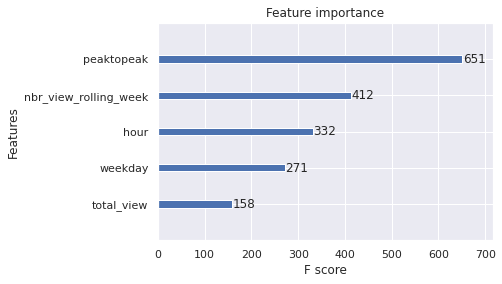

In [340]:
xgb.plot_importance(boost)

fig=plt.gcf()
fig.savefig("xgb_feature.png")

La feature 'peaktopeak' est encore un élément majeur du model.

On peut représenter le modèle par un arbre de décision.

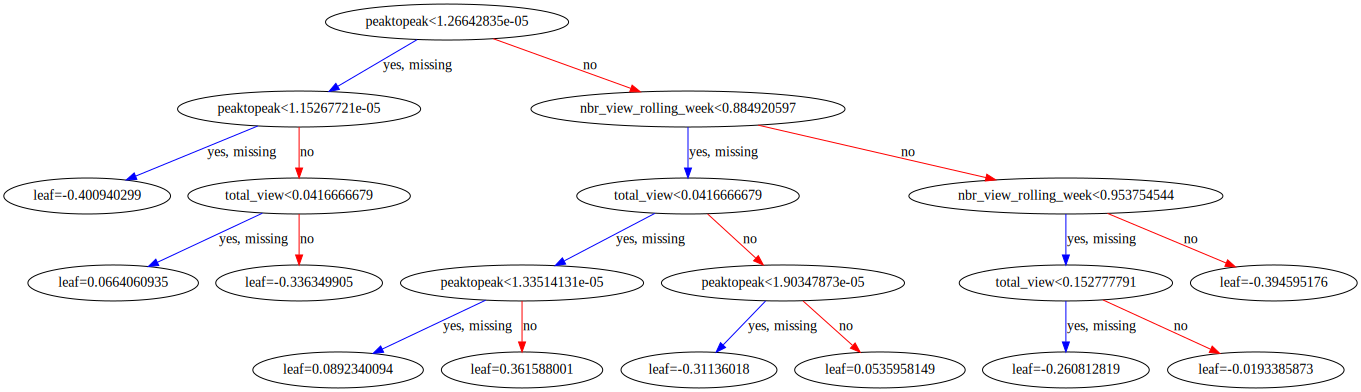

In [341]:
xgb.to_graphviz(boost, num_trees=2)

Modèle avec l'échantillon rééchantillonné :

In [342]:
# Paramètres du modèle
params = {'objective': 'binary:logistic', 'max_depth': 4}

# Conversion des données en DMatrix
dtrain = xgb.DMatrix(X_ro, label=y_ro, feature_names=['hour', 'weekday', 'peaktopeak', 'nbr_view_rolling_week', 'total_view'])
dtest =  xgb.DMatrix(data = X_test, label = y_test, feature_names=['hour', 'weekday', 'peaktopeak', 'nbr_view_rolling_week', 'total_view'])

# Entraînement
boost = xgb.train(params, dtrain, 200)

In [343]:
probs = boost.predict(dtest)
preds = [0 if x<0.5 else 1 for x in probs]

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       552
         1.0       0.76      0.84      0.80       105

    accuracy                           0.93       657
   macro avg       0.86      0.89      0.88       657
weighted avg       0.94      0.93      0.93       657



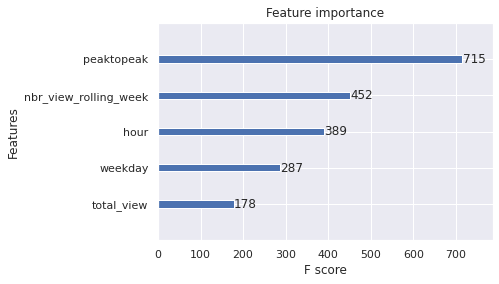

In [344]:
xgb.plot_importance(boost)

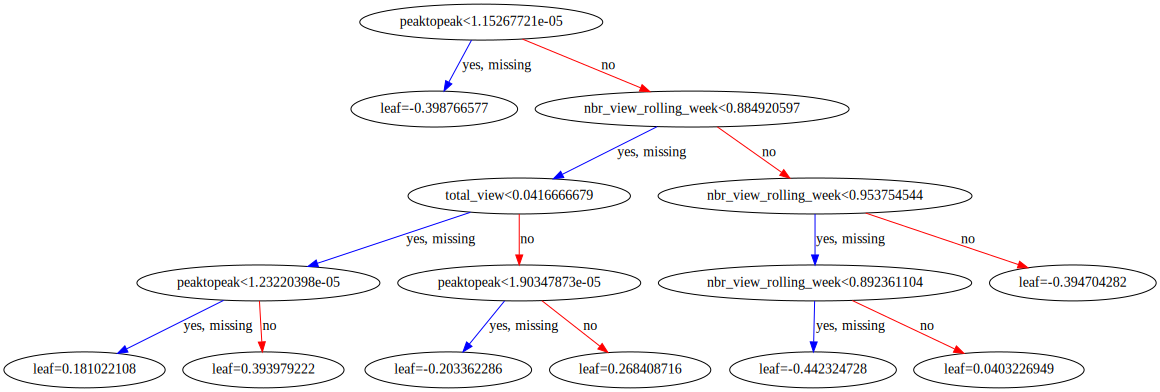

In [345]:
xgb.to_graphviz(boost, num_trees=2)

Sans avoir cherché à optimiser le modèle, on obtient des résultats très corrects. Les features les plus importantes sont encore peaktopeak, suivie de total_view et nbr_view_rolling_week.

### **Q5: peut-on prédire si un objet va être acheté ?**

In [346]:
events_item['transaction_finale']=events_item['total_transaction'].apply(lambda x: min(x,1))

Comme précédemment, on crée la feature peaktopeak.

In [347]:
time_onvisitor=events_item.groupby(by='visitorid')['timestamp'].agg(np.ptp).reset_index().rename(columns={'timestamp':'peaktopeak'})


In [348]:
events_item2=events_item.merge(time_onvisitor, on='visitorid')

events_item2.head()

timestamp  visitorid  ... transaction_finale  peaktopeak
0  1430773400263     741178  ...                  1           0
1  1430773625527     868541  ...                  0           0
2  1430778727991     499380  ...                  0           0
3  1430799384768    1175928  ...                  0       39599
4  1430799424367    1175928  ...                  0       39599

[5 rows x 23 columns]

In [349]:
events_item2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2969 entries, 0 to 2968
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     2969 non-null   int64  
 1   visitorid                     2969 non-null   int64  
 2   event                         2969 non-null   object 
 3   month                         2969 non-null   int64  
 4   weekday                       2969 non-null   int64  
 5   hour                          2969 non-null   int64  
 6   day_of_year                   2969 non-null   object 
 7   categoryid                    2969 non-null   float64
 8   parentid                      2969 non-null   float64
 9   addtocart                     2969 non-null   uint8  
 10  transaction                   2969 non-null   uint8  
 11  view                          2969 non-null   uint8  
 12  nbr_view_rolling_week         2969 non-null   float64
 13  nbr

In [350]:
features=events_item2[['hour','weekday','peaktopeak','nbr_view_rolling_week','total_view']]
target=events_item2.transaction_finale

In [351]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state= 42 )

In [352]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [353]:
print('Classes échantillon:', dict(pd.Series(y_train).value_counts()))

ros = RandomOverSampler()
X_ro, y_ro =ros.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

#SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

rus = RandomUnderSampler()
X_ru, y_ru =rus.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

#SMOTE
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)
print('Classes échantillon ClusterCentroids :', dict(pd.Series(y_cc).value_counts()))

Classes échantillon: {0: 1792, 1: 583}
Classes échantillon oversampled : {1: 1792, 0: 1792}
Classes échantillon SMOTE : {1: 1792, 0: 1792}
Classes échantillon undersampled : {1: 583, 0: 583}
Classes échantillon ClusterCentroids : {1: 583, 0: 583}


On constate un déséquilibre dans le jeu de données. On teste un modèle de Régression Logistique pour visualiser l'importance de l'oversampling/undersampling.

In [354]:
clf_lr=LogisticRegression(max_iter=1000)

params_lr ={'solver': ['liblinear', 'lbfgs'], 'C': [10**(i) for i in range(-4, 3)]}

gridcv=GridSearchCV(clf_lr, param_grid= params_lr,  scoring='accuracy', cv=3)

In [355]:
gridcv.fit(X_train, y_train)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

params  mean_test_score  std_test_score
0   {'C': 0.0001, 'solver': 'liblinear'}         0.754526        0.000537
1       {'C': 0.0001, 'solver': 'lbfgs'}         0.754526        0.000537
2    {'C': 0.001, 'solver': 'liblinear'}         0.754526        0.000537
3        {'C': 0.001, 'solver': 'lbfgs'}         0.754526        0.000537
4     {'C': 0.01, 'solver': 'liblinear'}         0.754526        0.000537
5         {'C': 0.01, 'solver': 'lbfgs'}         0.754526        0.000537
6      {'C': 0.1, 'solver': 'liblinear'}         0.762528        0.002591
7          {'C': 0.1, 'solver': 'lbfgs'}         0.762528        0.002591
8        {'C': 1, 'solver': 'liblinear'}         0.768421        0.005672
9            {'C': 1, 'solver': 'lbfgs'}         0.768000        0.005175
10      {'C': 10, 'solver': 'liblinear'}         0.767998        0.008817
11          {'C': 10, 'solver': 'lbfgs'}         0.767998        0.008817
12     {'C': 100, 'solver': 'liblinear'}         0.767998        0.008817
13         {'C': 100, 'solver': 'lbfgs'}         0.767998        0.008817

Le meilleur paramètrage est obtenu pour C=10 et solver='liblinear'.

In [356]:
clf_lr=LogisticRegression(max_iter=1000, C=10, solver='liblinear')

clf_lr.fit(X_train, y_train)
y_pred=clf_lr.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

print(classification_report_imbalanced(y_test, y_pred))

Classes prédites    0   1
Classes réelles          
0                 458  14
1                 101  21
                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.97      0.17      0.89      0.41      0.18       472
          1       0.60      0.17      0.97      0.27      0.41      0.15       122

avg / total       0.77      0.81      0.34      0.76      0.41      0.17       594



Le f1 score de la classe minoritaire est faible.

In [357]:
gridcv.fit(X_ro, y_ro)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

params  mean_test_score  std_test_score
0   {'C': 0.0001, 'solver': 'liblinear'}         0.525950        0.002403
1       {'C': 0.0001, 'solver': 'lbfgs'}         0.631696        0.010250
2    {'C': 0.001, 'solver': 'liblinear'}         0.559152        0.006308
3        {'C': 0.001, 'solver': 'lbfgs'}         0.631976        0.006151
4     {'C': 0.01, 'solver': 'liblinear'}         0.621935        0.010316
5         {'C': 0.01, 'solver': 'lbfgs'}         0.631140        0.010217
6      {'C': 0.1, 'solver': 'liblinear'}         0.638673        0.004447
7          {'C': 0.1, 'solver': 'lbfgs'}         0.646207        0.004007
8        {'C': 1, 'solver': 'liblinear'}         0.645369        0.004307
9            {'C': 1, 'solver': 'lbfgs'}         0.644533        0.006638
10      {'C': 10, 'solver': 'liblinear'}         0.643696        0.007841
11          {'C': 10, 'solver': 'lbfgs'}         0.643417        0.007677
12     {'C': 100, 'solver': 'liblinear'}         0.643417        0.007677
13         {'C': 100, 'solver': 'lbfgs'}         0.643417        0.007677

In [358]:
clf_lr=LogisticRegression(max_iter=1000, C=1, solver='liblinear')

clf_lr.fit(X_ro, y_ro)
y_pred=clf_lr.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

print(classification_report_imbalanced(y_test, y_pred))

Classes prédites    0    1
Classes réelles           
0                 341  131
1                  44   78
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.72      0.64      0.80      0.68      0.47       472
          1       0.37      0.64      0.72      0.47      0.68      0.46       122

avg / total       0.78      0.71      0.66      0.73      0.68      0.46       594



Le score f1 global s'est un peu rééquilibré entre les classes.

In [359]:
gridcv.fit(X_sm, y_sm)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

params  mean_test_score  std_test_score
0   {'C': 0.0001, 'solver': 'liblinear'}         0.518973        0.003778
1       {'C': 0.0001, 'solver': 'lbfgs'}         0.614396        0.012481
2    {'C': 0.001, 'solver': 'liblinear'}         0.550222        0.002904
3        {'C': 0.001, 'solver': 'lbfgs'}         0.633086        0.015302
4     {'C': 0.01, 'solver': 'liblinear'}         0.624719        0.007599
5         {'C': 0.01, 'solver': 'lbfgs'}         0.640065        0.005275
6      {'C': 0.1, 'solver': 'liblinear'}         0.638950        0.004657
7          {'C': 0.1, 'solver': 'lbfgs'}         0.639509        0.008203
8        {'C': 1, 'solver': 'liblinear'}         0.638114        0.009307
9            {'C': 1, 'solver': 'lbfgs'}         0.637836        0.010294
10      {'C': 10, 'solver': 'liblinear'}         0.636720        0.010801
11          {'C': 10, 'solver': 'lbfgs'}         0.636999        0.009918
12     {'C': 100, 'solver': 'liblinear'}         0.636441        0.010683
13         {'C': 100, 'solver': 'lbfgs'}         0.636441        0.010683

In [360]:
clf_lr=LogisticRegression(max_iter=1000, C=0.1, solver='lbfgs')

clf_lr.fit(X_sm, y_sm)
y_pred=clf_lr.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

print(classification_report_imbalanced(y_test, y_pred))

Classes prédites    0    1
Classes réelles           
0                 332  140
1                  42   80
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.70      0.66      0.78      0.68      0.46       472
          1       0.36      0.66      0.70      0.47      0.68      0.46       122

avg / total       0.78      0.69      0.67      0.72      0.68      0.46       594



In [361]:
gridcv.fit(X_ru, y_ru)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

params  mean_test_score  std_test_score
0   {'C': 0.0001, 'solver': 'liblinear'}         0.541166        0.003149
1       {'C': 0.0001, 'solver': 'lbfgs'}         0.544676        0.064999
2    {'C': 0.001, 'solver': 'liblinear'}         0.551462        0.008227
3        {'C': 0.001, 'solver': 'lbfgs'}         0.603802        0.026906
4     {'C': 0.01, 'solver': 'liblinear'}         0.613199        0.011844
5         {'C': 0.01, 'solver': 'lbfgs'}         0.632077        0.030466
6      {'C': 0.1, 'solver': 'liblinear'}         0.640651        0.024161
7          {'C': 0.1, 'solver': 'lbfgs'}         0.634648        0.029389
8        {'C': 1, 'solver': 'liblinear'}         0.645796        0.019967
9            {'C': 1, 'solver': 'lbfgs'}         0.642358        0.020406
10      {'C': 10, 'solver': 'liblinear'}         0.643226        0.016810
11          {'C': 10, 'solver': 'lbfgs'}         0.643226        0.016810
12     {'C': 100, 'solver': 'liblinear'}         0.644083        0.017842
13         {'C': 100, 'solver': 'lbfgs'}         0.644083        0.017842

In [362]:
clf_lr=LogisticRegression(max_iter=1000, C=0.1, solver='lbfgs')

clf_lr.fit(X_ru, y_ru)
y_pred=clf_lr.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

print(classification_report_imbalanced(y_test, y_pred))

Classes prédites    0    1
Classes réelles           
0                 344  128
1                  47   75
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.73      0.61      0.80      0.67      0.45       472
          1       0.37      0.61      0.73      0.46      0.67      0.44       122

avg / total       0.77      0.71      0.64      0.73      0.67      0.45       594



In [363]:
gridcv.fit(X_cc, y_cc)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

params  mean_test_score  std_test_score
0   {'C': 0.0001, 'solver': 'liblinear'}         0.503428        0.003973
1       {'C': 0.0001, 'solver': 'lbfgs'}         0.520621        0.030980
2    {'C': 0.001, 'solver': 'liblinear'}         0.502571        0.002777
3        {'C': 0.001, 'solver': 'lbfgs'}         0.522337        0.032022
4     {'C': 0.01, 'solver': 'liblinear'}         0.512025        0.019731
5         {'C': 0.01, 'solver': 'lbfgs'}         0.543759        0.019505
6      {'C': 0.1, 'solver': 'liblinear'}         0.542059        0.028885
7          {'C': 0.1, 'solver': 'lbfgs'}         0.548909        0.021053
8        {'C': 1, 'solver': 'liblinear'}         0.560919        0.024045
9            {'C': 1, 'solver': 'lbfgs'}         0.560060        0.023760
10      {'C': 10, 'solver': 'liblinear'}         0.560065        0.027075
11          {'C': 10, 'solver': 'lbfgs'}         0.560065        0.027075
12     {'C': 100, 'solver': 'liblinear'}         0.560921        0.026120
13         {'C': 100, 'solver': 'lbfgs'}         0.560921        0.026120

In [364]:
clf_lr=LogisticRegression(max_iter=1000, C=1, solver='lbfgs')

clf_lr.fit(X_cc, y_cc)
y_pred=clf_lr.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

print(classification_report_imbalanced(y_test, y_pred))

Classes prédites    0    1
Classes réelles           
0                 346  126
1                  57   65
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.73      0.53      0.79      0.62      0.40       472
          1       0.34      0.53      0.73      0.42      0.62      0.38       122

avg / total       0.75      0.69      0.57      0.71      0.62      0.40       594



Les diverses méthodes d'oversampling/undersampling donnent globalement des résultats équivalents et augmentent toutes le score f1 de la classe minoritaire pour la régression logistique.
Dans la suite, on sélectionnera des modèles en utilisant l'échantillon de base, puis l'échantillon rééchantillonné par RandomOverSampler.

#### Sélection de modèles

In [365]:
lr = LogisticRegression(random_state=22, max_iter=2000)
clf = RandomForestClassifier(random_state=22)
svm = SVC(random_state=22)

param_grid_lr = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)}

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                        'min_samples_leaf': [1, 3, 5],
                        'max_features': ['sqrt', 'log2']}]

param_grid_svc = [{'kernel': ['rbf'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
                       {'kernel': ['linear'], 'C': np.logspace(-4, 4, 9)}]

In [366]:
gridcvs ={}

for pgrid, clf, name in zip((param_grid_lr, param_grid_rf, param_grid_svc),
                            (lr, clf, svm),
                            ('LogisticRegression', 'RF', 'SVM')):
    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
    gridcvs[name] = gcv

In [367]:
outer_cv = StratifiedKFold(n_splits=3, shuffle= True)

outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_train, y_train, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

LogisticRegression: outer accuracy 77.01 +/- 0.98
RF: outer accuracy 91.62 +/- 0.66
SVM: outer accuracy 78.32 +/- 0.51


Le meilleur modèle est le Random Forest Classifier.

In [368]:
final_clf = gridcvs['RF']
final_clf.fit(X_train, y_train)

print(f'Meilleurs paramètres: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_clf.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Meilleurs paramètres: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 250}
Training Accuracy: 100.00
Test Accuracy: 95.96


L'accuracy est très bonne, mais la différence de quatre points entre l'échantillon d'entraînement et de test indique de l'overfitting.

In [369]:
rf_visitor=RandomForestClassifier(max_features='sqrt', min_samples_leaf=1, n_estimators=250)

rf_visitor.fit(X_train, y_train)

y_pred = rf_visitor.predict(X_test)

pd.crosstab(y_test, y_pred, rownames =['Classe réelle'], colnames =['Classe prédite'])

Classe prédite    0    1
Classe réelle           
0               464    8
1                11  111

In [370]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.98      0.91      0.98      0.95      0.90       472
          1       0.93      0.91      0.98      0.92      0.95      0.89       122

avg / total       0.97      0.97      0.92      0.97      0.95      0.90       594



Le f1 score est bon, même pour la classe minoritaire.

In [371]:
feats = {}
for feature, importance in zip(features.columns, rf_visitor.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

Importance
peaktopeak               0.491712
total_view               0.209042
hour                     0.142022
weekday                  0.094485
nbr_view_rolling_week    0.062739

On réitère les mêmes étapes avec les échantillons rééchantillonnés.

In [372]:
outer_cv = StratifiedKFold(n_splits=3, shuffle= True)

outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_ro, y_ro, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

LogisticRegression: outer accuracy 64.26 +/- 0.68
RF: outer accuracy 95.62 +/- 0.22
SVM: outer accuracy 73.41 +/- 0.91


Le meilleur modèle est le Random Forest Classifier.

In [373]:
final_clf = gridcvs['RF']
final_clf.fit(X_ro, y_ro)

print(f'Meilleurs paramètres: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_ro, y_pred=final_clf.predict(X_ro))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Meilleurs paramètres: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
Training Accuracy: 100.00
Test Accuracy: 95.79


In [374]:
rf_visitor=RandomForestClassifier(max_features='sqrt', min_samples_leaf=1, n_estimators=50)

rf_visitor.fit(X_ro, y_ro)

y_pred = rf_visitor.predict(X_test)

pd.crosstab(y_test, y_pred, rownames =['Classe réelle'], colnames =['Classe prédite'])

Classe prédite    0    1
Classe réelle           
0               461   11
1                12  110

In [375]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.98      0.90      0.98      0.94      0.89       472
          1       0.91      0.90      0.98      0.91      0.94      0.87       122

avg / total       0.96      0.96      0.92      0.96      0.94      0.88       594



Le f1 score diminue peu après oversampling.

In [376]:
feats = {}
for feature, importance in zip(features.columns, rf_visitor.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

Importance
peaktopeak               0.539117
total_view               0.196191
hour                     0.129047
weekday                  0.080867
nbr_view_rolling_week    0.054778

Le feature peaktopeak explique très largement le résultat cible. Ce feature étant facile à mesurer en temps réel, il est pertinent à utiliser en pratique.

#### Méthode d'ensemble

Comme précédemment, nous allons utiliser à la fois l'échantillon de base puis l'échantillon rééchantillonné pour tester la robustesse des méthodes d'ensemble.

La première méthode testée sera AdaBoost.

In [377]:
dtc= DecisionTreeClassifier(max_depth=5)

ac= AdaBoostClassifier(base_estimator = dtc, n_estimators = 400)

ac.fit(X_train, y_train)

ac.score(X_test, y_test)

0.9865319865319865

In [378]:
y_pred = ac.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites    0    1
Classes Réelles           
0                 470    2
1                   6  116

In [379]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.95      0.99      0.97      0.95       472
          1       0.98      0.95      1.00      0.97      0.97      0.94       122

avg / total       0.99      0.99      0.96      0.99      0.97      0.95       594



Méthode avec l'échantillon rééchantillonné:

In [380]:
ac.fit(X_ro, y_ro)

ac.score(X_test, y_test)

0.9797979797979798

In [381]:
y_pred = ac.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites    0    1
Classes Réelles           
0                 466    6
1                   6  116

In [382]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.95      0.99      0.97      0.94       472
          1       0.95      0.95      0.99      0.95      0.97      0.94       122

avg / total       0.98      0.98      0.96      0.98      0.97      0.94       594



AdaBoost donne des résultats très supérieurs au classifieur Random Forest.

On teste un modèle de classification Bagging.

In [383]:
bc= BaggingClassifier(base_estimator = dtc, n_estimators=1000, oob_score= True)

bc.fit(X_train, y_train)

bc.oob_score_

0.8176842105263158

In [384]:
y_pred = bc.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites    0   1
Classes Réelles          
0                 465   7
1                  84  38

In [385]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.99      0.31      0.91      0.55      0.33       472
          1       0.84      0.31      0.99      0.46      0.55      0.29       122

avg / total       0.85      0.85      0.45      0.82      0.55      0.32       594



In [386]:
bc= BaggingClassifier(base_estimator = dtc, n_estimators=1000, oob_score= True)

bc.fit(X_ro, y_ro)

bc.oob_score_

0.7857142857142857

In [387]:
y_pred = bc.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites    0    1
Classes Réelles           
0                 267  205
1                   1  121

In [388]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.57      0.99      0.72      0.75      0.54       472
          1       0.37      0.99      0.57      0.54      0.75      0.58       122

avg / total       0.87      0.65      0.90      0.68      0.75      0.55       594



Le classifieur Bagging donne ici de piètres résultats.

On utilise ensuite un modèle de classification Voting.

In [389]:
clf1=RandomForestClassifier()
clf2=LogisticRegression()
clf3=SVC()

cv3=KFold(n_splits=3, shuffle= True, random_state=42)

In [390]:
vclf=VotingClassifier(estimators=[('rf', clf1), ('lr', clf2), ('svm', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, vclf], ['Random Forest', 'Logistic Regression', 'SVM', 'Voting Classifier']):
    scores = cross_validate(clf, X_train, y_train, cv=cv3, scoring=['accuracy','f1'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))

[Random Forest]: 
 Accuracy: 0.92 (+/- 0.01) F1 score: 0.82 (+/- 0.01)
[Logistic Regression]: 
 Accuracy: 0.77 (+/- 0.02) F1 score: 0.22 (+/- 0.02)
[SVM]: 
 Accuracy: 0.78 (+/- 0.01) F1 score: 0.19 (+/- 0.02)
[Voting Classifier]: 
 Accuracy: 0.79 (+/- 0.02) F1 score: 0.28 (+/- 0.02)


In [391]:
vclf.fit(X_train, y_train)
print(vclf.score(X_test,y_test))

0.8367003367003367


In [392]:
y_pred = vclf.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites    0   1
Classes Réelles          
0                 472   0
1                  97  25

In [393]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      1.00      0.20      0.91      0.45      0.22       472
          1       1.00      0.20      1.00      0.34      0.45      0.19       122

avg / total       0.86      0.84      0.37      0.79      0.45      0.21       594



In [394]:
vclf=VotingClassifier(estimators=[('rf', clf1), ('lr', clf2), ('svm', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, vclf], ['Random Forest', 'Logistic Regression', 'SVM', 'Voting Classifier']):
    scores = cross_validate(clf, X_ro, y_ro, cv=cv3, scoring=['accuracy','f1'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))

[Random Forest]: 
 Accuracy: 0.96 (+/- 0.00) F1 score: 0.96 (+/- 0.00)
[Logistic Regression]: 
 Accuracy: 0.64 (+/- 0.01) F1 score: 0.62 (+/- 0.02)
[SVM]: 
 Accuracy: 0.69 (+/- 0.02) F1 score: 0.70 (+/- 0.02)
[Voting Classifier]: 
 Accuracy: 0.74 (+/- 0.02) F1 score: 0.73 (+/- 0.02)


In [395]:
vclf.fit(X_ro, y_ro)
print(vclf.score(X_test,y_test))

0.7643097643097643


In [396]:
y_pred = vclf.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites    0    1
Classes Réelles           
0                 367  105
1                  35   87

In [397]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.78      0.71      0.84      0.74      0.56       472
          1       0.45      0.71      0.78      0.55      0.74      0.55       122

avg / total       0.82      0.76      0.73      0.78      0.74      0.56       594



Les performances de ce classifieurs sont mauvaises, les classifieurs SVM et Régression Logistique étant eux-même peu performants.

On teste enfin un modèle Stacking Classifier, en utilisant Random Forest comme classifieur final.

In [398]:
sclf=StackingClassifier(estimators=[('rf', clf1), ('lr', clf2),  ('svm', clf3)], final_estimator=clf2)

for clf, label in zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'Logistic Regression', 'SVM', 'Stacking Classifier']):
    scores = cross_validate(clf, X_train, y_train, cv=cv3, scoring=['accuracy','f1'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))

[KNN]: 
 Accuracy: 0.92 (+/- 0.01) F1 score: 0.82 (+/- 0.02)
[Random Forest]: 
 Accuracy: 0.77 (+/- 0.02) F1 score: 0.22 (+/- 0.02)
[Logistic Regression]: 
 Accuracy: 0.78 (+/- 0.01) F1 score: 0.19 (+/- 0.02)
[SVM]: 
 Accuracy: 0.91 (+/- 0.01) F1 score: 0.82 (+/- 0.02)


In [399]:
sclf.fit(X_train, y_train)
print(sclf.score(X_test,y_test))

0.9629629629629629


In [400]:
y_pred = sclf.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites    0    1
Classes Réelles           
0                 462   10
1                  12  110

In [401]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.98      0.90      0.98      0.94      0.89       472
          1       0.92      0.90      0.98      0.91      0.94      0.88       122

avg / total       0.96      0.96      0.92      0.96      0.94      0.89       594



Avec l'échantillon rééchantillonné:

In [402]:
sclf.fit(X_ro, y_ro)
print(sclf.score(X_test,y_test))

0.9713804713804713


In [403]:
y_pred = sclf.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classes Réelles'], colnames=['Classes Prédites'])

Classes Prédites    0    1
Classes Réelles           
0                 468    4
1                  13  109

In [404]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.99      0.89      0.98      0.94      0.89       472
          1       0.96      0.89      0.99      0.93      0.94      0.88       122

avg / total       0.97      0.97      0.91      0.97      0.94      0.89       594



Les performances sont excellentes, légèrement inférieures à celles d'AdaBoost.

#### XGBoost

On tente enfin le classifieur XGBoost, sans rentrer dans l'optimisation détaillée des paramètres.

On commence par l'échantillon classique:

In [405]:
# Paramètres d'entraînement
params = {'objective': 'binary:logistic', 'max_depth': 4}

# Conversion des jeux de données en DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=['hour', 'weekday', 'peaktopeak', 'nbr_view_rolling_week', 'total_view'])
dtest =  xgb.DMatrix(data = X_test, label = y_test, feature_names=['hour', 'weekday', 'peaktopeak', 'nbr_view_rolling_week', 'total_view'])

# Entraînement du modèle
boost = xgb.train(params, dtrain, 200)

In [406]:
probs = boost.predict(dtest)
preds = [0 if x<0.5 else 1 for x in probs]

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       472
           1       0.97      0.97      0.97       122

    accuracy                           0.99       594
   macro avg       0.98      0.98      0.98       594
weighted avg       0.99      0.99      0.99       594



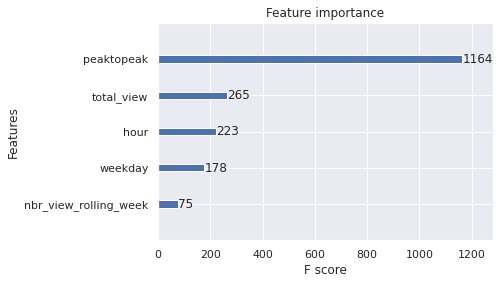

In [407]:
xgb.plot_importance(boost)

La feature 'peaktopeak' est encore un élément majeur du model.

On peut représenter le modèle par un arbre de décision.

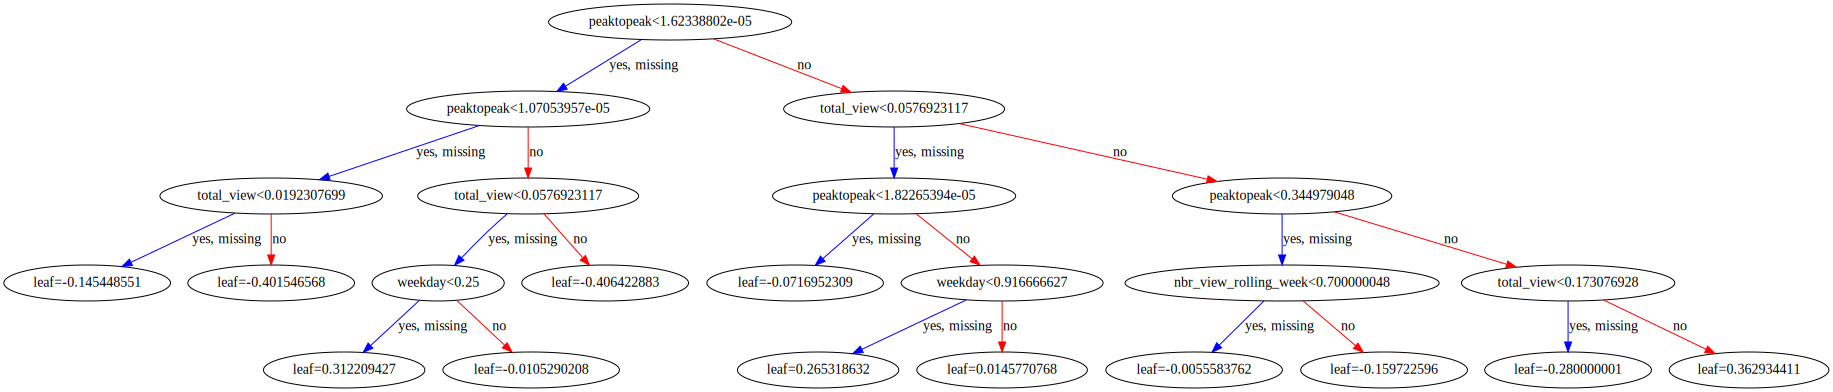

In [408]:
xgb.to_graphviz(boost, num_trees=2)

Modèle avec l'échantillon rééchantillonné :

In [409]:
# Paramètres du modèle
params = {'objective': 'binary:logistic', 'max_depth': 4}

# Conversion des données en DMatrix
dtrain = xgb.DMatrix(X_ro, label=y_ro, feature_names=['hour', 'weekday', 'peaktopeak', 'nbr_view_rolling_week', 'total_view'])
dtest =  xgb.DMatrix(data = X_test, label = y_test, feature_names=['hour', 'weekday', 'peaktopeak', 'nbr_view_rolling_week', 'total_view'])

# Entraînement
boost = xgb.train(params, dtrain, 200)

In [410]:
probs = boost.predict(dtest)
preds = [0 if x<0.5 else 1 for x in probs]

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       472
           1       0.97      0.97      0.97       122

    accuracy                           0.99       594
   macro avg       0.98      0.98      0.98       594
weighted avg       0.99      0.99      0.99       594



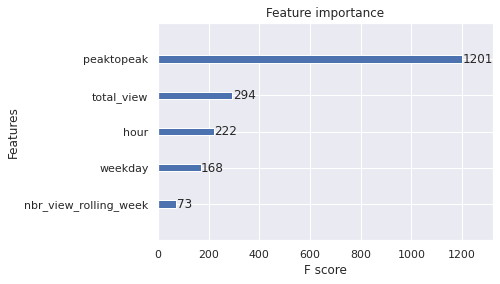

In [411]:
xgb.plot_importance(boost)

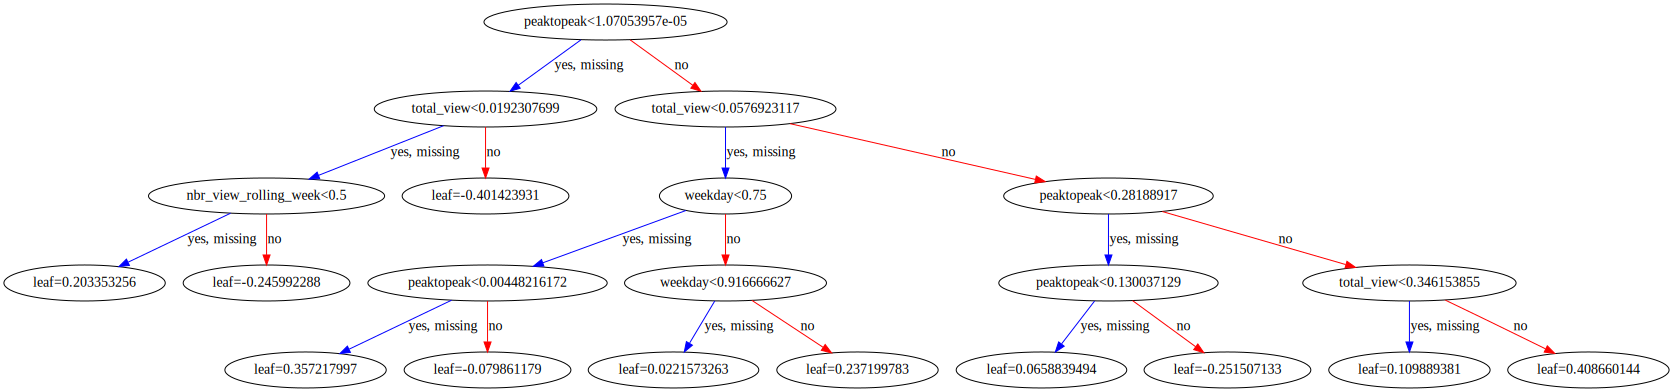

In [412]:
xgb.to_graphviz(boost, num_trees=2)

Sans avoir cherché à optimiser le modèle, XGBoost dépasse les autres modèles.

 Les features les plus importantes sont encore peaktopeak, suivie de total_view et nbr_view_rolling_week.

### **Q6: Peut-on trouver des règles d'association dans les paniers ?**

On ne s'intéresse ici qu'aux objets au moment des transactions.

In [413]:
transactions=events[events['event']=='transaction'][['itemid','transactionid','categoryid','parentid']]

transactions.head()

itemid  transactionid  categoryid  parentid
99   420367         9269.0      1130.0    1323.0
199   49117        11152.0      1130.0    1323.0
417   49990        10179.0      1130.0    1323.0
435   83730        10718.0      1130.0    1323.0
471   83730         1573.0      1130.0    1323.0

En regroupant les objets selon transactionid, on obtient tous les paniers.

In [414]:
panier=transactions.groupby('transactionid').agg(list)

panier.head()

itemid categoryid  parentid
transactionid                               
0.0            [425758]   [1509.0]   [620.0]
1.0            [454430]    [828.0]   [293.0]
2.0            [151855]    [686.0]   [594.0]
3.0             [85842]   [1503.0]   [580.0]
4.0            [224184]   [1279.0]  [1606.0]

On ne garde que les paniers contenant au moins deux objets achetés.

In [415]:
panier=panier[panier['itemid'].map(len)>=2]

panier.head()

itemid  ...                         parentid
transactionid                                    ...                                 
12.0                           [432742, 239235]  ...                  [1531.0, 605.0]
23.0             [93556, 397642, 57548, 351124]  ...  [1215.0, 1215.0, 441.0, 1416.0]
27.0           [272976, 272770, 288078, 130226]  ...     [852.0, 852.0, 968.0, 995.0]
28.0            [195958, 127123, 31830, 213834]  ...     [561.0, 561.0, 955.0, 561.0]
37.0                           [192990, 370745]  ...                   [620.0, 121.0]

[5 rows x 3 columns]

On s'intéresse d'abord aux associations d'objets, sans tenir compte des catégories.

In [416]:
panier_item=panier.itemid

In [417]:
te = TransactionEncoder()
te_ary = te.fit(panier_item).transform(panier_item)
df = pd.DataFrame(te_ary, columns=te.columns_)

On applique l'algorithme APriori pour obtenir les ensembles d'items avec leur fréquence d'apparition (=support).

In [418]:
frequent_itemsets = apriori(df, min_support=0.001, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

support                                 itemsets  length
0    0.001127                                   (1684)       1
1    0.001127                                   (4067)       1
2    0.001127                                   (4887)       1
3    0.001878                                   (7804)       1
4    0.001127                                   (8015)       1
..        ...                                      ...     ...
462  0.001127          (357529, 382130, 10572, 146642)       4
463  0.001127          (357529, 382130, 10572, 341869)       4
464  0.001127          (132633, 307117, 284414, 28789)       4
465  0.001127         (357529, 382130, 341869, 146642)       4
466  0.001127  (10572, 341869, 382130, 146642, 357529)       5

[467 rows x 3 columns]

On peut regarder par exemple les ensembles d'items à 3 éléments.

In [419]:
frequent_itemsets[ frequent_itemsets['length'] == 3 ]

support                  itemsets  length
437  0.001127   (146642, 10572, 341869)       3
438  0.001127   (357529, 146642, 10572)       3
439  0.001127   (146642, 382130, 10572)       3
440  0.001127   (357529, 10572, 341869)       3
441  0.001127   (382130, 10572, 341869)       3
442  0.001127   (357529, 382130, 10572)       3
443  0.001127    (317192, 28161, 42874)       3
444  0.001127   (132633, 28789, 284414)       3
445  0.001127   (132633, 307117, 28789)       3
446  0.001127   (307117, 284414, 28789)       3
447  0.001127    (72715, 376151, 57247)       3
448  0.001127  (242314, 105870, 417927)       3
449  0.001127  (256146, 120098, 140527)       3
450  0.001502  (132633, 307117, 284414)       3
451  0.001127  (357529, 146642, 341869)       3
452  0.001127  (146642, 382130, 341869)       3
453  0.001127  (357529, 382130, 146642)       3
454  0.001127  (387504, 167827, 390167)       3
455  0.001127  (297145, 185082, 307733)       3
456  0.001127  (301721, 216266, 369158)       3
457  0.001127  (297145, 222772, 307733)       3
458  0.001502  (379520, 432171, 269773)       3
459  0.001127  (357529, 382130, 341869)       3

On en déduit l'ensemble des règles d'associations.

In [420]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

rules

antecedents                       consequents  ...  leverage  conviction
0      (146642)                           (10572)  ...  0.001119         inf
1       (10572)                          (146642)  ...  0.001119    1.212918
2       (10572)                          (333039)  ...  0.001119    1.212918
3      (333039)                           (10572)  ...  0.001119         inf
4       (10572)                          (341869)  ...  0.001119    1.212918
..          ...                               ...  ...       ...         ...
399     (10572)  (357529, 146642, 382130, 341869)  ...  0.001119    1.212918
400    (341869)   (357529, 146642, 382130, 10572)  ...  0.001125         inf
401    (382130)   (357529, 146642, 10572, 341869)  ...  0.001124    1.997747
402    (146642)   (357529, 382130, 10572, 341869)  ...  0.001125         inf
403    (357529)   (146642, 382130, 10572, 341869)  ...  0.001124    2.497184

[404 rows x 9 columns]

On peut s'intéresser aux règles d'associations partant d'itemsets avec plusieurs objets. On triera les règles pour que les plus significatives (=lift) soient en tête.

In [421]:
rules['length_antecedents'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['length_antecedents']>1].sort_values('lift', ascending=False)

antecedents       consequents  ...  conviction  length_antecedents
152           (146642, 10572)          (341869)  ...         inf                   2
361  (357529, 382130, 146642)          (341869)  ...         inf                   3
341           (10572, 341869)  (357529, 382130)  ...         inf                   2
339           (382130, 10572)  (357529, 341869)  ...         inf                   2
338          (357529, 341869)   (382130, 10572)  ...         inf                   2
..                        ...               ...  ...         ...                 ...
333  (357529, 382130, 341869)           (10572)  ...         inf                   3
158          (357529, 146642)           (10572)  ...         inf                   2
153          (146642, 341869)           (10572)  ...         inf                   2
267          (301721, 369158)          (216266)  ...    1.744743                   2
266          (301721, 216266)          (369158)  ...         inf                   2

[154 rows x 10 columns]

On peut représenter les règles selon le support, la confidence (=probabilité conditionnelle de l'itemset conséquent sachant que l'on a l'itemset antécédent) et le lift.

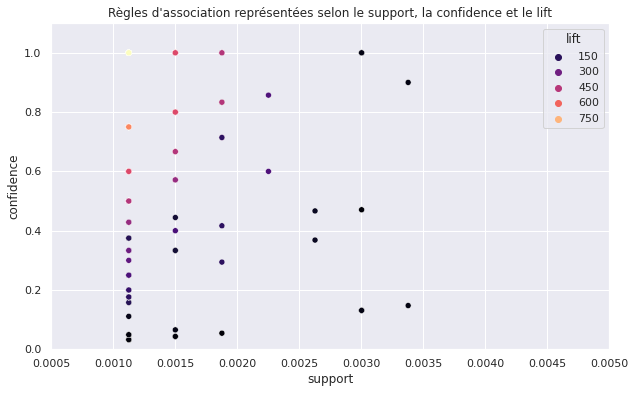

In [422]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = "support", y = "confidence", 
                hue = "lift", data = rules, palette="magma")
plt.margins(0.01,0.01)
plt.xlim([0.0005,0.005])
plt.ylim([0,1.1])
plt.title("Règles d'association représentées selon le support, la confidence et le lift")
plt.show()

On peut définir une fonction qui recommande d'autres produits selon un objet acheté.

In [423]:
rules['length_consequents'] = rules['consequents'].apply(lambda x:len(x) )

def recommendation(itemid):
    print("Vous avez acheté l'objet n°", itemid)
    print("Nous vous recommendons les produits identifiés par les numéros suivants:")
    df=rules[rules['antecedents'].eq({itemid})]
    return df.sort_values('length_consequents', ascending=False).sort_values('lift', ascending=False).reset_index()['consequents'][0]

recommendation(146642)

Vous avez acheté l'objet n° 146642
Nous vous recommendons les produits identifiés par les numéros suivants:


frozenset({10572, 341869, 357529, 382130})

On peut regarder les paniers selon la catégorie des items. Les étapes sont identiques.

In [424]:
panier_categoryid=panier.categoryid

In [425]:
te = TransactionEncoder()
te_ary = te.fit(panier_categoryid).transform(panier_categoryid)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [426]:
frequent_categorysets = apriori(df, min_support=0.001, use_colnames=True)
frequent_categorysets['length'] = frequent_categorysets['itemsets'].apply(lambda x: len(x))
frequent_categorysets

support                        itemsets  length
0    0.003380                           (0.0)       1
1    0.006008                           (1.0)       1
2    0.001127                           (3.0)       1
3    0.003004                           (4.0)       1
4    0.007886                           (5.0)       1
..        ...                             ...     ...
935  0.001502   (1393.0, 196.0, 469.0, 959.0)       4
936  0.001127   (944.0, 1040.0, 427.0, 268.0)       4
937  0.001127   (944.0, 1040.0, 427.0, 926.0)       4
938  0.001127   (586.0, 628.0, 589.0, 1135.0)       4
939  0.001127  (1051.0, 1483.0, 589.0, 959.0)       4

[940 rows x 3 columns]

In [427]:
rules_category = association_rules(frequent_categorysets, metric="lift", min_threshold=1)

rules_category.sort_values('lift', ascending=False)

antecedents       consequents  ...  leverage  conviction
833      (56.0, 806.0)          (1188.0)  ...  0.001125         inf
836           (1188.0)     (56.0, 806.0)  ...  0.001125    3.995494
29              (37.0)          (1649.0)  ...  0.001125    3.995494
28            (1649.0)            (37.0)  ...  0.001125         inf
661           (1053.0)           (997.0)  ...  0.001124         inf
...                ...               ...  ...       ...         ...
178            (196.0)          (1135.0)  ...  0.000206    1.008994
618            (928.0)          (1483.0)  ...  0.000037    1.002178
619           (1483.0)           (928.0)  ...  0.000037    1.000620
1548  (1483.0, 1163.0)          (1542.0)  ...  0.000030    1.000686
1553          (1542.0)  (1483.0, 1163.0)  ...  0.000030    1.000959

[1728 rows x 9 columns]

In [428]:
rules_category['length_antecedents'] = rules_category['antecedents'].apply(lambda x:len(x) )
rules_category['length_consequents'] = rules_category['consequents'].apply(lambda x:len(x) )
rules_category[rules_category['length_antecedents']>1].sort_values('lift', ascending=False)

antecedents      consequents  ...  length_antecedents  length_consequents
833      (56.0, 806.0)         (1188.0)  ...                   2                   1
1564   (624.0, 1072.0)   (267.0, 126.0)  ...                   2                   2
1569    (267.0, 126.0)  (624.0, 1072.0)  ...                   2                   2
1648   (1273.0, 147.0)   (926.0, 535.0)  ...                   2                   2
1653    (926.0, 535.0)  (1273.0, 147.0)  ...                   2                   2
...                ...              ...  ...                 ...                 ...
1481   (1051.0, 959.0)         (1135.0)  ...                   2                   1
839      (57.0, 959.0)         (1051.0)  ...                   2                   1
1396   (589.0, 1135.0)          (959.0)  ...                   2                   1
1544  (1483.0, 1163.0)         (1393.0)  ...                   2                   1
1548  (1483.0, 1163.0)         (1542.0)  ...                   2                   1

[493 rows x 11 columns]

### **Q7: Peut-on établir une segmentation des clients ?**

In [429]:
events2=events.join(pd.get_dummies(events['event']))

events2

timestamp  visitorid      event  ...  addtocart  transaction  view
0        1430622004384     693516  addtocart  ...          1            0     0
1        1430622026228     693516       view  ...          0            0     1
2        1430622029427     693516  addtocart  ...          1            0     0
3        1430629656175     640328       view  ...          0            0     1
4        1430695702554    1265708       view  ...          0            0     1
...                ...        ...        ...  ...        ...          ...   ...
2496641  1442335057091     276159       view  ...          0            0     1
2496642  1442075682202     198270       view  ...          0            0     1
2496643  1442169053784     994820       view  ...          0            0     1
2496644  1442169422404     994820       view  ...          0            0     1
2496645  1442352764146     293551       view  ...          0            0     1

[2496646 rows x 14 columns]

In [430]:
events2=events2[['timestamp','visitorid','itemid','weekday','hour','addtocart','transaction','view']]

In [431]:
function_to_apply={'timestamp': np.ptp,
                   'weekday': np.mean,
                   'hour': np.mean,
                   'addtocart': np.sum,
                   'transaction': np.sum,
                   'view': np.sum}

events2=events2.groupby(by=['visitorid','itemid']).agg(function_to_apply).reset_index().rename(columns={'timestamp':'peaktopeak'})

In [432]:
function_to_apply={'peaktopeak': np.mean,
                   'weekday': np.mean,
                   'hour': np.mean,
                   'addtocart': np.sum,
                   'transaction': np.sum,
                   'view': np.sum}


visitor=events2[['visitorid','peaktopeak','weekday','hour','addtocart','view','transaction']].groupby(by='visitorid').agg(function_to_apply)

In [433]:
scaler=MinMaxScaler()
visitor=pd.DataFrame(scaler.fit_transform(visitor), columns=visitor.columns, index=visitor.index)

In [434]:
visitor.to_csv("visitor.csv")

In [435]:
visitor=pd.read_csv("visitor.csv", index_col=0)
visitor.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


peaktopeak   weekday      hour  addtocart  transaction      view
visitorid                                                                  
0            0.000000  0.666667  0.869565        0.0          0.0  0.000556
1            0.000000  0.500000  0.739130        0.0          0.0  0.000185
2            0.000071  0.666667  0.764493        0.0          0.0  0.001481
3            0.000000  0.833333  0.304348        0.0          0.0  0.000185
5            0.000000  0.666667  0.043478        0.0          0.0  0.000185

#### **K-means**

Pour utiliser l'algorithme K-Means, il est important d'estimer le nombre optimal de clusters. Trois méthodes sont utilisées: la méthode du coude ("elbow method"), le score de silhouette et l'indice de Calinski-Harabasz. \\
La première méthode consiste à trouver l'abscisse d'un point représentant un coude sur le graphique reliant le nombre de clusters avec la distorsion ou l'inertie.


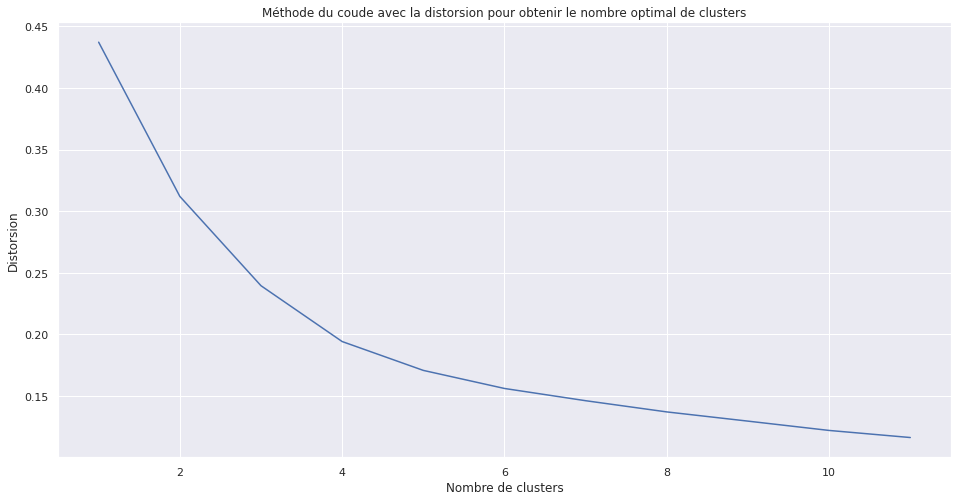

In [436]:
distorsion = []
K = range(1,12)
for k in K:
    model = KMeans(n_clusters=k)
    model.fit(visitor)
    centers=model.cluster_centers_
    distorsion.append(sum(np.min(cdist(visitor, centers,'euclidean'),axis=1)) / visitor.shape[0]) 

plt.figure(figsize=(16,8))
plt.plot(K, distorsion)
plt.xlabel('Nombre de clusters')
plt.ylabel('Distorsion')
plt.title('Méthode du coude avec la distorsion pour obtenir le nombre optimal de clusters')

fig= plt.gcf()
fig.savefig("distorsion_kmeans.png")

plt.show()

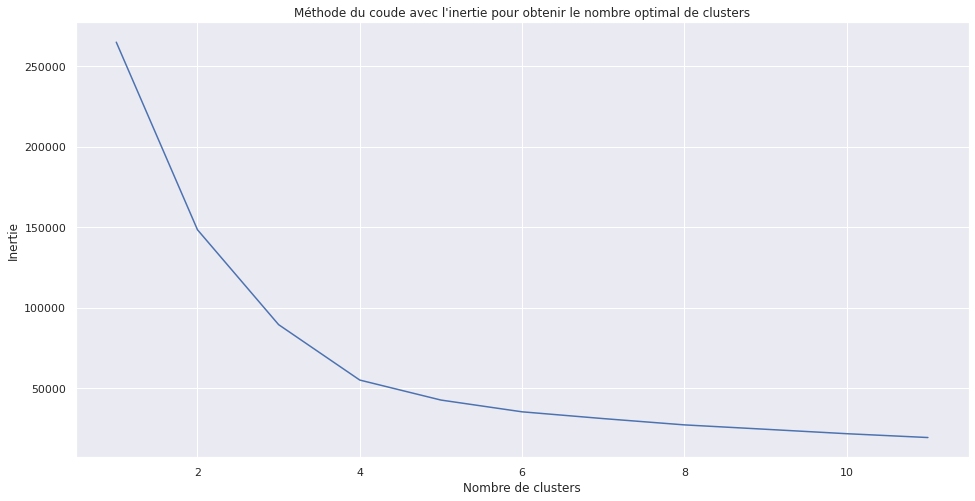

In [437]:
inertie = []
K = range(1,12)
for k in K:
    model = KMeans(n_clusters=k)
    model.fit(visitor)
    inertie.append(model.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertie)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title("Méthode du coude avec l'inertie pour obtenir le nombre optimal de clusters")

fig= plt.gcf()
fig.savefig("inertie_kmeans.png")

plt.show()

Que ce soit avec la distorsion ou l'inertie, cette méthode permet d'estimer le nombre de clusters optimal à 4. \\

La deuxième méthode cherche à maximiser le score de silhouette.

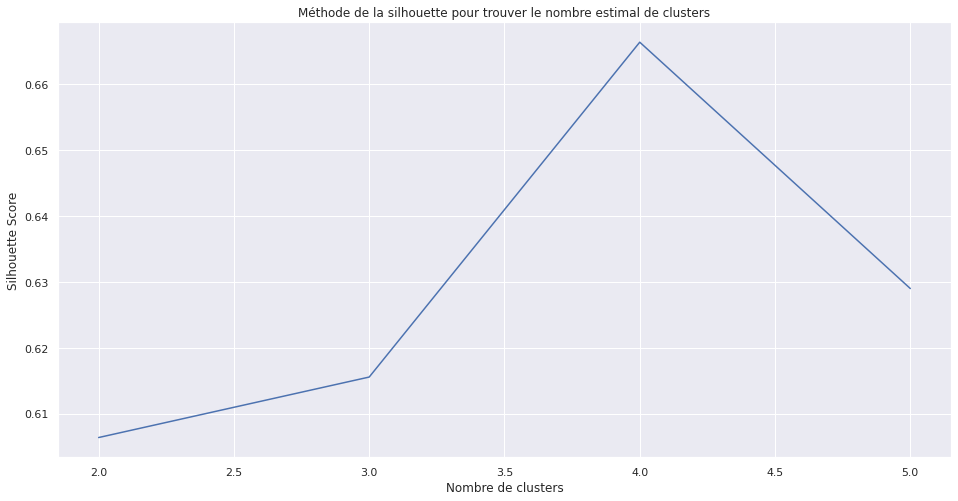

In [452]:
silhouette=[]
K=range(2,6)
test=visitor.sample(frac=0.01)

for k in K:
    cluster=KMeans(n_clusters= k)
    labels=cluster.fit_predict(test)
    silhouette.append(silhouette_score(test, labels= labels, metric='sqeuclidean'))
    
plt.figure(figsize=(16,8))
plt.plot(K, silhouette)
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la silhouette pour trouver le nombre estimal de clusters')

fig= plt.gcf()
fig.savefig("silhouette_kmeans.png")

plt.show()

La méthode de la silhouette estime le nombre de clusters optimal à 4. \\

La dernière méthode d'estimation utilisée est le score de Calinski-Harabasz. Le nombre de clusters optimal selon cette méthode correspond au score maximal.

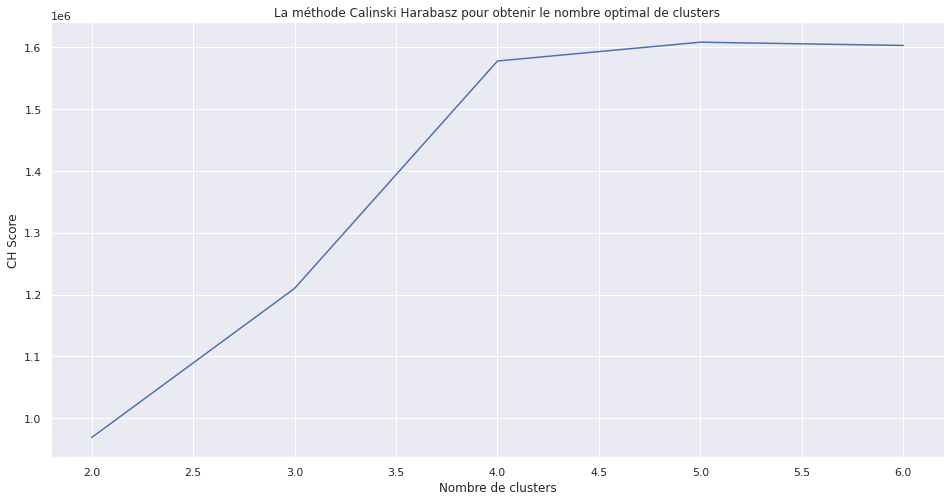

In [439]:
ch=[]
K= range(2,7)

for k in K:
    cluster=KMeans(n_clusters= k)
    cluster.fit(visitor)
    labels=cluster.labels_
    ch.append(calinski_harabasz_score(visitor, labels))
    
plt.figure(figsize=(16,8))
plt.plot(K, ch)
plt.xlabel('Nombre de clusters')
plt.ylabel('CH Score')
plt.title('La méthode Calinski Harabasz pour obtenir le nombre optimal de clusters')

fig= plt.gcf()
fig.savefig("ch_kmeans.png")

plt.show()

Les trois méthodes s'accordent sur un nombre de cluster optimal de 4.

In [443]:
cluster=KMeans(n_clusters=4)
labels=cluster.fit_predict(visitor)

label_kmean=pd.DataFrame(data=labels, index=visitor.index, columns=["label_KMean"])

#### **Agglomerative clustering**

L'Agglomerative Clustering étant gourmand en mémoire et en temps de calcul, l'analyse ne portera que sur un échantillon.

Un dendrogramme permet de visualiser les regroupements en clusters.

In [447]:
visitor_sample=visitor.sample(frac = 0.01) 

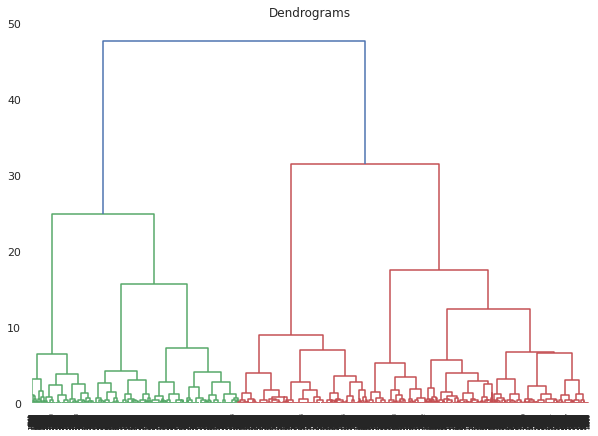

In [444]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(visitor_sample, method='ward'))

fig= plt.gcf()
fig.savefig("dendrograms.png")

Le nombre optimal de clusters semble être de 4 ou 5.

La méthode de la silhouette et le score de Calinski-Harabasz vont permettre de confirmer cette conjecture.

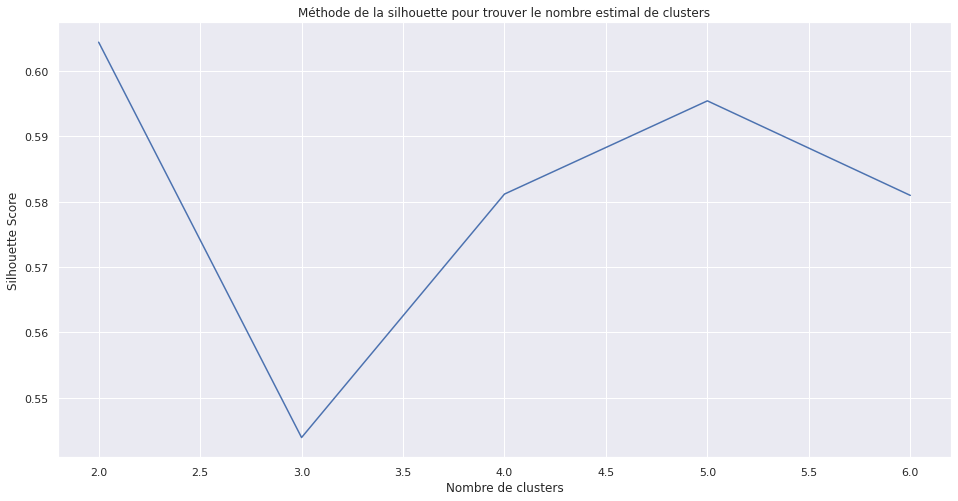

In [448]:
silhouette=[]
K=range(2,7)

for k in K:
    cluster=AgglomerativeClustering(n_clusters= k)
    labels=cluster.fit_predict(visitor_sample)
    silhouette.append(silhouette_score(visitor_sample, labels= labels, metric='sqeuclidean'))
    
plt.figure(figsize=(16,8))
plt.plot(K, silhouette)
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la silhouette pour trouver le nombre estimal de clusters')

plt.show()

La méthode de la silhouette estime le nombre de clusters optimal à 2 ou à 5.

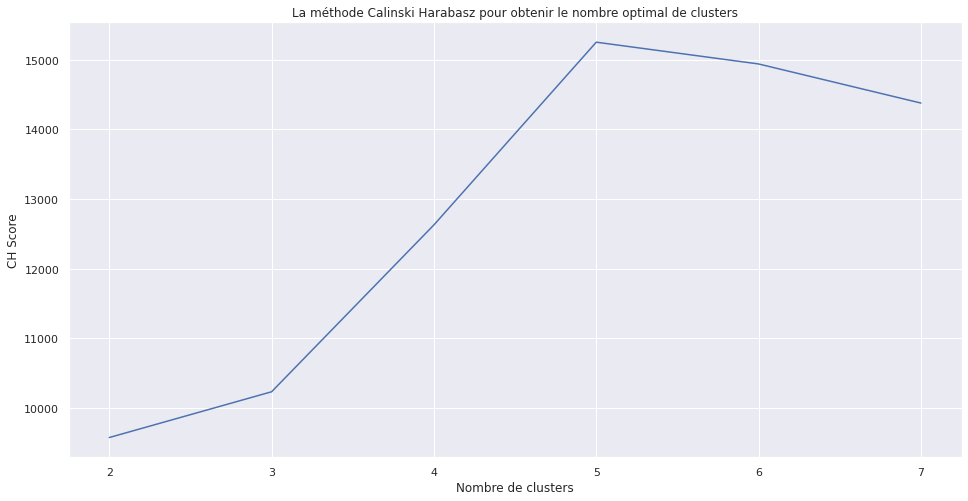

In [449]:
ch=[]
K= range(2,8)

for k in K:
    cluster=AgglomerativeClustering(n_clusters= k)
    cluster.fit(visitor_sample)
    labels=cluster.labels_
    ch.append(calinski_harabasz_score(visitor_sample, labels))
    
plt.figure(figsize=(16,8))
plt.plot(K, ch)
plt.xlabel('Nombre de clusters')
plt.ylabel('CH Score')
plt.title('La méthode Calinski Harabasz pour obtenir le nombre optimal de clusters')

plt.show()

La méthode Calinski Harabasz estime le nombre de cluster optimal à 5.

In [450]:
cluster=AgglomerativeClustering(n_clusters=5)
labels=cluster.fit_predict(visitor_sample)

label_aggl=pd.DataFrame(data=labels, index=visitor_sample.index, columns=["label_Agglomerative"])

In [451]:
X=label_aggl.join(label_kmean)

pd.crosstab(X['label_KMean'],X['label_Agglomerative'])

label_Agglomerative     0     1     2     3     4
label_KMean                                      
0                    2484    22    46     0     2
1                       0  1298     0     0  2471
2                       0  1867  1996     0     0
3                      13    51     0  2046    49

La correspondance entre les deux labelisations apparait satisfaisante.